In [38]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr
import pickle
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua
import trajectory as trj

import h5py
import ray
import pyproj
# ray.init(num_cpus=7)


In [39]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

In [3]:
def get_cuon(stat, year):
    # stat = '11035'
    # year = '2000'
    dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
    dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

    conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*' + stat + '*_CEUAS_merged_v1.nc')[0]
    # conv_file = glob.glob('./0-20001-0-11035_CEUAS_merged_v1.nc')[0]

    df_dict = {}
    u_df_dict = {}
    v_df_dict = {}

    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]


    with h5py.File(conv_file, 'r') as file:
        rts = file['recordindices']['recordtimestamp'][:]
        idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
        if len(idx) == 0:
            print('(1) NO DATA FOUND IN CONVERTED_V9: ', sid)
        u_idx = file['recordindices']['139'][idx]
        v_idx = file['recordindices']['140'][idx]
        t_idx = file['recordindices']['126'][idx]
        
#         plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
        
#         mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
#         mask = np.isin(mask,plevs)

#         u_mask = file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]]
#         u_mask = np.isin(u_mask,plevs)

#         v_mask = file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]]
#         v_mask = np.isin(v_mask,plevs)
        mask = len(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]])*[True]
        u_mask = len(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]])*[True]
        v_mask = len(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]])*[True]

        # t_len = len(mask[mask == True])
        # u_len = len(u_mask[u_mask == True])
        # v_len = len(v_mask[v_mask == True])
        
        t_len = len(mask)
        u_len = len(u_mask)
        v_len = len(v_mask)

        df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
        df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
        repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
        df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

        df_dict['RASE_bias_estimate'] = list(file['advanced_homogenisation']['RASE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude_displacement'] = list(file['advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude_displacement'] = list(file['advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['time_since_launch'] = list(file['advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

        u_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['date_time'] = list(file['observations_table']['date_time'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['observation_value'] = list(file['observations_table']['observation_value'][u_idx[0]:u_idx[-1]][u_mask])

        v_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]][v_mask])
        v_df_dict['date_time'] = list(file['observations_table']['date_time'][v_idx[0]:v_idx[-1]][v_mask])
        v_df_dict['observation_value'] = list(file['observations_table']['observation_value'][v_idx[0]:v_idx[-1]][v_mask])


        # df_dict['observation_value'] = ['air_temperature']*t_len
        # u_df_dict['observation_value'] = ['eastward_wind']*u_len
        # v_df_dict['observation_value'] = ['northward_wind']*v_len

        df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
        df = pd.DataFrame.from_dict(df_dict)
        df = df.rename(columns={'observation_value':'air_temperature'})

        u_df_dict['date_time'] = seconds_to_datetime(u_df_dict['date_time'])
        u_df = pd.DataFrame.from_dict(u_df_dict)
        u_df = u_df.rename(columns={'observation_value':'eastward_wind_speed'})

        v_df_dict['date_time'] = seconds_to_datetime(v_df_dict['date_time'])
        v_df = pd.DataFrame.from_dict(v_df_dict)
        v_df = v_df.rename(columns={'observation_value':'northward_wind_speed'})

        # put dfs together:
        df = df.merge(u_df, how='inner', on=['date_time','z_coordinate'])
        df = df.merge(v_df, how='inner', on=['date_time','z_coordinate'])
    #         print(df)
    return df

In [6]:
df = get_cuon('11035', '2000')
df

z_coordinate           date_time  air_temperature  latitude  longitude  \
0             590.0 2000-01-01 00:00:00       211.300003     48.23  16.370001   
1            1000.0 2000-01-01 00:00:00       205.899994     48.23  16.370001   
2            2000.0 2000-01-01 00:00:00       205.899994     48.23  16.370001   
3            3000.0 2000-01-01 00:00:00       206.300003     48.23  16.370001   
4            5000.0 2000-01-01 00:00:00       210.100006     48.23  16.370001   
...             ...                 ...              ...       ...        ...   
13794       50000.0 2000-12-30 12:00:00       245.899994     48.25  16.370001   
13795       70000.0 2000-12-30 12:00:00       258.299988     48.25  16.370001   
13796       85000.0 2000-12-30 12:00:00       267.500000     48.25  16.370001   
13797       92500.0 2000-12-30 12:00:00       270.700012     48.25  16.370001   
13798       97500.0 2000-12-30 12:00:00       274.200012     48.25  16.370001   

             report_id  RASE_bias_estimate  latitude_displacement  \
0      100000000133359                 NaN              -0.537031   
1      100000000133359                 NaN              -0.525807   
2      100000000133359                 NaN              -0.507925   
3      100000000133359            0.288333              -0.486898   
4      100000000133359            0.317918              -0.469011   
...                ...                 ...                    ...   
13794  100000000134855           -0.038100              -0.008377   
13795  100000000134855           -0.078874              -0.046332   
13796  100000000134855            0.202366              -0.015551   
13797  100000000134855           -0.236059              -0.003226   
13798  100000000134855                 NaN               0.000000   

       longitude_displacement  time_since_launch  eastward_wind_speed  \
0                    1.181711        6591.486120            55.000000   
1                    0.749326        5950.566112            39.000000   
2                    0.351460        5119.552235            28.889647   
3                    0.190629        4632.160858            21.612930   
4                    0.058592        4009.962170            11.954336   
...                       ...                ...                  ...   
13794                0.088861        1015.058241             1.481648   
13795                0.068234         515.966123             7.456494   
13796                0.032506         217.175192            10.284602   
13797                0.010699          83.965126            12.990381   
13798                0.000000           0.000000             5.908846   

       northward_wind_speed  
0              1.010000e-14  
1              7.160000e-15  
2             -2.527517e+00  
3             -7.866463e+00  
4             -1.045869e+00  
...                     ...  
13794          1.693531e+01  
13795         -1.064898e+01  
13796         -1.225671e+01  
13797         -7.500000e+00  
13798         -1.041889e+00  

[13799 rows x 12 columns]

In [9]:
for i in list(df.report_id.unique()[100:102]):
    sub_df = df[df.report_id == i]
    sub_df = sub_df.iloc[::-1]
    if len(sub_df) > 3:
        sph_lat_disp, sph_lon_disp, sph_rts = trj.trajectory(
            lat=sub_df.latitude.iloc[0], lon=sub_df.longitude.iloc[0],
            temperature=np.array(sub_df.air_temperature), u=np.array(sub_df.eastward_wind_speed), v=np.array(sub_df.northward_wind_speed),
            pressure=np.array(sub_df.z_coordinate))
        ell_lat_disp, ell_lon_disp, ell_rts = trj.trajectory(
            lat=sub_df.latitude.iloc[0], lon=sub_df.longitude.iloc[0],
            temperature=np.array(sub_df.air_temperature), u=np.array(sub_df.eastward_wind_speed), v=np.array(sub_df.northward_wind_speed),
            pressure=np.array(sub_df.z_coordinate), transport_type='geod')
        sub_df['sph_lon_disp'] = sph_lon_disp
        sub_df['sph_lat_disp'] = sph_lat_disp
        sub_df['ell_lon_disp'] = ell_lon_disp
        sub_df['ell_lat_disp'] = ell_lat_disp
    display(sub_df[['z_coordinate','sph_lon_disp','ell_lon_disp', 'longitude_displacement','sph_lat_disp','ell_lat_disp', 'latitude_displacement']])

z_coordinate  sph_lon_disp  ell_lon_disp  longitude_displacement  \
1857       98800.0      0.000000      0.000000                0.000000   
1856       92500.0      0.008043      0.008043                0.008037   
1855       85000.0      0.020694      0.020694                0.021229   
1854       70000.0      0.049017      0.049017                0.047665   
1853       50000.0      0.085574      0.085574                0.078517   
1852       40000.0      0.124390      0.124390                0.121084   
1851       30000.0      0.193323      0.193323                0.191032   
1850       27800.0      0.209327      0.209327                0.207027   
1849       25000.0      0.232685      0.232685                0.230410   
1848       20000.0      0.279067      0.279067                0.282695   
1847       15000.0      0.324888      0.324888                0.331745   
1846       14100.0      0.334315      0.334315                0.341180   
1845       10000.0      0.392163      0.392163                0.399307   
1844        7000.0      0.465021      0.465021                0.482862   
1843        5000.0      0.544438      0.544438                0.555268   
1842        3000.0      0.678227      0.678227                0.688836   
1841        2000.0      0.799279      0.799279                0.801320   
1840        1000.0      1.033140      1.033140                1.008205   
1839         830.0      1.097568      1.097568                1.072804   

      sph_lat_disp  ell_lat_disp  latitude_displacement  
1857      0.000000      0.000000               0.000000  
1856     -0.001824     -0.001824              -0.001822  
1855     -0.006282     -0.006282              -0.006653  
1854     -0.022462     -0.022462              -0.024018  
1853     -0.077652     -0.077652              -0.083830  
1852     -0.143659     -0.143659              -0.157492  
1851     -0.233502     -0.233502              -0.248925  
1850     -0.252102     -0.252102              -0.267495  
1849     -0.276615     -0.276615              -0.292008  
1848     -0.321104     -0.321104              -0.338044  
1847     -0.356685     -0.356685              -0.379020  
1846     -0.361550     -0.361550              -0.383885  
1845     -0.386249     -0.386249              -0.411071  
1844     -0.417938     -0.417938              -0.440227  
1843     -0.443273     -0.443273              -0.437444  
1842     -0.446035     -0.446035              -0.443919  
1841     -0.431719     -0.431719              -0.431529  
1840     -0.426119     -0.426119              -0.399112  
1839     -0.418486     -0.418486              -0.396055

z_coordinate  sph_lon_disp  ell_lon_disp  longitude_displacement  \
1875       98100.0      0.000000      0.000000                0.000000   
1874       92500.0      0.001548      0.001548                0.001028   
1873       85000.0      0.010912      0.010912                0.009681   
1872       70000.0      0.069121      0.069121                0.069563   
1871       50000.0      0.187145      0.187145                0.187623   
1870       40000.0      0.248465      0.248465                0.248874   
1869       30000.0      0.339372      0.339372                0.340801   
1868       29400.0      0.346759      0.346759                0.348198   
1867       25000.0      0.396624      0.396624                0.399059   
1866       20000.0      0.464543      0.464543                0.467499   
1865       15000.0      0.548064      0.548064                0.550616   
1864       10000.0      0.631918      0.631918                0.634576   
1863        7000.0      0.712826      0.712826                0.730249   
1862        5000.0      0.795224      0.795224                0.799761   
1861        3000.0      0.910363      0.910363                0.915524   
1860        2000.0      1.015328      1.015328                1.019299   
1859        1000.0      1.216387      1.216387                1.195780   
1858         820.0      1.271162      1.271162                1.258131   

      sph_lat_disp  ell_lat_disp  latitude_displacement  
1875      0.000000      0.000000               0.000000  
1874      0.001246      0.001246               0.001175  
1873      0.001870      0.001870               0.002381  
1872     -0.010033     -0.010033              -0.013411  
1871     -0.042327     -0.042327              -0.044926  
1870     -0.063611     -0.063611              -0.066210  
1869     -0.094621     -0.094621              -0.098617  
1868     -0.097194     -0.097194              -0.101190  
1867     -0.116470     -0.116470              -0.121739  
1866     -0.139835     -0.139835              -0.145033  
1865     -0.177579     -0.177579              -0.183096  
1864     -0.219989     -0.219989              -0.225506  
1863     -0.248874     -0.248874              -0.254840  
1862     -0.275430     -0.275430              -0.280610  
1861     -0.299865     -0.299865              -0.292444  
1860     -0.304872     -0.304872              -0.296348  
1859     -0.274567     -0.274567              -0.252046  
1858     -0.267485     -0.267485              -0.246224

In [14]:
def get_cuon(stat, year):
    # stat = '11035'
    # year = '2000'
    dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
    dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

    # conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/newindex/*' + stat + '*_CEUAS_merged_v1.nc')[0]
    conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*' + stat + '*_CEUAS_merged_v1.nc')[0]
    # conv_file = glob.glob('./*' + stat + '*_CEUAS_merged_v1.nc')[0]

    df_dict = {}
    u_df_dict = {}
    v_df_dict = {}

    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]


    with h5py.File(conv_file, 'r') as file:
        rts = file['recordindices']['recordtimestamp'][:]
        idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
        if len(idx) == 0:
            print('(1) NO DATA FOUND IN CONVERTED_V9: ', sid)
        u_idx = file['recordindices']['139'][idx]
        v_idx = file['recordindices']['140'][idx]
        t_idx = file['recordindices']['126'][idx]
        
#         plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
        
#         mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
#         mask = np.isin(mask,plevs)

#         u_mask = file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]]
#         u_mask = np.isin(u_mask,plevs)

#         v_mask = file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]]
#         v_mask = np.isin(v_mask,plevs)
        mask = len(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]])*[True]
        u_mask = len(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]])*[True]
        v_mask = len(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]])*[True]

        # t_len = len(mask[mask == True])
        # u_len = len(u_mask[u_mask == True])
        # v_len = len(v_mask[v_mask == True])
        
        t_len = len(mask)
        u_len = len(u_mask)
        v_len = len(v_mask)

        df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
        df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
        repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
        df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

        # df_dict['RASE_bias_estimate'] = list(file['advanced_homogenisation']['RASE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude_displacement'] = list(file['advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude_displacement'] = list(file['advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['time_since_launch'] = list(file['advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

        u_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['date_time'] = list(file['observations_table']['date_time'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['observation_value'] = list(file['observations_table']['observation_value'][u_idx[0]:u_idx[-1]][u_mask])

        v_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]][v_mask])
        v_df_dict['date_time'] = list(file['observations_table']['date_time'][v_idx[0]:v_idx[-1]][v_mask])
        v_df_dict['observation_value'] = list(file['observations_table']['observation_value'][v_idx[0]:v_idx[-1]][v_mask])


        # df_dict['observation_value'] = ['air_temperature']*t_len
        # u_df_dict['observation_value'] = ['eastward_wind']*u_len
        # v_df_dict['observation_value'] = ['northward_wind']*v_len

        df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
        df = pd.DataFrame.from_dict(df_dict)
        df = df.rename(columns={'observation_value':'air_temperature'})

        u_df_dict['date_time'] = seconds_to_datetime(u_df_dict['date_time'])
        u_df = pd.DataFrame.from_dict(u_df_dict)
        u_df = u_df.rename(columns={'observation_value':'eastward_wind_speed'})

        v_df_dict['date_time'] = seconds_to_datetime(v_df_dict['date_time'])
        v_df = pd.DataFrame.from_dict(v_df_dict)
        v_df = v_df.rename(columns={'observation_value':'northward_wind_speed'})

        # put dfs together:
        df = df.merge(u_df, how='inner', on=['date_time','z_coordinate'])
        df = df.merge(v_df, how='inner', on=['date_time','z_coordinate'])
    #         print(df)
    return df

In [15]:
df = get_cuon('11035', '2000')
df

z_coordinate           date_time  air_temperature  latitude  longitude  \
0             590.0 2000-01-01 00:00:00       211.300003     48.23  16.370001   
1            1000.0 2000-01-01 00:00:00       205.899994     48.23  16.370001   
2            2000.0 2000-01-01 00:00:00       205.899994     48.23  16.370001   
3            3000.0 2000-01-01 00:00:00       206.300003     48.23  16.370001   
4            5000.0 2000-01-01 00:00:00       210.100006     48.23  16.370001   
...             ...                 ...              ...       ...        ...   
13794       50000.0 2000-12-30 12:00:00       245.899994     48.25  16.370001   
13795       70000.0 2000-12-30 12:00:00       258.299988     48.25  16.370001   
13796       85000.0 2000-12-30 12:00:00       267.500000     48.25  16.370001   
13797       92500.0 2000-12-30 12:00:00       270.700012     48.25  16.370001   
13798       97500.0 2000-12-30 12:00:00       274.200012     48.25  16.370001   

             report_id  latitude_displacement  longitude_displacement  \
0      100000000133359              -0.537031                1.181711   
1      100000000133359              -0.525807                0.749326   
2      100000000133359              -0.507925                0.351460   
3      100000000133359              -0.486898                0.190629   
4      100000000133359              -0.469011                0.058592   
...                ...                    ...                     ...   
13794  100000000134855              -0.008377                0.088861   
13795  100000000134855              -0.046332                0.068234   
13796  100000000134855              -0.015551                0.032506   
13797  100000000134855              -0.003226                0.010699   
13798  100000000134855               0.000000                0.000000   

       time_since_launch  eastward_wind_speed  northward_wind_speed  
0            6591.486120            55.000000          1.010000e-14  
1            5950.566112            39.000000          7.160000e-15  
2            5119.552235            28.889647         -2.527517e+00  
3            4632.160858            21.612930         -7.866463e+00  
4            4009.962170            11.954336         -1.045869e+00  
...                  ...                  ...                   ...  
13794        1015.058241             1.481648          1.693531e+01  
13795         515.966123             7.456494         -1.064898e+01  
13796         217.175192            10.284602         -1.225671e+01  
13797          83.965126            12.990381         -7.500000e+00  
13798           0.000000             5.908846         -1.041889e+00  

[13799 rows x 11 columns]

In [18]:
for i in list(df.report_id.unique()[100:102]):
    sub_df = df[df.report_id == i]
    sub_df = sub_df.iloc[::-1]
    if len(sub_df) > 3:
        sph_lat_disp, sph_lon_disp, sph_rts = trj.trajectory(
            lat=sub_df.latitude.iloc[0], lon=sub_df.longitude.iloc[0],
            temperature=np.array(sub_df.air_temperature), u=np.array(sub_df.eastward_wind_speed), v=np.array(sub_df.northward_wind_speed),
            pressure=np.array(sub_df.z_coordinate))
        ell_lat_disp, ell_lon_disp, ell_rts = trj.trajectory(
            lat=sub_df.latitude.iloc[0], lon=sub_df.longitude.iloc[0],
            temperature=np.array(sub_df.air_temperature), u=np.array(sub_df.eastward_wind_speed), v=np.array(sub_df.northward_wind_speed),
            pressure=np.array(sub_df.z_coordinate), transport_type='geod')
        sub_df['sph_lon_disp'] = sph_lon_disp
        sub_df['sph_lat_disp'] = sph_lat_disp
        sub_df['ell_lon_disp'] = ell_lon_disp
        sub_df['ell_lat_disp'] = ell_lat_disp
    display(sub_df[['report_id','z_coordinate','sph_lon_disp','ell_lon_disp', 'longitude_displacement','sph_lat_disp','ell_lat_disp', 'latitude_displacement']])

report_id  z_coordinate  sph_lon_disp  ell_lon_disp  \
1857  100000000133564       98800.0      0.000000      0.000000   
1856  100000000133564       92500.0      0.008043      0.008043   
1855  100000000133564       85000.0      0.020694      0.020694   
1854  100000000133564       70000.0      0.049017      0.049017   
1853  100000000133564       50000.0      0.085574      0.085574   
1852  100000000133564       40000.0      0.124390      0.124390   
1851  100000000133564       30000.0      0.193323      0.193323   
1850  100000000133564       27800.0      0.209327      0.209327   
1849  100000000133564       25000.0      0.232685      0.232685   
1848  100000000133564       20000.0      0.279067      0.279067   
1847  100000000133564       15000.0      0.324888      0.324888   
1846  100000000133564       14100.0      0.334315      0.334315   
1845  100000000133564       10000.0      0.392163      0.392163   
1844  100000000133564        7000.0      0.465021      0.465021   
1843  100000000133564        5000.0      0.544438      0.544438   
1842  100000000133564        3000.0      0.678227      0.678227   
1841  100000000133564        2000.0      0.799279      0.799279   
1840  100000000133564        1000.0      1.033140      1.033140   
1839  100000000133564         830.0      1.097568      1.097568   

      longitude_displacement  sph_lat_disp  ell_lat_disp  \
1857                0.000000      0.000000      0.000000   
1856                0.008037     -0.001824     -0.001824   
1855                0.021229     -0.006282     -0.006282   
1854                0.047665     -0.022462     -0.022462   
1853                0.078517     -0.077652     -0.077652   
1852                0.121084     -0.143659     -0.143659   
1851                0.191032     -0.233502     -0.233502   
1850                0.207027     -0.252102     -0.252102   
1849                0.230410     -0.276615     -0.276615   
1848                0.282695     -0.321104     -0.321104   
1847                0.331745     -0.356685     -0.356685   
1846                0.341180     -0.361550     -0.361550   
1845                0.399307     -0.386249     -0.386249   
1844                0.482862     -0.417938     -0.417938   
1843                0.555268     -0.443273     -0.443273   
1842                0.688836     -0.446035     -0.446035   
1841                0.801320     -0.431719     -0.431719   
1840                1.008205     -0.426119     -0.426119   
1839                1.072804     -0.418486     -0.418486   

      latitude_displacement  
1857               0.000000  
1856              -0.001822  
1855              -0.006653  
1854              -0.024018  
1853              -0.083830  
1852              -0.157492  
1851              -0.248925  
1850              -0.267495  
1849              -0.292008  
1848              -0.338044  
1847              -0.379020  
1846              -0.383885  
1845              -0.411071  
1844              -0.440227  
1843              -0.437444  
1842              -0.443919  
1841              -0.431529  
1840              -0.399112  
1839              -0.396055

report_id  z_coordinate  sph_lon_disp  ell_lon_disp  \
1875  100000000133566       98100.0      0.000000      0.000000   
1874  100000000133566       92500.0      0.001548      0.001548   
1873  100000000133566       85000.0      0.010912      0.010912   
1872  100000000133566       70000.0      0.069121      0.069121   
1871  100000000133566       50000.0      0.187145      0.187145   
1870  100000000133566       40000.0      0.248465      0.248465   
1869  100000000133566       30000.0      0.339372      0.339372   
1868  100000000133566       29400.0      0.346759      0.346759   
1867  100000000133566       25000.0      0.396624      0.396624   
1866  100000000133566       20000.0      0.464543      0.464543   
1865  100000000133566       15000.0      0.548064      0.548064   
1864  100000000133566       10000.0      0.631918      0.631918   
1863  100000000133566        7000.0      0.712826      0.712826   
1862  100000000133566        5000.0      0.795224      0.795224   
1861  100000000133566        3000.0      0.910363      0.910363   
1860  100000000133566        2000.0      1.015328      1.015328   
1859  100000000133566        1000.0      1.216387      1.216387   
1858  100000000133566         820.0      1.271162      1.271162   

      longitude_displacement  sph_lat_disp  ell_lat_disp  \
1875                0.000000      0.000000      0.000000   
1874                0.001028      0.001246      0.001246   
1873                0.009681      0.001870      0.001870   
1872                0.069563     -0.010033     -0.010033   
1871                0.187623     -0.042327     -0.042327   
1870                0.248874     -0.063611     -0.063611   
1869                0.340801     -0.094621     -0.094621   
1868                0.348198     -0.097194     -0.097194   
1867                0.399059     -0.116470     -0.116470   
1866                0.467499     -0.139835     -0.139835   
1865                0.550616     -0.177579     -0.177579   
1864                0.634576     -0.219989     -0.219989   
1863                0.730249     -0.248874     -0.248874   
1862                0.799761     -0.275430     -0.275430   
1861                0.915524     -0.299865     -0.299865   
1860                1.019299     -0.304872     -0.304872   
1859                1.195780     -0.274567     -0.274567   
1858                1.258131     -0.267485     -0.267485   

      latitude_displacement  
1875               0.000000  
1874               0.001175  
1873               0.002381  
1872              -0.013411  
1871              -0.044926  
1870              -0.066210  
1869              -0.098617  
1868              -0.101190  
1867              -0.121739  
1866              -0.145033  
1865              -0.183096  
1864              -0.225506  
1863              -0.254840  
1862              -0.280610  
1861              -0.292444  
1860              -0.296348  
1859              -0.252046  
1858              -0.246224

In [19]:
def get_t_only_cuon(stat, year):
    # stat = '11035'
    # year = '2000'
    dt_from = datetime_to_seconds(np.datetime64(str(year)+'-01-01'))
    dt_to = datetime_to_seconds(np.datetime64(str(year)+'-12-31'))

    # conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/newindex/*' + stat + '*_CEUAS_merged_v1.nc')[0]
    conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v11/long/*' + stat + '*_CEUAS_merged_v1.nc')[0]
    # conv_file = glob.glob('./*' + stat + '*_CEUAS_merged_v1.nc')[0]

    df_dict = {}
    u_df_dict = {}
    v_df_dict = {}

    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]


    with h5py.File(conv_file, 'r') as file:
        rts = file['recordindices']['recordtimestamp'][:]
        idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
        if len(idx) == 0:
            print('(1) NO DATA FOUND IN CONVERTED_V9: ', sid)
        u_idx = file['recordindices']['139'][idx]
        v_idx = file['recordindices']['140'][idx]
        t_idx = file['recordindices']['126'][idx]
        
#         plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
        
#         mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
#         mask = np.isin(mask,plevs)

#         u_mask = file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]]
#         u_mask = np.isin(u_mask,plevs)

#         v_mask = file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]]
#         v_mask = np.isin(v_mask,plevs)
        mask = len(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]])*[True]
        u_mask = len(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]])*[True]
        v_mask = len(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]])*[True]

        # t_len = len(mask[mask == True])
        # u_len = len(u_mask[u_mask == True])
        # v_len = len(v_mask[v_mask == True])
        
        t_len = len(mask)
        u_len = len(u_mask)
        v_len = len(v_mask)

        df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
        df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
        repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
        df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

        # df_dict['RASE_bias_estimate'] = list(file['advanced_homogenisation']['RASE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude_displacement'] = list(file['advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude_displacement'] = list(file['advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['time_since_launch'] = list(file['advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

        u_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['date_time'] = list(file['observations_table']['date_time'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['observation_value'] = list(file['observations_table']['observation_value'][u_idx[0]:u_idx[-1]][u_mask])
        repid = np.asarray(file['observations_table']['report_id'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

#         v_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]][v_mask])
#         v_df_dict['date_time'] = list(file['observations_table']['date_time'][v_idx[0]:v_idx[-1]][v_mask])
#         v_df_dict['observation_value'] = list(file['observations_table']['observation_value'][v_idx[0]:v_idx[-1]][v_mask])


        df_dict['observation_value'] = ['air_temperature']*t_len
        u_df_dict['observation_value'] = ['eastward_wind']*u_len
        # v_df_dict['observation_value'] = ['northward_wind']*v_len

        df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
        df = pd.DataFrame.from_dict(df_dict)
        df = df.rename(columns={'observation_value':'air_temperature'})

        u_df_dict['date_time'] = seconds_to_datetime(u_df_dict['date_time'])
        u_df = pd.DataFrame.from_dict(u_df_dict)
        u_df = u_df.rename(columns={'observation_value':'eastward_wind_speed'})

#         v_df_dict['date_time'] = seconds_to_datetime(v_df_dict['date_time'])
#         v_df = pd.DataFrame.from_dict(v_df_dict)
#         v_df = v_df.rename(columns={'observation_value':'northward_wind_speed'})

        # put dfs together:
        # df = df.merge(u_df, how='inner', on=['date_time','z_coordinate'])
        # df = df.merge(v_df, how='inner', on=['date_time','z_coordinate'])
    #         print(df)
    return df, u_df

In [21]:
df, u_df= get_t_only_cuon('11035', '2000')
df[df.report_id == '100000000133566']

z_coordinate  date_time  air_temperature  latitude  longitude  \
6252         820.0 2000-02-19  air_temperature     48.25  16.370001   
6253         890.0 2000-02-19  air_temperature     48.25  16.370001   
6254        1000.0 2000-02-19  air_temperature     48.25  16.370001   
6255        1120.0 2000-02-19  air_temperature     48.25  16.370001   
6256        1300.0 2000-02-19  air_temperature     48.25  16.370001   
6257        1730.0 2000-02-19  air_temperature     48.25  16.370001   
6258        2000.0 2000-02-19  air_temperature     48.25  16.370001   
6259        2070.0 2000-02-19  air_temperature     48.25  16.370001   
6260        2150.0 2000-02-19  air_temperature     48.25  16.370001   
6261        2490.0 2000-02-19  air_temperature     48.25  16.370001   
6262        2580.0 2000-02-19  air_temperature     48.25  16.370001   
6263        2730.0 2000-02-19  air_temperature     48.25  16.370001   
6264        3000.0 2000-02-19  air_temperature     48.25  16.370001   
6265        3370.0 2000-02-19  air_temperature     48.25  16.370001   
6266        3610.0 2000-02-19  air_temperature     48.25  16.370001   
6267        4130.0 2000-02-19  air_temperature     48.25  16.370001   
6268        4310.0 2000-02-19  air_temperature     48.25  16.370001   
6269        5000.0 2000-02-19  air_temperature     48.25  16.370001   
6270        5810.0 2000-02-19  air_temperature     48.25  16.370001   
6271        6140.0 2000-02-19  air_temperature     48.25  16.370001   
6272        7000.0 2000-02-19  air_temperature     48.25  16.370001   
6273        8830.0 2000-02-19  air_temperature     48.25  16.370001   
6274        9070.0 2000-02-19  air_temperature     48.25  16.370001   
6275       10000.0 2000-02-19  air_temperature     48.25  16.370001   
6276       15000.0 2000-02-19  air_temperature     48.25  16.370001   
6277       15400.0 2000-02-19  air_temperature     48.25  16.370001   
6278       17300.0 2000-02-19  air_temperature     48.25  16.370001   
6279       20000.0 2000-02-19  air_temperature     48.25  16.370001   
6280       21200.0 2000-02-19  air_temperature     48.25  16.370001   
6281       25000.0 2000-02-19  air_temperature     48.25  16.370001   
6282       26300.0 2000-02-19  air_temperature     48.25  16.370001   
6283       29400.0 2000-02-19  air_temperature     48.25  16.370001   
6284       30000.0 2000-02-19  air_temperature     48.25  16.370001   
6285       30700.0 2000-02-19  air_temperature     48.25  16.370001   
6286       40000.0 2000-02-19  air_temperature     48.25  16.370001   
6287       41600.0 2000-02-19  air_temperature     48.25  16.370001   
6288       44900.0 2000-02-19  air_temperature     48.25  16.370001   
6289       46600.0 2000-02-19  air_temperature     48.25  16.370001   
6290       50000.0 2000-02-19  air_temperature     48.25  16.370001   
6291       51900.0 2000-02-19  air_temperature     48.25  16.370001   
6292       53700.0 2000-02-19  air_temperature     48.25  16.370001   
6293       68500.0 2000-02-19  air_temperature     48.25  16.370001   
6294       70000.0 2000-02-19  air_temperature     48.25  16.370001   
6295       76500.0 2000-02-19  air_temperature     48.25  16.370001   
6296       84800.0 2000-02-19  air_temperature     48.25  16.370001   
6297       85000.0 2000-02-19  air_temperature     48.25  16.370001   
6298       86400.0 2000-02-19  air_temperature     48.25  16.370001   
6299       92100.0 2000-02-19  air_temperature     48.25  16.370001   
6300       92500.0 2000-02-19  air_temperature     48.25  16.370001   
6301       93900.0 2000-02-19  air_temperature     48.25  16.370001   
6302       98100.0 2000-02-19  air_temperature     48.25  16.370001   

            report_id  latitude_displacement  longitude_displacement  \
6252  100000000133566              -0.246224                1.258131   
6253  100000000133566              -0.246931                1.233042   
6254  100000000133566              -0.252046                1.195780   
6255  100000000133566    

In [22]:
u_df[u_df.report_id == '100000000133566']

z_coordinate  date_time eastward_wind_speed        report_id
8052         820.0 2000-02-19       eastward_wind  100000000133566
8053         910.0 2000-02-19       eastward_wind  100000000133566
8054        1000.0 2000-02-19       eastward_wind  100000000133566
8055        1230.0 2000-02-19       eastward_wind  100000000133566
8056        1840.0 2000-02-19       eastward_wind  100000000133566
8057        2000.0 2000-02-19       eastward_wind  100000000133566
8058        2190.0 2000-02-19       eastward_wind  100000000133566
8059        2540.0 2000-02-19       eastward_wind  100000000133566
8060        2960.0 2000-02-19       eastward_wind  100000000133566
8061        3000.0 2000-02-19       eastward_wind  100000000133566
8062        3520.0 2000-02-19       eastward_wind  100000000133566
8063        3940.0 2000-02-19       eastward_wind  100000000133566
8064        4220.0 2000-02-19       eastward_wind  100000000133566
8065        4490.0 2000-02-19       eastward_wind  100000000133566
8066        4920.0 2000-02-19       eastward_wind  100000000133566
8067        5000.0 2000-02-19       eastward_wind  100000000133566
8068        5250.0 2000-02-19       eastward_wind  100000000133566
8069        5400.0 2000-02-19       eastward_wind  100000000133566
8070        5560.0 2000-02-19       eastward_wind  100000000133566
8071        6660.0 2000-02-19       eastward_wind  100000000133566
8072        7000.0 2000-02-19       eastward_wind  100000000133566
8073        8240.0 2000-02-19       eastward_wind  100000000133566
8074       10000.0 2000-02-19       eastward_wind  100000000133566
8075       11500.0 2000-02-19       eastward_wind  100000000133566
8076       12000.0 2000-02-19       eastward_wind  100000000133566
8077       12800.0 2000-02-19       eastward_wind  100000000133566
8078       15000.0 2000-02-19       eastward_wind  100000000133566
8079       20000.0 2000-02-19       eastward_wind  100000000133566
8080       20500.0 2000-02-19       eastward_wind  100000000133566
8081       23800.0 2000-02-19       eastward_wind  100000000133566
8082       25000.0 2000-02-19       eastward_wind  100000000133566
8083       28500.0 2000-02-19       eastward_wind  100000000133566
8084       29400.0 2000-02-19       eastward_wind  100000000133566
8085       30000.0 2000-02-19       eastward_wind  100000000133566
8086       34300.0 2000-02-19       eastward_wind  100000000133566
8087       39100.0 2000-02-19       eastward_wind  100000000133566
8088       40000.0 2000-02-19       eastward_wind  100000000133566
8089       50000.0 2000-02-19       eastward_wind  100000000133566
8090       60000.0 2000-02-19       eastward_wind  100000000133566
8091       70000.0 2000-02-19       eastward_wind  100000000133566
8092       70700.0 2000-02-19       eastward_wind  100000000133566
8093       80000.0 2000-02-19       eastward_wind  100000000133566
8094       82800.0 2000-02-19       eastward_wind  100000000133566
8095       85000.0 2000-02-19       eastward_wind  100000000133566
8096       87700.0 2000-02-19       eastward_wind  100000000133566
8097       92500.0 2000-02-19       eastward_wind  100000000133566
8098       93700.0 2000-02-19       eastward_wind  100000000133566
8099       98100.0 2000-02-19       eastward_wind  100000000133566

In [23]:
df

z_coordinate           date_time  air_temperature  latitude  longitude  \
0             590.0 2000-01-01 00:00:00  air_temperature     48.23  16.370001   
1             760.0 2000-01-01 00:00:00  air_temperature     48.23  16.370001   
2            1000.0 2000-01-01 00:00:00  air_temperature     48.23  16.370001   
3            1190.0 2000-01-01 00:00:00  air_temperature     48.23  16.370001   
4            1320.0 2000-01-01 00:00:00  air_temperature     48.23  16.370001   
...             ...                 ...              ...       ...        ...   
45858       85000.0 2000-12-30 12:00:00  air_temperature     48.25  16.370001   
45859       90700.0 2000-12-30 12:00:00  air_temperature     48.25  16.370001   
45860       91300.0 2000-12-30 12:00:00  air_temperature     48.25  16.370001   
45861       92500.0 2000-12-30 12:00:00  air_temperature     48.25  16.370001   
45862       97500.0 2000-12-30 12:00:00  air_temperature     48.25  16.370001   

             report_id  latitude_displacement  longitude_displacement  \
0      100000000133359              -0.537031                1.181711   
1      100000000133359              -0.531583                0.955745   
2      100000000133359              -0.525807                0.749326   
3      100000000133359              -0.522998                0.637836   
4      100000000133359              -0.519092                0.572504   
...                ...                    ...                     ...   
45858  100000000134855              -0.015551                0.032506   
45859  100000000134855              -0.005591                0.016220   
45860  100000000134855              -0.004738                0.014351   
45861  100000000134855              -0.003226                0.010699   
45862  100000000134855               0.000000                0.000000   

       time_since_launch  
0            6591.486120  
1            6281.851677  
2            5950.566112  
3            5741.417399  
4            5617.479031  
...                  ...  
45858         217.175192  
45859         115.038310  
45860         104.620234  
45861          83.965126  
45862           0.000000  

[45863 rows x 9 columns]

In [24]:
print(trj.trajectory(lat=0,lon=0,u=[10,10,10],v=[0,0,0],pressure=[100000,85000,70000],temperature=[270,270,270])[:2])
print(trj.trajectory(lat=0,lon=0,u=[0,0,0],v=[10,10,10],pressure=[100000,85000,70000],temperature=[270,270,270])[:2])


([0.0, 0.0, 0.0], [0.0, 0.023021590641290005, 0.05051200631956182])
([0.0, 0.023176744563725177, 0.050852431687516436], [0.0, 0.0, 0.0])


In [45]:
# def par_read_bufr_stn_nofeedback(varno,bufrfile):
#     pltcount = 0
#     alldata=''
#     alldict=dict()

#     bufrlist=[]
#     tx=time.time()
# #     try:
#     f = open(bufrfile)
#     print(f)
#     cnt = 0
#     output = {}
#     # loop over the messages in the file
#     bc = 0
    

    
#     rmse_total_lat = []
#     rmse_total_lon = []
#     rmse_total_lat_1 = []
#     rmse_total_lon_1 = []
    
#     rmse_sum_lon_1={}
#     rmse_sum_lat_1={}
#     rmse_sum_lon_2={}
#     rmse_sum_lat_2={}
#     rms_sum_lon_0={}
#     rms_sum_lat_0={}

#     stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

#     for i in stdplevs:
#         rmse_sum_lon_1[i] = []
#         rmse_sum_lat_1[i] = []
#         rmse_sum_lon_2[i] = []
#         rmse_sum_lat_2[i] = []
#         rms_sum_lon_0[i] = []
#         rms_sum_lat_0[i] = []

        
#     while 1:
# #         try:
#         # get handle for message
#         bufr = codes_bufr_new_from_file(f)
#         if bufr is None:
#             break
#         # we need to instruct ecCodes to expand all the descriptors
#         # i.e. unpack the data section
# #         print (codes_get_array(bufr,'dataSubCategory'))
#         if codes_get_array(bufr,'dataSubCategory')[0]!=109:
# #             print('not 109')
#             codes_release(bufr)
#             continue
#         codes_set(bufr, 'unpack', 1)
#         # get all the timePeriods
#         iterid = codes_bufr_keys_iterator_new(bufr)
# #         print('iterid ', iterid)

#         # loop over the keys
#         #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
# #         print (codes_get_array(bufr,'dataSubCategory')[0])
#             #codes_release(bufr)
#             #continue
#         hires=False
#         while codes_bufr_keys_iterator_next(iterid):

# #             print key name
#             keyname = codes_bufr_keys_iterator_get_name(iterid)
# #                 print(keyname,codes_get_array(bufr,keyname))
#             #if keyname in ['#1#blockNumber','#1#stationNumber']:
#                 #print (keyname,codes_get_array(bufr,keyname))
#             if 'latitudeDisplacement' in keyname:
#                 hires=True
#         if not hires:
#             codes_bufr_keys_iterator_delete(iterid)
#             codes_release(bufr)
#             continue
#         ## delete the key iterator
#         codes_bufr_keys_iterator_delete(iterid)
#         output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
# #             if str(output['datum'])[4:6] != '12':
# #                 codes_release(bufr)
# #                 continue
#         output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
#         output['pressure'] = codes_get_array(bufr, "pressure")
#         output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
#         output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
#         output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
#         output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
#         output['airTemperature'] = codes_get_array(bufr, "airTemperature")
#         dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
#         output['windDirection'] = codes_get_array(bufr, "windDirection")
#         output['windSpeed'] = codes_get_array(bufr, "windSpeed")
#         output['lat'] = codes_get(bufr, "latitude")
#         output['lon'] = codes_get(bufr, "longitude")
#         output['alt'] = float(codes_get(bufr, "heightOfStation"))
#         output['blockNumber'] = codes_get(bufr, "blockNumber")
#         output['stationNumber'] = codes_get(bufr, "stationNumber")
#         try:
#             out = pd.DataFrame.from_dict(output)
#             cont = True
#         except:
#             cont = False
            
#         if cont:
            
#             out = out[out.airTemperature < 350]
#             out = out[out.airTemperature > 180]
        
#             out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
#             out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))
            
#             reduced_out = out[np.isin(out.pressure, stdplevs)]

#             sph_lat_disp, sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
#                 pressure=np.array(out.pressure),
#                 transport_type='sphere')
            
#             reduced_sph_lat_disp, reduced_sph_lon_disp, dummy, dummy, reduced_sph_rts = trj.trajectory(
#                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
#                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
#                 pressure=np.array(reduced_out.pressure),
#                 transport_type='sphere')
            
#             ell_lat_disp, ell_lon_disp, dummy, dummy, ell_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
#                 pressure=np.array(out.pressure),
#                 transport_type='geod')
            
#             reduced_ell_lat_disp, reduced_ell_lon_disp, dummy, dummy, reduced_ell_rts = trj.trajectory(
#                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
#                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
#                 pressure=np.array(reduced_out.pressure),
#                 transport_type='geod')


#             fig, ax1 = maplt.subplots(figsize=(15, 9))
#             ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, linewidth= 1, label='sphere calc lat disp')
#             ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, linewidth= 1, label='sphere calc lon disp')
            
#             ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
#             ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')
            
#             ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
#             ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')
            
#             ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
#             ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')
            
#             #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#             #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
#             ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
#             ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

#             ax1.set_ylabel('pressure (Pa)')
#             ax1.set_xlabel('displacement (°)')
#             ax1.tick_params(axis='x')
#             ax1.set_ylim(ax1.get_ylim()[::-1])
#             ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

#             ax1_2 = ax1.twiny()
#             ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
#             ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

#             fig.tight_layout()  # otherwise the right y-label is slightly clipped
#             maplt.title('different displacements')
#             maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
#             maplt.grid()
#             maplt.show()
#             maplt.close()
#             pltcount += 1
#         # if pltcount > 10:
#         #     break
#     return out

In [15]:
# ipath=os.path.expanduser('~leo/ectrans/')
# sodblist=glob.glob(ipath+'era5.bufr.202006')
# sodblist.sort(key=os.path.getsize)
# out = par_read_bufr_stn_nofeedback(111, sodblist[0]) #'./out.bufr')# sodblist[0])


In [44]:
# def par_read_bufr_stn_nofeedback_rmse(varno,bufrfile):
#     pltcount = 0
#     alldata=''
#     alldict=dict()

#     bufrlist=[]
#     tx=time.time()
# #     try:
#     f = open(bufrfile)
#     print(f)
#     cnt = 0
#     output = {}
#     # loop over the messages in the file
#     bc = 0
    

#     plev_vals = {}    
#     rmse_sum_lon_s={}
#     rmse_sum_lat_s={}
#     rmse_sum_lon_sr={}
#     rmse_sum_lat_sr={}

#     stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

#     for i in stdplevs:
#         plev_vals[i] = []
#         rmse_sum_lon_s[i] = []
#         rmse_sum_lat_s[i] = []
#         rmse_sum_lon_sr[i] = []
#         rmse_sum_lat_sr[i] = []

        
#     while 1:
# #         try:
#         # get handle for message
#         bufr = codes_bufr_new_from_file(f)
#         if bufr is None:
#             break
#         # we need to instruct ecCodes to expand all the descriptors
#         # i.e. unpack the data section
# #         print (codes_get_array(bufr,'dataSubCategory'))
#         if codes_get_array(bufr,'dataSubCategory')[0]!=109:
# #             print('not 109')
#             codes_release(bufr)
#             continue
#         codes_set(bufr, 'unpack', 1)
#         # get all the timePeriods
#         iterid = codes_bufr_keys_iterator_new(bufr)
# #         print('iterid ', iterid)

#         # loop over the keys
#         #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
# #         print (codes_get_array(bufr,'dataSubCategory')[0])
#             #codes_release(bufr)
#             #continue
#         hires=False
#         while codes_bufr_keys_iterator_next(iterid):

# #             print key name
#             keyname = codes_bufr_keys_iterator_get_name(iterid)
# #                 print(keyname,codes_get_array(bufr,keyname))
#             #if keyname in ['#1#blockNumber','#1#stationNumber']:
#                 #print (keyname,codes_get_array(bufr,keyname))
#             if 'latitudeDisplacement' in keyname:
#                 hires=True
#         if not hires:
#             codes_bufr_keys_iterator_delete(iterid)
#             codes_release(bufr)
#             continue
#         ## delete the key iterator
#         codes_bufr_keys_iterator_delete(iterid)
#         output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
# #             if str(output['datum'])[4:6] != '12':
# #                 codes_release(bufr)
# #                 continue
#         output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
#         output['pressure'] = codes_get_array(bufr, "pressure")
#         output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
#         output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
#         output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
#         output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
#         output['airTemperature'] = codes_get_array(bufr, "airTemperature")
#         dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
#         output['windDirection'] = codes_get_array(bufr, "windDirection")
#         output['windSpeed'] = codes_get_array(bufr, "windSpeed")
#         output['lat'] = codes_get(bufr, "latitude")
#         output['lon'] = codes_get(bufr, "longitude")
#         output['alt'] = float(codes_get(bufr, "heightOfStation"))
#         output['blockNumber'] = codes_get(bufr, "blockNumber")
#         output['stationNumber'] = codes_get(bufr, "stationNumber")
#         try:
#             out = pd.DataFrame.from_dict(output)
#             cont = True
#         except:
#             cont = False
            
#         if cont:
#             # try:
#             out = out[out.airTemperature < 350]
#             out = out[out.airTemperature > 180]

#             out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
#             out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

#             reduced_out = out[np.isin(out.pressure, stdplevs)]
            
#             if (len(out) < 0) or (len(reduced_out) < 3):
#                 continue

#             sph_lat_disp, sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
#                 pressure=np.array(out.pressure),
#                 transport_type='sphere')

#             reduced_sph_lat_disp, reduced_sph_lon_disp, dummy, dummy, reduced_sph_rts = trj.trajectory(
#                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
#                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
#                 pressure=np.array(reduced_out.pressure),
#                 transport_type='sphere')

#             ell_lat_disp, ell_lon_disp, dummy, dummy, ell_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
#                 pressure=np.array(out.pressure),
#                 transport_type='geod')

#             reduced_ell_lat_disp, reduced_ell_lon_disp, dummy, dummy, reduced_ell_rts = trj.trajectory(
#                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
#                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
#                 pressure=np.array(reduced_out.pressure),
#                 transport_type='geod')

#             for i in stdplevs:
#                 try:
#                     rmse_sum_lon_s[i].append(
#                         float(np.array(sph_lon_disp)[out.pressure == i] - 
#                               out[out.pressure == i].longitudeDisplacement.values)
#                         # / (float(out[out.pressure == i].longitudeDisplacement.values))
#                     )
#                     rmse_sum_lat_s[i].append(
#                         float(np.array(sph_lat_disp)[out.pressure == i] - 
#                               out[out.pressure == i].latitudeDisplacement.values) 
#                         # / (float(out[out.pressure == i].latitudeDisplacement.values))
#                     )
#                     rmse_sum_lon_sr[i].append(
#                         float(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
#                               reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
#                         # / (float(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
#                     )
#                     rmse_sum_lat_sr[i].append(
#                         float(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
#                               reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
#                         # / (float(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
#                     )
#                     plev_vals[i].append(1)
#                 except:
#                     rmse_sum_lon_s[i].append(np.nan)
#                     rmse_sum_lat_s[i].append(np.nan)
#                     rmse_sum_lon_sr[i].append(np.nan)
#                     rmse_sum_lat_sr[i].append(np.nan)
#                     plev_vals[i].append(0)
                    

# #             fig, ax1 = maplt.subplots(figsize=(15, 9))
# #             ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, linewidth= 1, label='sphere calc lat disp')
# #             ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, linewidth= 1, label='sphere calc lon disp')

# #             ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
# #             ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

# #             ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
# #             ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')

# #             ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
# #             ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

# #             #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
# #             #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
# #             ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
# #             ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

# #             ax1.set_ylabel('pressure (Pa)')
# #             ax1.set_xlabel('displacement (°)')
# #             ax1.tick_params(axis='x')
# #             ax1.set_ylim(ax1.get_ylim()[::-1])
# #             ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

# #             ax1_2 = ax1.twiny()
# #             ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
# #             ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

# #             fig.tight_layout()  # otherwise the right y-label is slightly clipped
# #             maplt.title('different displacements')
# #             maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
# #             maplt.grid()
# #             maplt.show()
# #             maplt.close()
#             pltcount += 1
            
#             # except: 
#             #     pass
#             if pltcount > 100:
#                 break
    
#     limit = [5,95]
#     for i in stdplevs:
        
#         rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
#         rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
#         rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
#         rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
        
#         outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
#         rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
#         rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
#         rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
#         rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
    
#     rmse_lat_s = []
#     rmse_lon_s = []
#     rmse_lat_sr = []
#     rmse_lon_sr = []
#     for i in stdplevs:
#         rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
#         rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
#         rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
#         rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
        
#         # rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
#         # rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
#         # rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
#         # rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
        
#     fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
#     ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat RMSE spher disp')
#     ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat RMSE reduced spher disp')
#     ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
#     ax1[0].set_ylabel('pressure (Pa)')
#     ax1[0].set_xlabel('RMSE of displacement')
#     ax1[0].legend(loc='upper center')
#     ax1[0].grid()
    
    
#     ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon RMSE spher disp')
#     ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon RMSE reduced spher disp')
#     ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
#     ax1[1].set_ylabel('pressure (Pa)')
#     ax1[1].set_xlabel('RMSE of displacement')
#     ax1[1].legend(loc='upper center')
#     ax1[1].grid()
    
#     value_nr = []
#     for i in plev_vals:
#         value_nr.append(np.sum(plev_vals[i]))
#     ax1[2].barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
#     ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
#     ax1[2].set_xlabel('Number of Values')
#     ax1[2].tick_params(labelleft=False)
#     ax1[2].grid()
    
#     maplt.title('LEVEL RMSE for Displacement')
#     maplt.show()
#     maplt.close()
    
#     return out

In [43]:
# ipath=os.path.expanduser('~leo/ectrans/')
# sodblist=glob.glob(ipath+'era5.bufr.202006')
# sodblist.sort(key=os.path.getsize)
# out = par_read_bufr_stn_nofeedback_rmse(111, sodblist[0]) #'./out.bufr')# sodblist[0])


In [41]:
# def par_read_bufr_stn_nofeedback_mean_relative_error(varno,bufrfile):
#     pltcount = 0
#     alldata=''
#     alldict=dict()

#     bufrlist=[]
#     tx=time.time()
# #     try:
#     f = open(bufrfile)
#     print(f)
#     cnt = 0
#     output = {}
#     # loop over the messages in the file
#     bc = 0
    

#     plev_vals = {}    
#     rmse_sum_lon_s={}
#     rmse_sum_lat_s={}
#     rmse_sum_lon_sr={}
#     rmse_sum_lat_sr={}

#     stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

#     for i in stdplevs:
#         plev_vals[i] = []
#         rmse_sum_lon_s[i] = []
#         rmse_sum_lat_s[i] = []
#         rmse_sum_lon_sr[i] = []
#         rmse_sum_lat_sr[i] = []

        
#     while 1:
# #         try:
#         # get handle for message
#         bufr = codes_bufr_new_from_file(f)
#         if bufr is None:
#             break
#         # we need to instruct ecCodes to expand all the descriptors
#         # i.e. unpack the data section
# #         print (codes_get_array(bufr,'dataSubCategory'))
#         if codes_get_array(bufr,'dataSubCategory')[0]!=109:
# #             print('not 109')
#             codes_release(bufr)
#             continue
#         codes_set(bufr, 'unpack', 1)
#         # get all the timePeriods
#         iterid = codes_bufr_keys_iterator_new(bufr)
# #         print('iterid ', iterid)

#         # loop over the keys
#         #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
# #         print (codes_get_array(bufr,'dataSubCategory')[0])
#             #codes_release(bufr)
#             #continue
#         hires=False
#         while codes_bufr_keys_iterator_next(iterid):

# #             print key name
#             keyname = codes_bufr_keys_iterator_get_name(iterid)
# #                 print(keyname,codes_get_array(bufr,keyname))
#             #if keyname in ['#1#blockNumber','#1#stationNumber']:
#                 #print (keyname,codes_get_array(bufr,keyname))
#             if 'latitudeDisplacement' in keyname:
#                 hires=True
#         if not hires:
#             codes_bufr_keys_iterator_delete(iterid)
#             codes_release(bufr)
#             continue
#         ## delete the key iterator
#         codes_bufr_keys_iterator_delete(iterid)
#         output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
# #             if str(output['datum'])[4:6] != '12':
# #                 codes_release(bufr)
# #                 continue
#         output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
#         output['pressure'] = codes_get_array(bufr, "pressure")
#         output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
#         output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
#         output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
#         output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
#         output['airTemperature'] = codes_get_array(bufr, "airTemperature")
#         dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
#         output['windDirection'] = codes_get_array(bufr, "windDirection")
#         output['windSpeed'] = codes_get_array(bufr, "windSpeed")
#         output['lat'] = codes_get(bufr, "latitude")
#         output['lon'] = codes_get(bufr, "longitude")
#         output['alt'] = float(codes_get(bufr, "heightOfStation"))
#         output['blockNumber'] = codes_get(bufr, "blockNumber")
#         output['stationNumber'] = codes_get(bufr, "stationNumber")
#         try:
#             out = pd.DataFrame.from_dict(output)
#             cont = True
#         except:
#             cont = False
            
#         if cont:
#             # try:
#             out = out[out.airTemperature < 350]
#             out = out[out.airTemperature > 180]

#             out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
#             out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

#             reduced_out = out[np.isin(out.pressure, stdplevs)]
            
#             if (len(out) < 0) or (len(reduced_out) < 3):
#                 continue
#             if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001):
#                 continue
                
#             sph_lat_disp, sph_lon_disp, dummy, dummy, sph_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
#                 pressure=np.array(out.pressure),
#                 transport_type='sphere')

#             reduced_sph_lat_disp, reduced_sph_lon_disp, dummy, dummy, reduced_sph_rts = trj.trajectory(
#                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
#                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
#                 pressure=np.array(reduced_out.pressure),
#                 transport_type='sphere')

#             ell_lat_disp, ell_lon_disp, dummy, dummy, ell_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
#                 pressure=np.array(out.pressure),
#                 transport_type='geod')

#             reduced_ell_lat_disp, reduced_ell_lon_disp, dummy, dummy, reduced_ell_rts = trj.trajectory(
#                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
#                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
#                 pressure=np.array(reduced_out.pressure),
#                 transport_type='geod')

#             for i in stdplevs:
#                 try:
#                     rmse_sum_lon_s[i].append(
#                         np.abs(np.array(sph_lon_disp)[out.pressure == i] - 
#                               out[out.pressure == i].longitudeDisplacement.values)
#                         / np.abs(float(out[out.pressure == i].longitudeDisplacement.values))
#                     )
#                     rmse_sum_lat_s[i].append(
#                         np.abs(np.array(sph_lat_disp)[out.pressure == i] - 
#                               out[out.pressure == i].latitudeDisplacement.values) 
#                         / np.abs(float(out[out.pressure == i].latitudeDisplacement.values))
#                     )
#                     rmse_sum_lon_sr[i].append(
#                         np.abs(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
#                               reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
#                         / np.abs(float(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
#                     )
#                     rmse_sum_lat_sr[i].append(
#                         np.abs(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
#                               reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
#                         / np.abs(float(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
#                     )
#                     plev_vals[i].append(1)
#                 except:
#                     rmse_sum_lon_s[i].append(np.nan)
#                     rmse_sum_lat_s[i].append(np.nan)
#                     rmse_sum_lon_sr[i].append(np.nan)
#                     rmse_sum_lat_sr[i].append(np.nan)
#                     plev_vals[i].append(0)
                    

# #             fig, ax1 = maplt.subplots(figsize=(15, 9))
# #             ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, linewidth= 1, label='sphere calc lat disp')
# #             ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, linewidth= 1, label='sphere calc lon disp')

# #             ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
# #             ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

# #             ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
# #             ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')

# #             ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
# #             ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

# #             #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
# #             #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
# #             ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
# #             ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

# #             ax1.set_ylabel('pressure (Pa)')
# #             ax1.set_xlabel('displacement (°)')
# #             ax1.tick_params(axis='x')
# #             ax1.set_ylim(ax1.get_ylim()[::-1])
# #             ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

# #             ax1_2 = ax1.twiny()
# #             ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
# #             ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

# #             fig.tight_layout()  # otherwise the right y-label is slightly clipped
# #             maplt.title('different displacements')
# #             maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
# #             maplt.grid()
# #             maplt.show()
# #             maplt.close()
#             pltcount += 1
            
#             # except: 
#             #     pass
#             if pltcount > 100:
#                 break
    
#     limit = [0,95]
#     for i in stdplevs:
        
#         rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
#         rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
#         rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
#         rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
        
#         outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
#         rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
#         rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
#         rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
#         rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
    
#     rmse_lat_s = []
#     rmse_lon_s = []
#     rmse_lat_sr = []
#     rmse_lon_sr = []
#     for i in stdplevs:
#         # rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
#         # rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
#         # rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
#         # rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
        
#         rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
#         rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
#         rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
#         rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
        
#     fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
#     ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat MRE spher disp')
#     ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat MRE reduced spher disp')
#     ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
#     ax1[0].set_ylabel('pressure (Pa)')
#     ax1[0].set_xlabel('Mean relative error of displacement')
#     ax1[0].legend(loc='upper center')
#     ax1[0].grid()
    
    
#     ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon MRE spher disp')
#     ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon MRE reduced spher disp')
#     ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
#     ax1[1].set_ylabel('pressure (Pa)')
#     ax1[1].set_xlabel('Mean relative error of displacement')
#     ax1[1].legend(loc='upper center')
#     ax1[1].grid()
    
#     value_nr = []
#     for i in plev_vals:
#         value_nr.append(np.sum(plev_vals[i]))
#     ax1[2].barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
#     ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
#     ax1[2].set_xlabel('Number of Values')
#     ax1[2].tick_params(labelleft=False)
#     ax1[2].grid()
    
#     maplt.title('LEVEL MRE for Displacement')
#     maplt.show()
#     maplt.close()
    
#     return out

In [42]:
# ipath=os.path.expanduser('~leo/ectrans/')
# sodblist=glob.glob(ipath+'era5.bufr.202006')
# sodblist.sort(key=os.path.getsize)
# out = par_read_bufr_stn_nofeedback_mean_relative_error(111, sodblist[0]) #'./out.bufr')# sodblist[0])


In [28]:
# def par_read_bufr_stn_nofeedback_rmse_interp(varno,bufrfile):
#     pltcount = 0
#     alldata=''
#     alldict=dict()

#     bufrlist=[]
#     tx=time.time()
# #     try:
#     f = open(bufrfile)
#     print(f)
#     cnt = 0
#     output = {}
#     # loop over the messages in the file
#     bc = 0
    

#     plev_vals = {}    
#     rmse_sum_lon_s={}
#     rmse_sum_lat_s={}
#     rmse_sum_lon_sr={}
#     rmse_sum_lat_sr={}
#     rmse_sum_lon_sri={}
#     rmse_sum_lat_sri={}

#     stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

#     for i in stdplevs:
#         plev_vals[i] = []
#         rmse_sum_lon_s[i] = []
#         rmse_sum_lat_s[i] = []
#         rmse_sum_lon_sr[i] = []
#         rmse_sum_lat_sr[i] = []
#         rmse_sum_lon_sri[i] = []
#         rmse_sum_lat_sri[i] = []

        
#     while 1:
# #         try:
#         # get handle for message
#         bufr = codes_bufr_new_from_file(f)
#         if bufr is None:
#             break
#         # we need to instruct ecCodes to expand all the descriptors
#         # i.e. unpack the data section
# #         print (codes_get_array(bufr,'dataSubCategory'))
#         if codes_get_array(bufr,'dataSubCategory')[0]!=109:
# #             print('not 109')
#             codes_release(bufr)
#             continue
#         codes_set(bufr, 'unpack', 1)
#         # get all the timePeriods
#         iterid = codes_bufr_keys_iterator_new(bufr)
# #         print('iterid ', iterid)

#         # loop over the keys
#         #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
# #         print (codes_get_array(bufr,'dataSubCategory')[0])
#             #codes_release(bufr)
#             #continue
#         hires=False
#         while codes_bufr_keys_iterator_next(iterid):

# #             print key name
#             keyname = codes_bufr_keys_iterator_get_name(iterid)
# #                 print(keyname,codes_get_array(bufr,keyname))
#             #if keyname in ['#1#blockNumber','#1#stationNumber']:
#                 #print (keyname,codes_get_array(bufr,keyname))
#             if 'latitudeDisplacement' in keyname:
#                 hires=True
#         if not hires:
#             codes_bufr_keys_iterator_delete(iterid)
#             codes_release(bufr)
#             continue
#         ## delete the key iterator
#         codes_bufr_keys_iterator_delete(iterid)
#         output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
# #             if str(output['datum'])[4:6] != '12':
# #                 codes_release(bufr)
# #                 continue
#         output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
#         output['pressure'] = codes_get_array(bufr, "pressure")
#         output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
#         output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
#         output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
#         output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
#         output['airTemperature'] = codes_get_array(bufr, "airTemperature")
#         dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
#         output['windDirection'] = codes_get_array(bufr, "windDirection")
#         output['windSpeed'] = codes_get_array(bufr, "windSpeed")
#         output['lat'] = codes_get(bufr, "latitude")
#         output['lon'] = codes_get(bufr, "longitude")
#         output['alt'] = float(codes_get(bufr, "heightOfStation"))
#         output['blockNumber'] = codes_get(bufr, "blockNumber")
#         output['stationNumber'] = codes_get(bufr, "stationNumber")
#         try:
#             out = pd.DataFrame.from_dict(output)
#             cont = True
#         except:
#             cont = False
            
#         if cont:
#             # try:
#             out = out[out.airTemperature < 350]
#             out = out[out.airTemperature > 180]

#             out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
#             out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

#             reduced_out = out[np.isin(out.pressure, stdplevs)]
#             if len(reduced_out) < 5:
#                 continue
                
#             if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001) or (np.max(np.abs(out.latitudeDisplacement)) > 10):
#                 continue
            
#             if (len(out) < 0) or (len(reduced_out) < 3):
#                 continue
                
#             num_p = 20
#             p_list = np.linspace(out.pressure.iloc[0], out.pressure.iloc[-1], num=num_p)
#             true_p_list = list(reduced_out.pressure)
#             for i in p_list:
#                 true_p_list.append(find_nearest(out.pressure, i))
#             interpolated_reduced_out = out[np.isin(out.pressure, true_p_list)]
#             # display(interpolated_reduced_out)
#             # display(reduced_out)
#             u_new = []
#             v_new = []
#             # print(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))
#             # print((np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))))
            
#             # u_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
#             # v_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
            
#             for k in range(len(interpolated_reduced_out)):
#                 if reduced_out.pressure.iloc[0] >= interpolated_reduced_out.pressure.iloc[k] >= reduced_out.pressure.iloc[-1]:
#                     u_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
#                     v_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
#                 else:
#                     u_new.append(np.nan)
#                     v_new.append(np.nan)

#             u = np.array(u_new)
#             v = np.array(v_new)
#             interpolated_reduced_out['ip_u'] = u
#             interpolated_reduced_out['ip_v'] = v
#             interpolated_reduced_out = interpolated_reduced_out.dropna(subset=['ip_u', 'ip_v'])
                
#             reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp, sph_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(interpolated_reduced_out.airTemperature), u=np.array(interpolated_reduced_out.ip_u), v=np.array(interpolated_reduced_out.ip_v),
#                 pressure=np.array(interpolated_reduced_out.pressure),
#                 transport_type='sphere')
            
#             # print(reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp)

#             sph_lat_disp, sph_lon_disp, sph_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
#                 pressure=np.array(out.pressure),
#                 transport_type='sphere')

#             reduced_sph_lat_disp, reduced_sph_lon_disp, reduced_sph_rts = trj.trajectory(
#                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
#                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
#                 pressure=np.array(reduced_out.pressure),
#                 transport_type='sphere')

#             ell_lat_disp, ell_lon_disp, ell_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
#                 pressure=np.array(out.pressure),
#                 transport_type='geod')

#             reduced_ell_lat_disp, reduced_ell_lon_disp, reduced_ell_rts = trj.trajectory(
#                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
#                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
#                 pressure=np.array(reduced_out.pressure),
#                 transport_type='geod')
            

#             for i in stdplevs:
#                 try:
#                     rmse_sum_lon_s[i].append(
#                         float(np.array(sph_lon_disp)[out.pressure == i] - 
#                               out[out.pressure == i].longitudeDisplacement.values)
#                         # / (float(out[out.pressure == i].longitudeDisplacement.values))
#                     )
#                     rmse_sum_lat_s[i].append(
#                         float(np.array(sph_lat_disp)[out.pressure == i] - 
#                               out[out.pressure == i].latitudeDisplacement.values) 
#                         # / (float(out[out.pressure == i].latitudeDisplacement.values))
#                     )
#                     rmse_sum_lon_sr[i].append(
#                         float(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
#                               reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
#                         # / (float(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
#                     )
#                     rmse_sum_lat_sr[i].append(
#                         float(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
#                               reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
#                         # / (float(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
#                     )
#                     rmse_sum_lon_sri[i].append(
#                         float(np.array(reduced_interp_sph_lon_disp)[interpolated_reduced_out.pressure == i] - 
#                               interpolated_reduced_out[interpolated_reduced_out.pressure == i].longitudeDisplacement.values) 
#                         # / (float(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
#                     )
#                     rmse_sum_lat_sri[i].append(
#                         float(np.array(reduced_interp_sph_lat_disp)[interpolated_reduced_out.pressure == i] - 
#                               interpolated_reduced_out[interpolated_reduced_out.pressure == i].latitudeDisplacement.values) 
#                         # / (float(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
#                     )
#                     plev_vals[i].append(1)
#                 except:
#                     rmse_sum_lon_s[i].append(np.nan)
#                     rmse_sum_lat_s[i].append(np.nan)
#                     rmse_sum_lon_sr[i].append(np.nan)
#                     rmse_sum_lat_sr[i].append(np.nan)
#                     rmse_sum_lon_sri[i].append(np.nan)
#                     rmse_sum_lat_sri[i].append(np.nan)
#                     plev_vals[i].append(0)
                    
#             if (pltcount % 20) == 0:
#                 print('length of input data:',len(out))
#                 print('significant levels:',len(reduced_out))
#                 # display(interpolated_reduced_out)
#                 fig, ax1 = maplt.subplots(figsize=(15, 9))
#                 ax1.plot(np.array(reduced_interp_sph_lat_disp), interpolated_reduced_out.pressure, color = 'green', alpha = 1, linewidth= 1, label='ri sphere calc lat disp')
#                 ax1.plot(np.array(reduced_interp_sph_lon_disp), interpolated_reduced_out.pressure, color = 'brown', alpha = 1, linewidth= 1, label='ri sphere calc lon disp')

#                 ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, linewidth= 1, label='sphere calc lat disp')
#                 ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, linewidth= 1, label='sphere calc lon disp')

#                 ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
#                 ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

#                 ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
#                 ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')

#                 ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
#                 ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

#                 #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#                 #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
#                 ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
#                 ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

#                 ax1.set_ylabel('pressure (Pa)')
#                 ax1.set_xlabel('displacement (°)')
#                 ax1.tick_params(axis='x')
#                 ax1.set_ylim(ax1.get_ylim()[::-1])
#                 ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

#                 ax1_2 = ax1.twiny()
#                 ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
#                 ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

#                 fig.tight_layout()  # otherwise the right y-label is slightly clipped
#                 maplt.title('different displacements')
#                 maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
#                 maplt.grid()
#                 maplt.show()
#                 maplt.close()
#             pltcount += 1
            
#             # except: 
#             #     pass
#             # break
#             if pltcount > 100:
#                 break
    
#     limit = [5,95]
#     for i in stdplevs:
        
#         rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
#         rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
#         rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
#         rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
#         rmse_sum_lat_sri[i] = np.array(rmse_sum_lat_sri[i])
#         rmse_sum_lon_sri[i] = np.array(rmse_sum_lon_sri[i])
        
#         outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
#         rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
#         rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
#         rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
#         rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lat_sri[i], limit)
#         rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lon_sri[i], limit)
#         rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] > outlier_drop[1]] = np.nan
    
#     rmse_lat_s = []
#     rmse_lon_s = []
#     rmse_lat_sr = []
#     rmse_lon_sr = []
#     rmse_lat_sri = []
#     rmse_lon_sri = []
#     for i in stdplevs:
#         rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
#         rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
#         rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
#         rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
#         rmse_lat_sri.append(np.sqrt(np.nanmean((rmse_sum_lat_sri[i])**2)))
#         rmse_lon_sri.append(np.sqrt(np.nanmean((rmse_sum_lon_sri[i])**2)))
        
#         # rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
#         # rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
#         # rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
#         # rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
        
#     # print(rmse_sum_lon_sri)
#     # print(rmse_sum_lon_sr)
#     fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
#     ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat RMSE spher disp')
#     ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat RMSE reduced spher disp')
#     ax1[0].plot(np.array(rmse_lat_sri), stdplevs, color = 'green', label = 'lat RMSE reduced interp spher disp')
#     ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
#     ax1[0].set_ylabel('pressure (Pa)')
#     ax1[0].set_xlabel('RMSE of displacement')
#     ax1[0].legend(loc='upper center')
#     ax1[0].grid()
    
    
#     ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon RMSE spher disp')
#     ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon RMSE reduced spher disp')
#     ax1[1].plot(np.array(rmse_lon_sri), stdplevs, color = 'orange', label = 'lon RMSE reduced interp spher disp')
#     ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
#     ax1[1].set_ylabel('pressure (Pa)')
#     ax1[1].set_xlabel('RMSE of displacement')
#     ax1[1].legend(loc='upper center')
#     ax1[1].grid()
    
#     value_nr = []
#     for i in plev_vals:
#         value_nr.append(np.sum(plev_vals[i]))
#     ax1[2].barh(stdplevs, value_nr, 2000, color='g', alpha = 0.4, align='center')
#     ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
#     ax1[2].set_xlabel('Number of Values')
#     ax1[2].tick_params(labelleft=False)
#     ax1[2].grid()
    
#     maplt.title('LEVEL RMSE for Displacement')
#     maplt.show()
#     maplt.close()
    
#     return out

In [40]:
# ipath=os.path.expanduser('~leo/ectrans/')
# sodblist=glob.glob(ipath+'era5.bufr.202006')
# sodblist.sort(key=os.path.getsize)
# out = par_read_bufr_stn_nofeedback_rmse_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])


# Projection Types

In [69]:
def par_read_bufr_stn_nofeedback_mre_interp(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    plev_vals = {}    
    rmse_sum_lon_s={}
    rmse_sum_lat_s={}
    rmse_sum_lon_sr={}
    rmse_sum_lat_sr={}
    rmse_sum_lon_sri={}
    rmse_sum_lat_sri={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        plev_vals[i] = []
        rmse_sum_lon_s[i] = []
        rmse_sum_lat_s[i] = []
        rmse_sum_lon_sr[i] = []
        rmse_sum_lat_sr[i] = []
        rmse_sum_lon_sri[i] = []
        rmse_sum_lat_sri[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        if cont:
            # try:
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]

            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

            reduced_out = out[np.isin(out.pressure, stdplevs)]
            if len(reduced_out) < 5:
                continue
                
            if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001) or (np.max(np.abs(out.latitudeDisplacement)) > 10):
                continue
            
            if (len(out) < 0) or (len(reduced_out) < 3):
                continue
                
            num_p = 20
            p_list = np.linspace(out.pressure.iloc[0], out.pressure.iloc[-1], num=num_p)
            true_p_list = list(reduced_out.pressure)
            for i in p_list:
                true_p_list.append(find_nearest(out.pressure, i))
            interpolated_reduced_out = out[np.isin(out.pressure, true_p_list)]
            # display(interpolated_reduced_out)
            # display(reduced_out)
            u_new = []
            v_new = []
            # print(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))
            # print((np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))))
            
            # u_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
            # v_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
            
            for k in range(len(interpolated_reduced_out)):
                if reduced_out.pressure.iloc[0] >= interpolated_reduced_out.pressure.iloc[k] >= reduced_out.pressure.iloc[-1]:
                    u_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
                    v_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
                else:
                    u_new.append(np.nan)
                    v_new.append(np.nan)

            u = np.array(u_new)
            v = np.array(v_new)
            interpolated_reduced_out['ip_u'] = u
            interpolated_reduced_out['ip_v'] = v
            interpolated_reduced_out = interpolated_reduced_out.dropna(subset=['ip_u', 'ip_v'])
                
            reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(interpolated_reduced_out.airTemperature), u=np.array(interpolated_reduced_out.ip_u), v=np.array(interpolated_reduced_out.ip_v),
                pressure=np.array(interpolated_reduced_out.pressure),
                transport_type='sphere')
            
            # print(reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp)

            sph_lat_disp, sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='sphere')

            reduced_sph_lat_disp, reduced_sph_lon_disp, reduced_sph_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='sphere')

            ell_lat_disp, ell_lon_disp, ell_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='geod')

            reduced_ell_lat_disp, reduced_ell_lon_disp, reduced_ell_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='geod')
            

            for i in stdplevs:
                try:
                    rmse_sum_lon_s[i].append(
                        float(np.abs(np.array(sph_lon_disp)[out.pressure == i] - 
                              out[out.pressure == i].longitudeDisplacement.values)
                        / (np.abs(out[out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_s[i].append(
                        float(np.abs(np.array(sph_lat_disp)[out.pressure == i] - 
                              out[out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(out[out.pressure == i].latitudeDisplacement.values))
                    ))
                    rmse_sum_lon_sr[i].append(
                        float(np.abs(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_sr[i].append(
                        float(np.abs(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    ))
                    rmse_sum_lon_sri[i].append(
                        float(np.abs(np.array(reduced_interp_sph_lon_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].longitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_sri[i].append(
                        float(np.abs(np.array(reduced_interp_sph_lat_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    ))
                    plev_vals[i].append(1)
                except:
                    rmse_sum_lon_s[i].append(np.nan)
                    rmse_sum_lat_s[i].append(np.nan)
                    rmse_sum_lon_sr[i].append(np.nan)
                    rmse_sum_lat_sr[i].append(np.nan)
                    rmse_sum_lon_sri[i].append(np.nan)
                    rmse_sum_lat_sri[i].append(np.nan)
                    plev_vals[i].append(0)
                    
            if (pltcount % 20) == 0:
                print('length of input data:',len(out))
                print('significant levels:',len(reduced_out))
                print('lat: ',out.lat.iloc[0], '   lon: ', out.lon.iloc[0])
                print('date: ', out.datum.iloc[0], '   time: ', out.timePeriod.iloc[0])
                # display(interpolated_reduced_out)
                fig, ax1 = maplt.subplots(figsize=(15, 9))
                ax1.set_yscale('log')
                # ax1.plot(np.array(reduced_interp_sph_lat_disp), interpolated_reduced_out.pressure, color = 'green', alpha = 1, linewidth= 1, label='ri sphere calc lat disp')
                # ax1.plot(np.array(reduced_interp_sph_lon_disp), interpolated_reduced_out.pressure, color = 'brown', alpha = 1, linewidth= 1, label='ri sphere calc lon disp')

                ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, linewidth= 1, label='sphere calc lat disp')
                ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, linewidth= 1, label='sphere calc lon disp')

                ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
                ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

#                 ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'black', alpha = 1, linewidth= 1, label='reduced sphere calc lat disp')
#                 ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'orange', alpha = 1, linewidth= 1, label='reduced sphere calc lon disp')

#                 ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
#                 ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

                #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
                #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
                ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

                ax1.set_ylabel('pressure (Pa)')
                ax1.set_xlabel('displacement (°)')
                ax1.tick_params(axis='x')
                ax1.set_ylim(ax1.get_ylim()[::-1])
                ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

                # ax1_2 = ax1.twiny()
                # ax1_2.set_yscale('log')
                # ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
                # ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('Comparison of Projection Types')
                maplt.legend()
                # maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
                maplt.grid()
                maplt.show()
                maplt.close()
            pltcount += 1
            
            # except: 
            #     pass
            # break
            if pltcount > 300:
                break
    
    limit = [5,95]
    for i in stdplevs:
        
        rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
        rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
        rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
        rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
        rmse_sum_lat_sri[i] = np.array(rmse_sum_lat_sri[i])
        rmse_sum_lon_sri[i] = np.array(rmse_sum_lon_sri[i])
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sri[i], limit)
        rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sri[i], limit)
        rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] > outlier_drop[1]] = np.nan
    
    rmse_lat_s = []
    rmse_lon_s = []
    rmse_lat_sr = []
    rmse_lon_sr = []
    rmse_lat_sri = []
    rmse_lon_sri = []
    for i in stdplevs:
        # rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
        # rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
        # rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
        # rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
        # rmse_lat_sri.append(np.sqrt(np.nanmean((rmse_sum_lat_sri[i])**2)))
        # rmse_lon_sri.append(np.sqrt(np.nanmean((rmse_sum_lon_sri[i])**2)))
        
        rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
        rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
        rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
        rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
        rmse_lat_sri.append(np.nanmean(rmse_sum_lat_sri[i]))
        rmse_lon_sri.append(np.nanmean(rmse_sum_lon_sri[i]))

    
    fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
    ax1[0].set_yscale('log')
    ax1[1].set_yscale('log')
    ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat MRE spher disp')
    ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat MRE reduced spher disp')
    ax1[0].plot(np.array(rmse_lat_sri), stdplevs, color = 'green', label = 'lat MRE interp reduced spher disp')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('Mean relative error of displacement')
    ax1[0].legend(loc='upper center')
    ax1[0].grid()
    
    
    ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon MRE spher disp')
    ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon MRE reduced spher disp')
    ax1[1].plot(np.array(rmse_lon_sri), stdplevs, color = 'orange', label = 'lon MRE interp reduced spher disp')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('Mean relative error of displacement')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
    
    value_nr = []
    for i in plev_vals:
        value_nr.append(np.sum(plev_vals[i]))
    ax1[2].barh(stdplevs, value_nr, np.array(stdplevs)*7, color='g', alpha = 0.4, align='center')
    ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
    ax1[2].set_xlabel('Number of Values')
    ax1[2].tick_params(labelleft=False)
    ax1[2].grid()
    
    maplt.title('LEVEL MRE for Displacement')
    maplt.show()
    maplt.close()
    
    return out

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>
length of input data: 931
significant levels: 5
lat:  52.21    lon:  14.120000000000001
date:  20200531.0    time:  224500.0


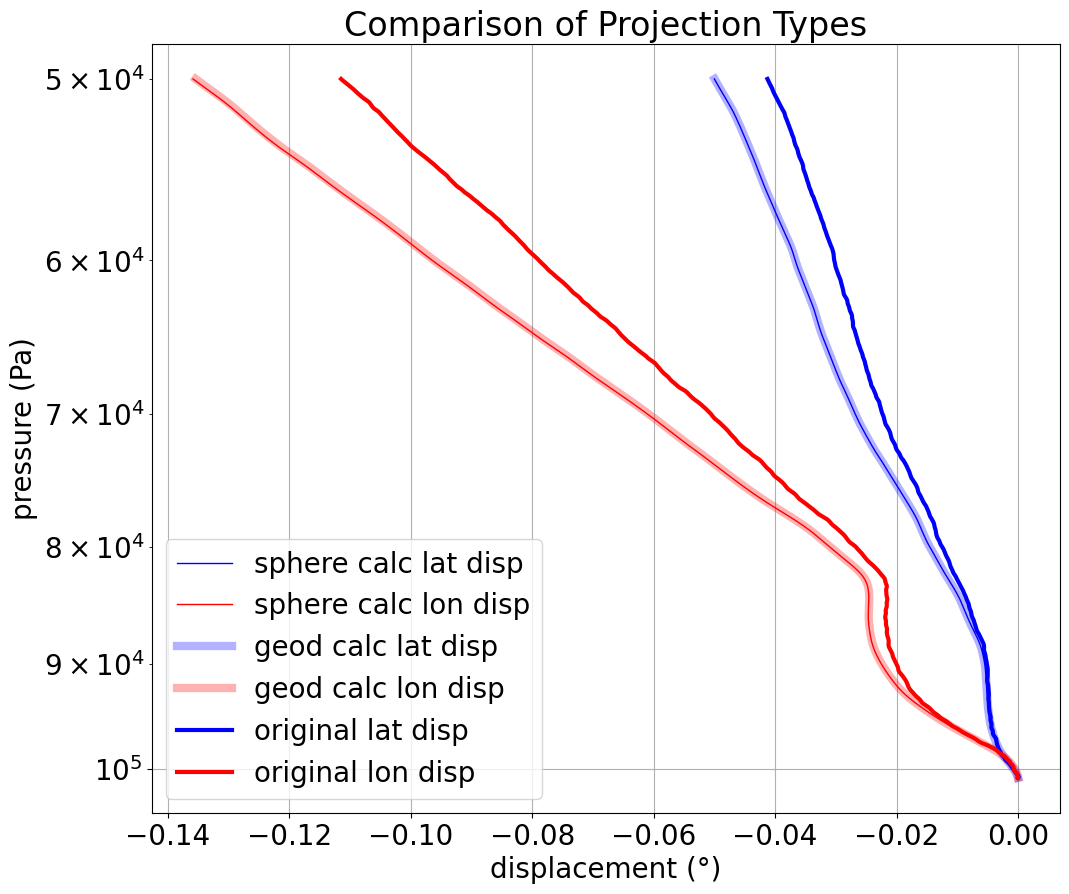

length of input data: 1440
significant levels: 10
lat:  48.24    lon:  11.55
date:  20200531.0    time:  224500.0


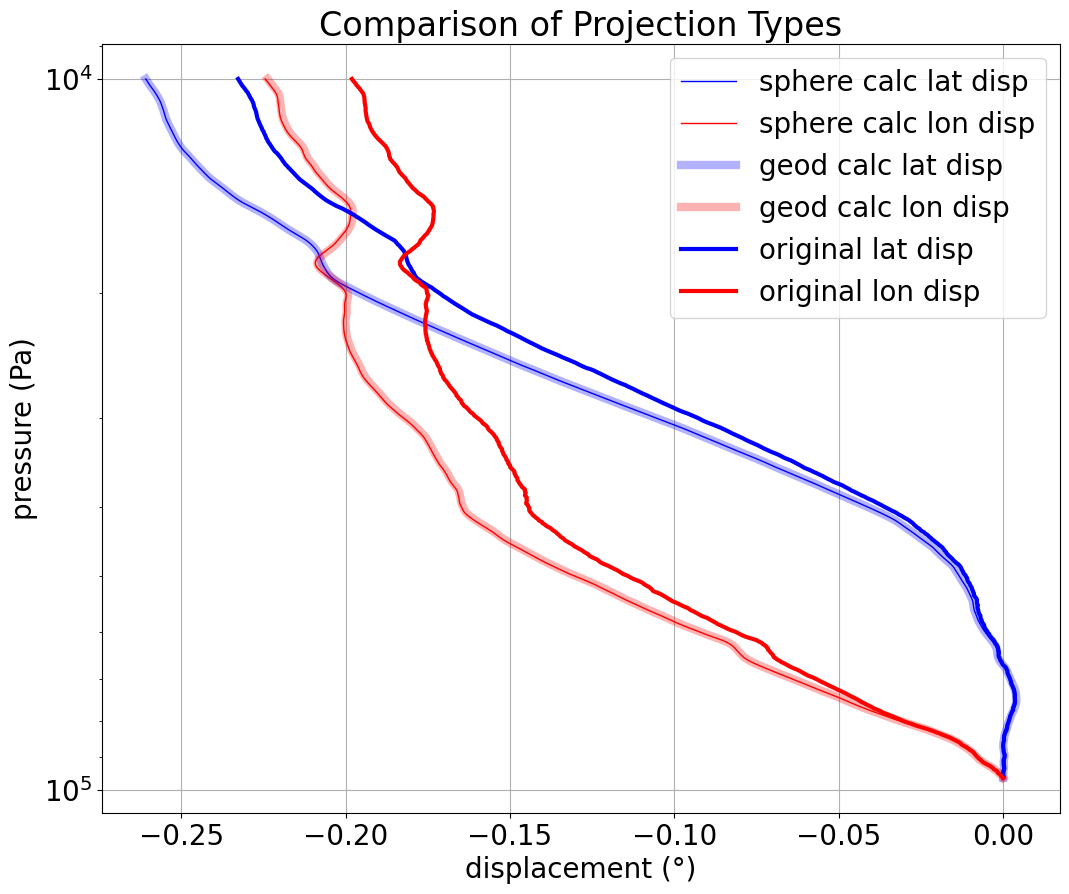

length of input data: 1744
significant levels: 11
lat:  51.410000000000004    lon:  6.970000000000001
date:  20200531.0    time:  224500.0


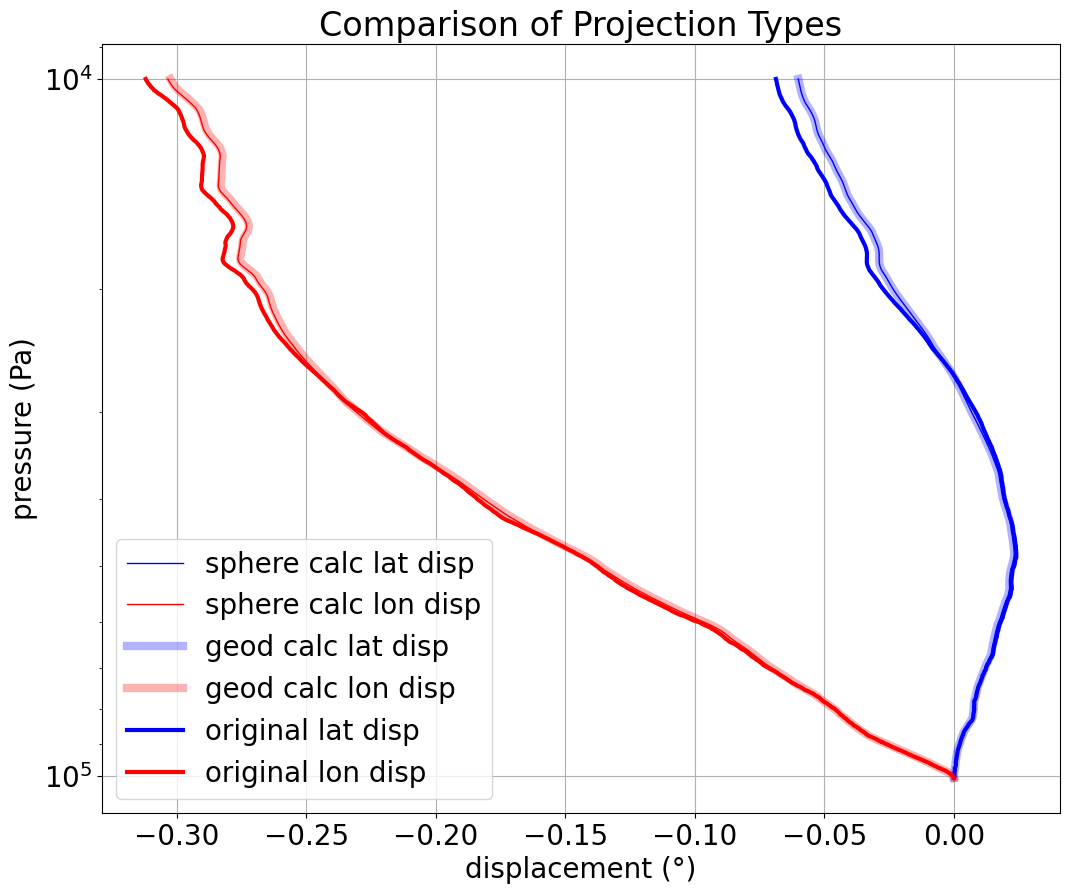

length of input data: 1332
significant levels: 13
lat:  49.45    lon:  17.130000000000003
date:  20200531.0    time:  231500.0


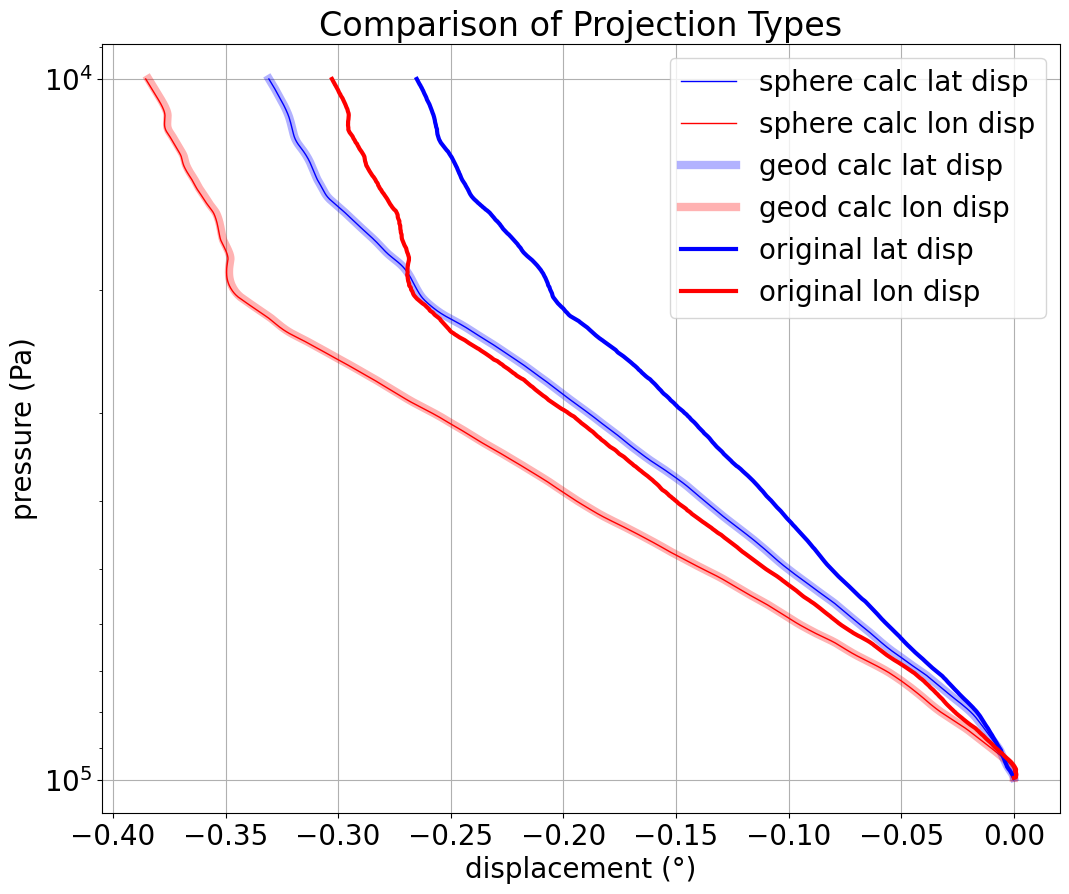

length of input data: 3357
significant levels: 8
lat:  36.25    lon:  -86.56
date:  20200531.0    time:  230000.0


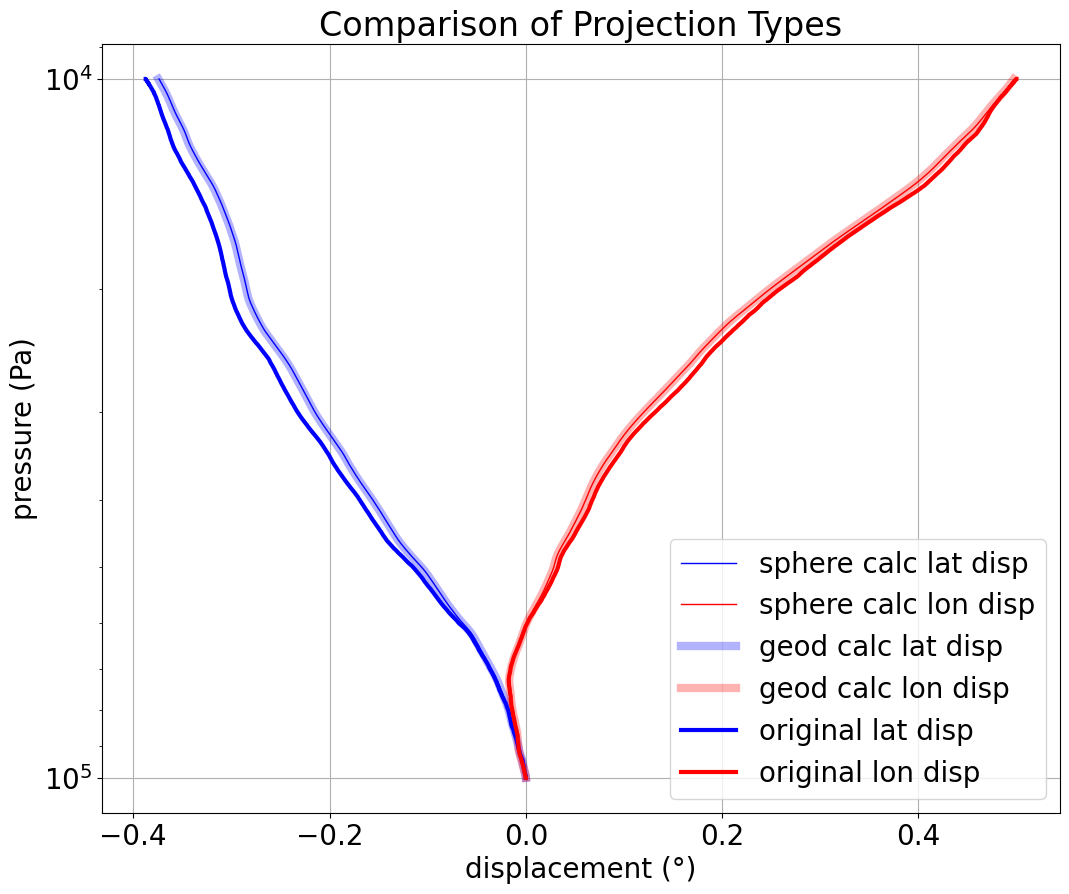

length of input data: 3330
significant levels: 7
lat:  40.77    lon:  -111.95
date:  20200531.0    time:  230300.0


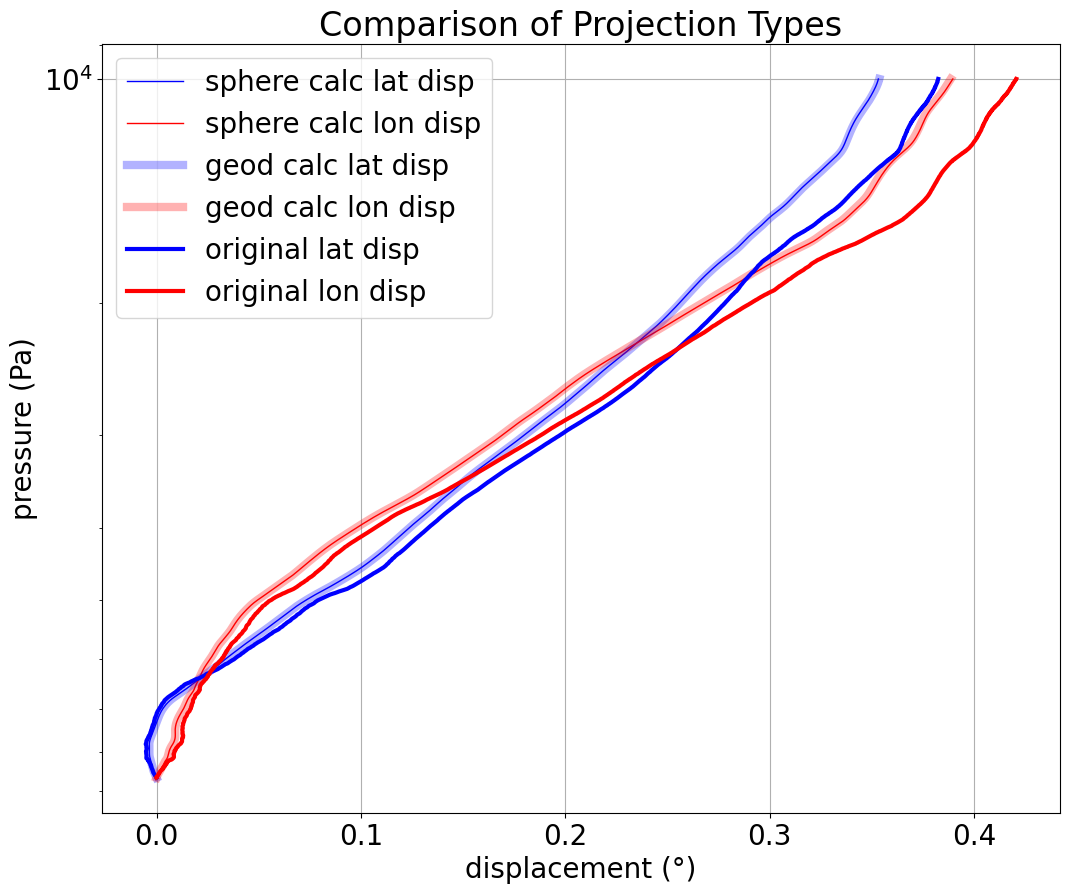

length of input data: 1727
significant levels: 11
lat:  -66.28    lon:  110.52000000000001
date:  20200531.0    time:  231500.0


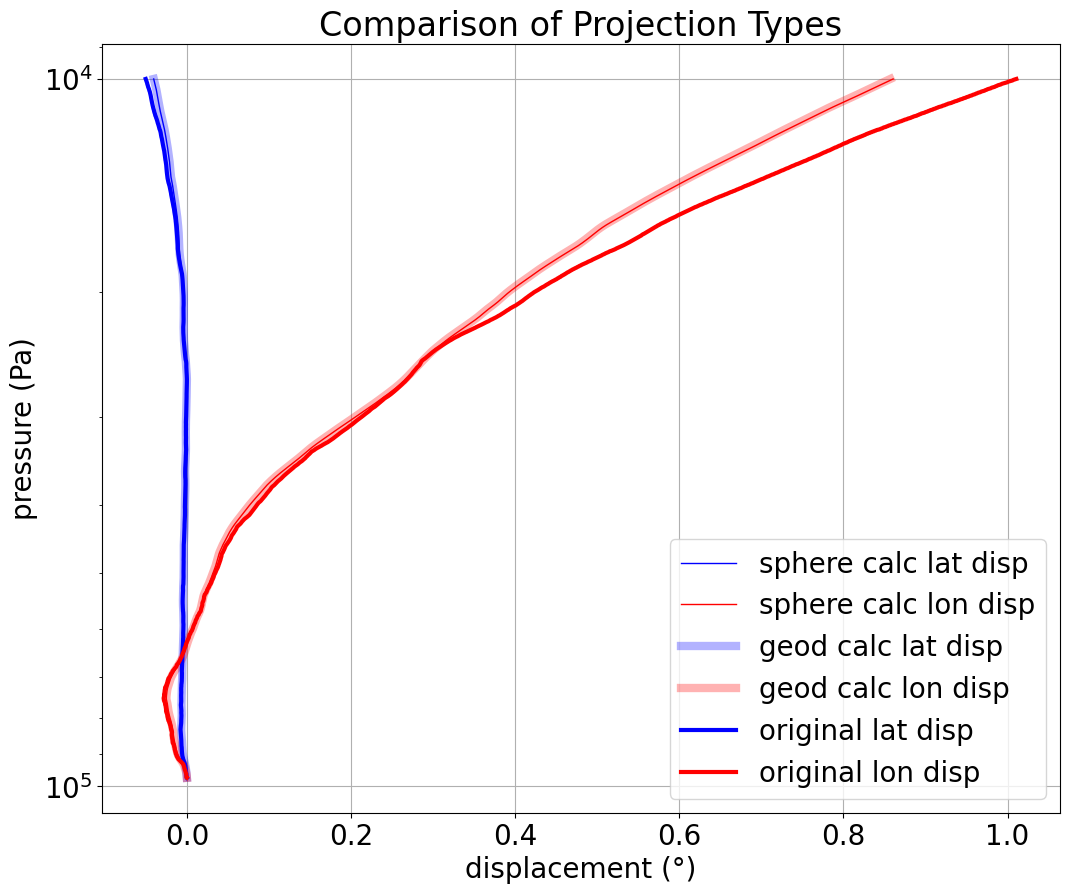

length of input data: 2589
significant levels: 15
lat:  33.45    lon:  135.76000000000002
date:  20200531.0    time:  233200.0


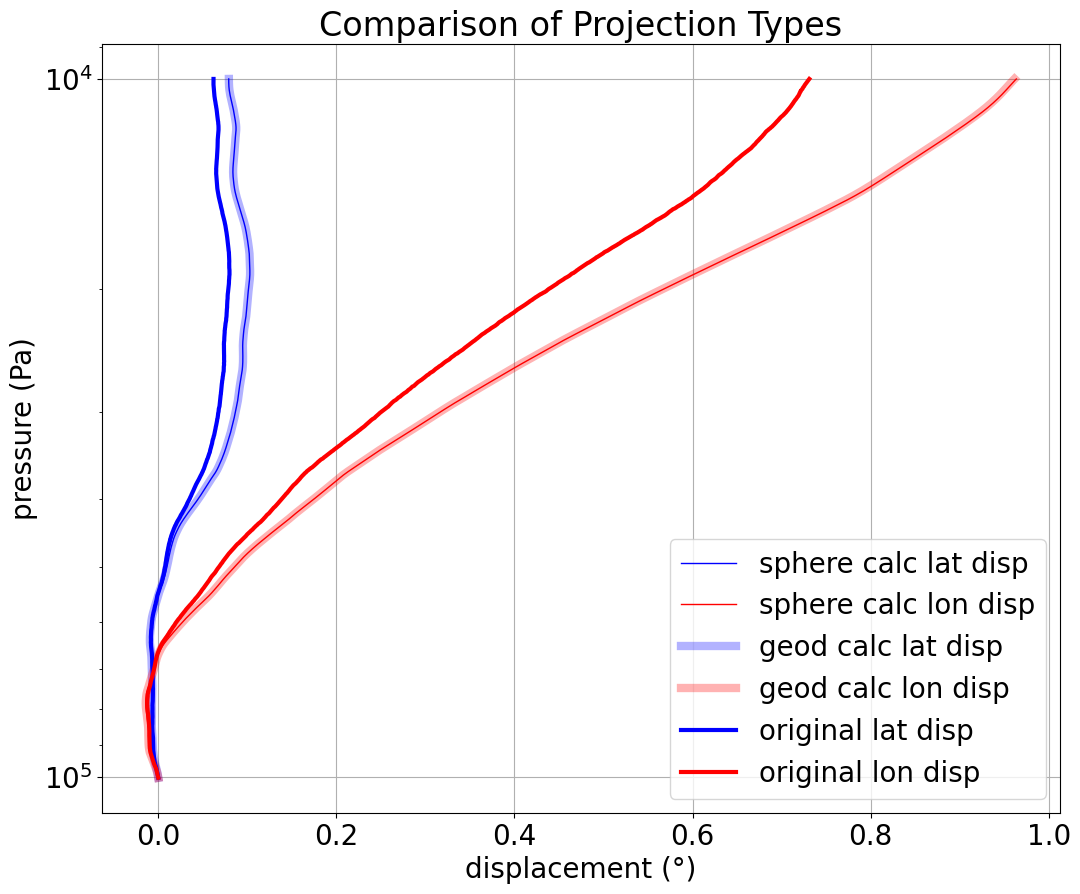

length of input data: 3599
significant levels: 11
lat:  30.450000000000003    lon:  -84.30000000000001
date:  20200531.0    time:  231900.0


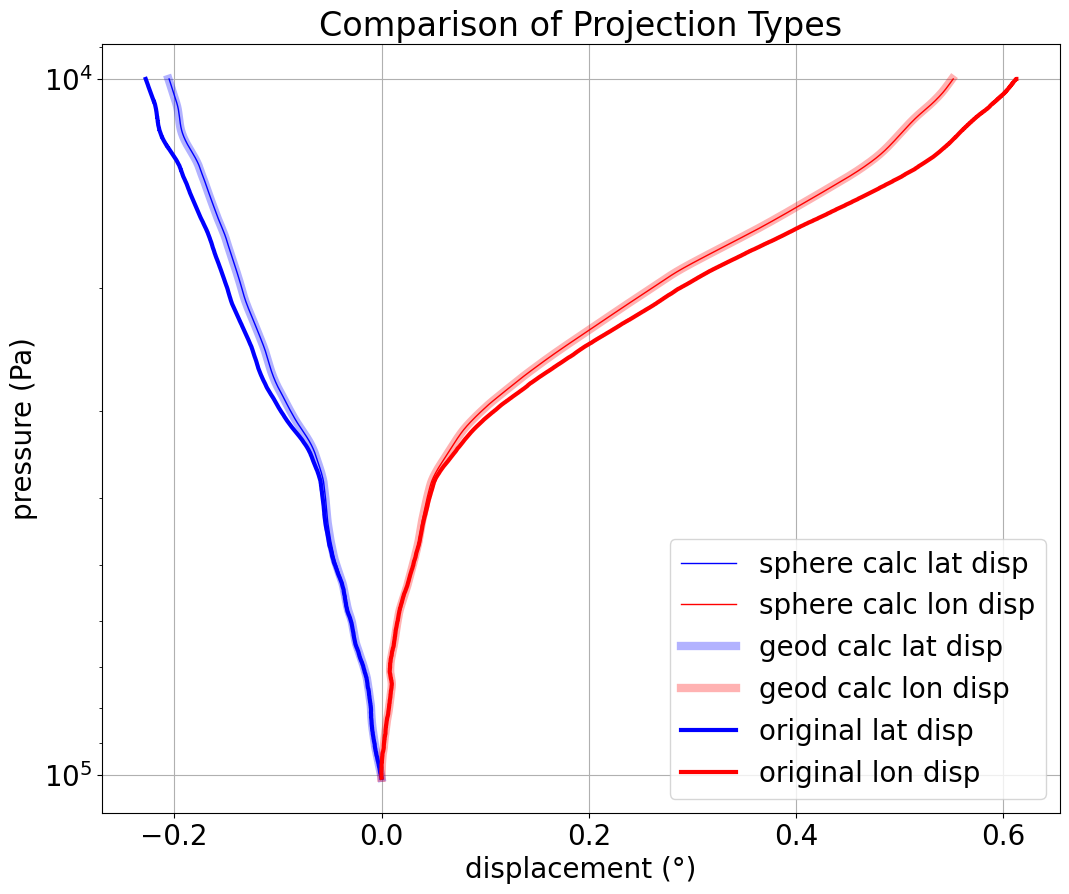

length of input data: 5234
significant levels: 25
lat:  25.92    lon:  -97.42
date:  20200531.0    time:  230400.0


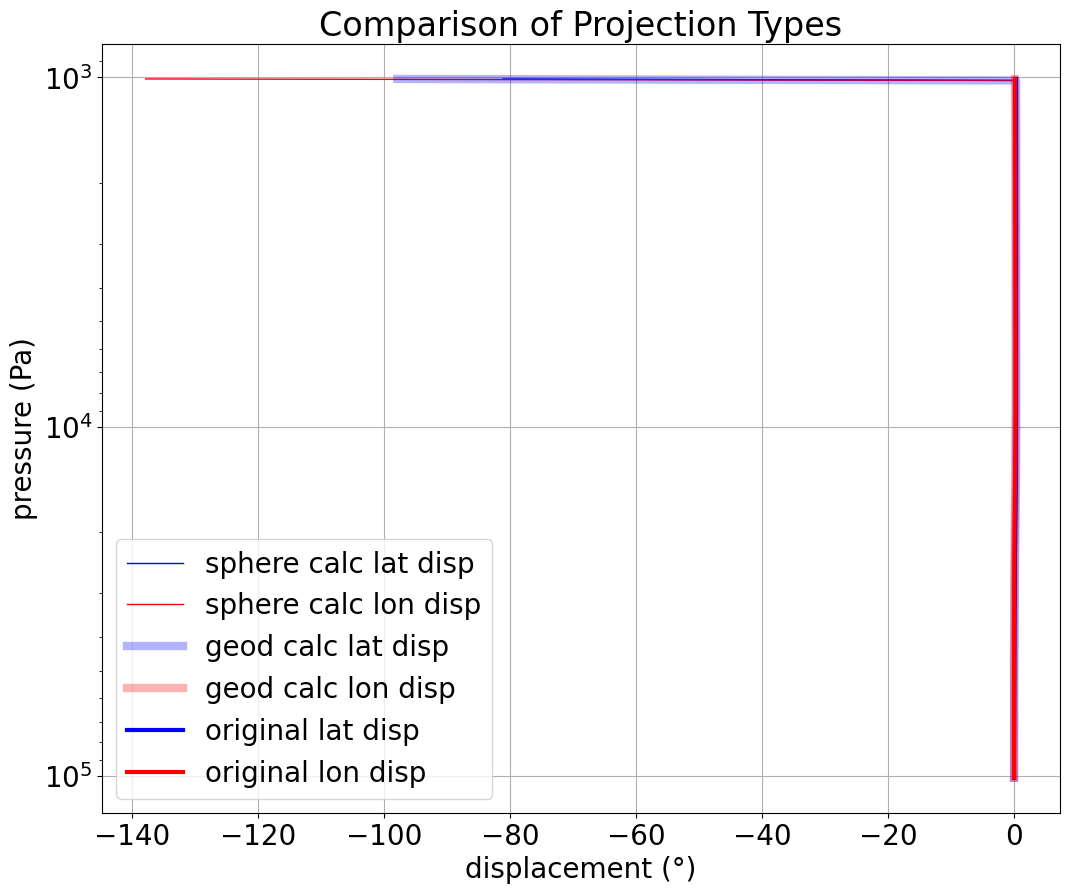

length of input data: 2409
significant levels: 21
lat:  53.010000000000005    lon:  -1.25
date:  20200531.0    time:  231500.0


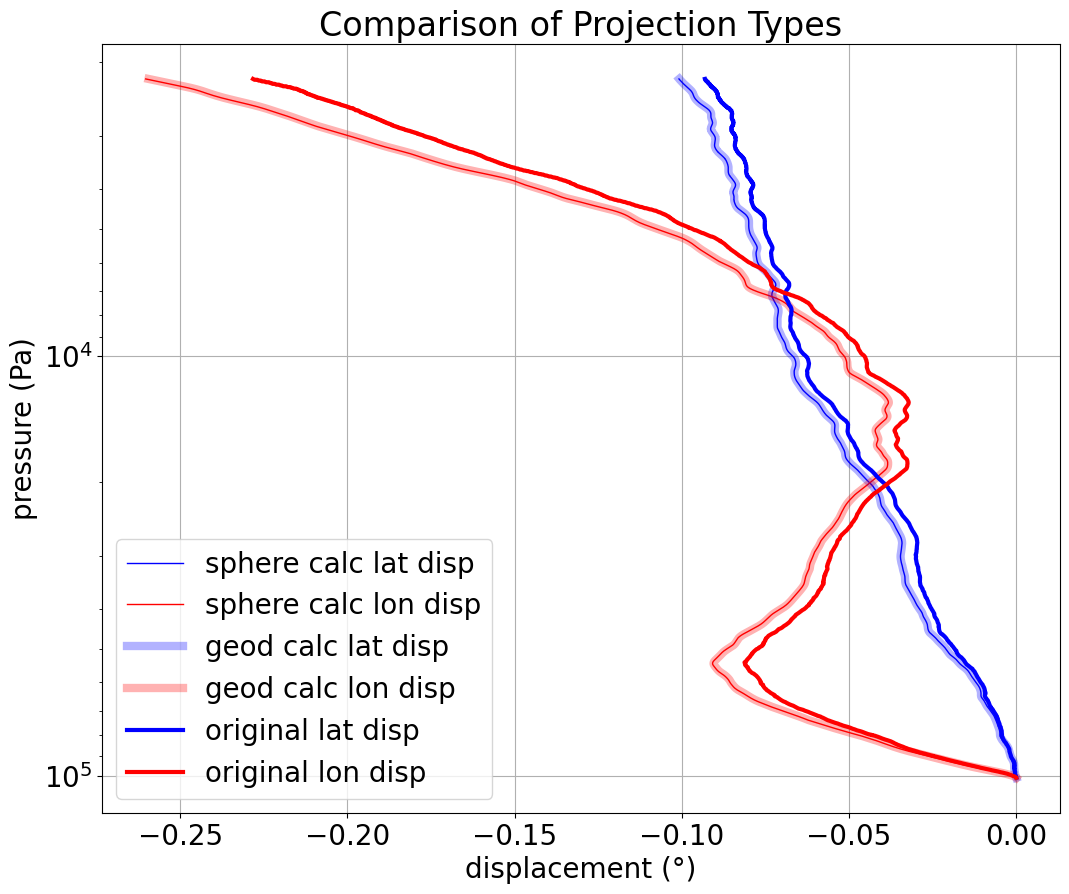

length of input data: 2160
significant levels: 13
lat:  49.690000000000005    lon:  7.330000000000001
date:  20200531.0    time:  224500.0


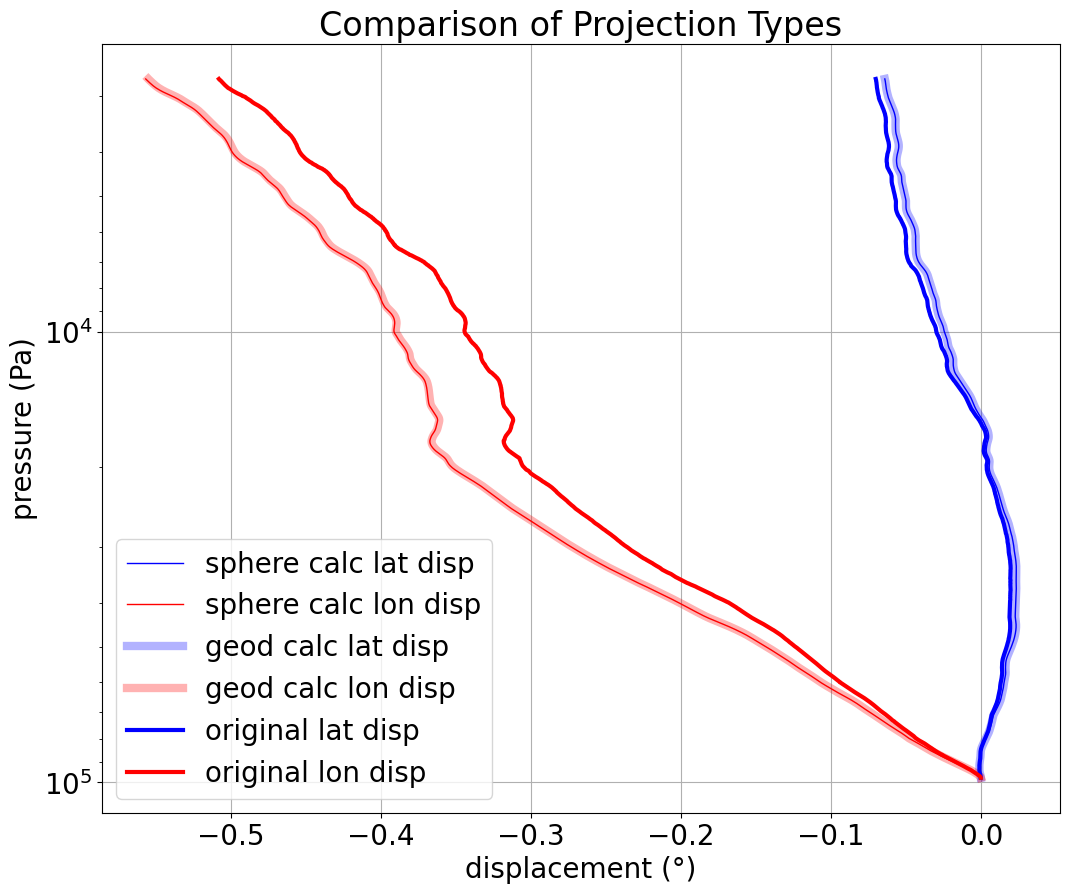

length of input data: 6097
significant levels: 37
lat:  36.25    lon:  -86.56
date:  20200531.0    time:  230000.0


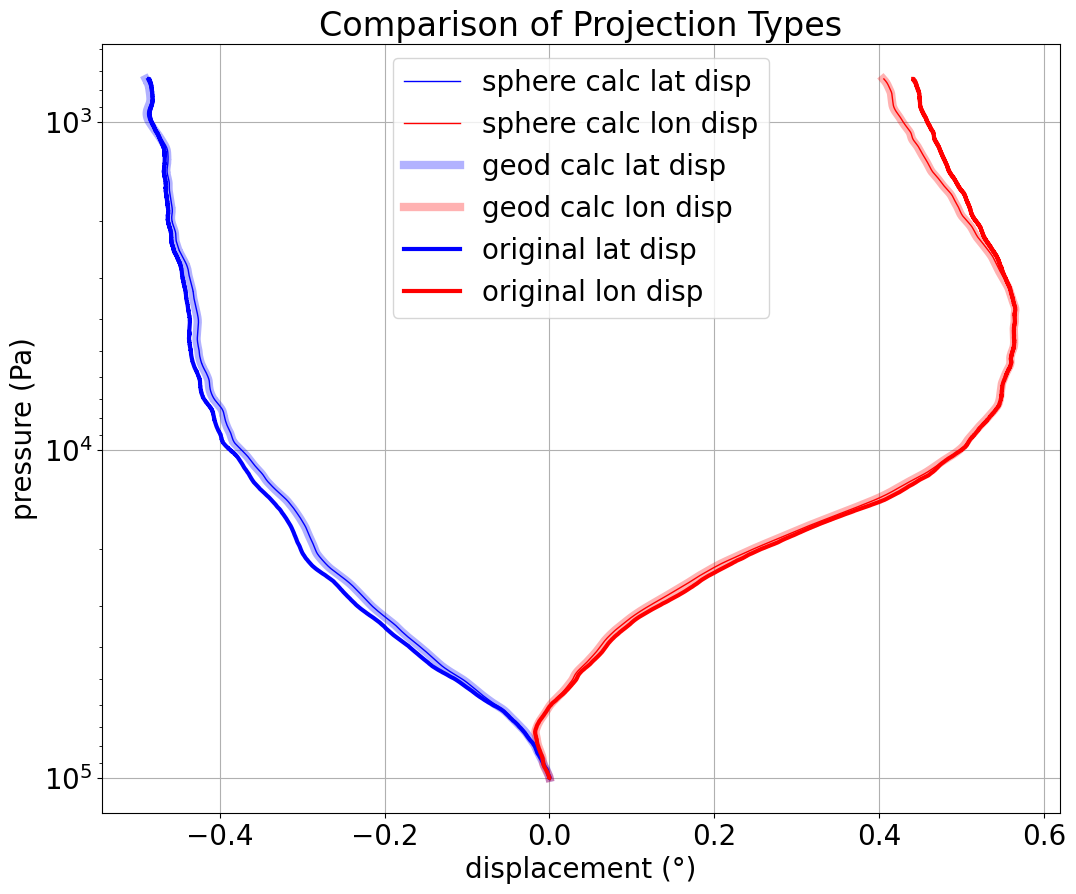

length of input data: 6372
significant levels: 46
lat:  57.150000000000006    lon:  -170.22000000000003
date:  20200531.0    time:  230100.0


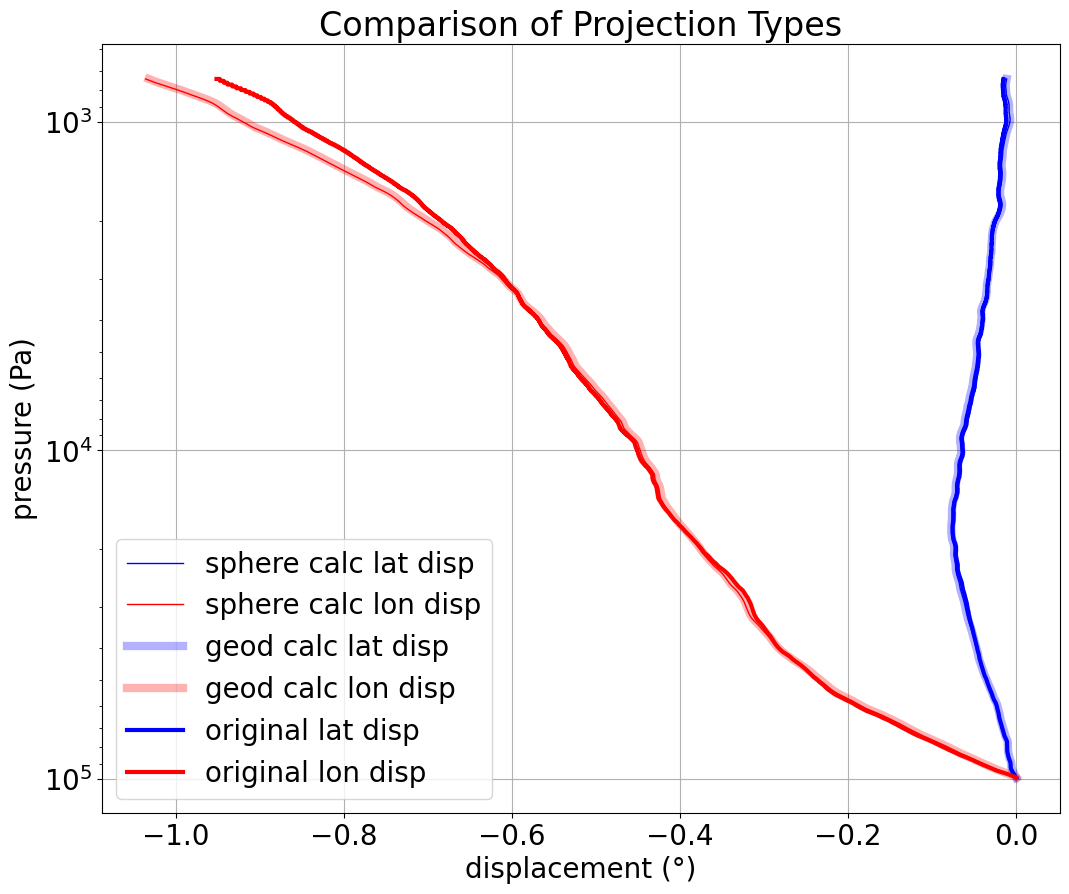

length of input data: 6156
significant levels: 32
lat:  33.36    lon:  -84.57000000000001
date:  20200531.0    time:  231400.0


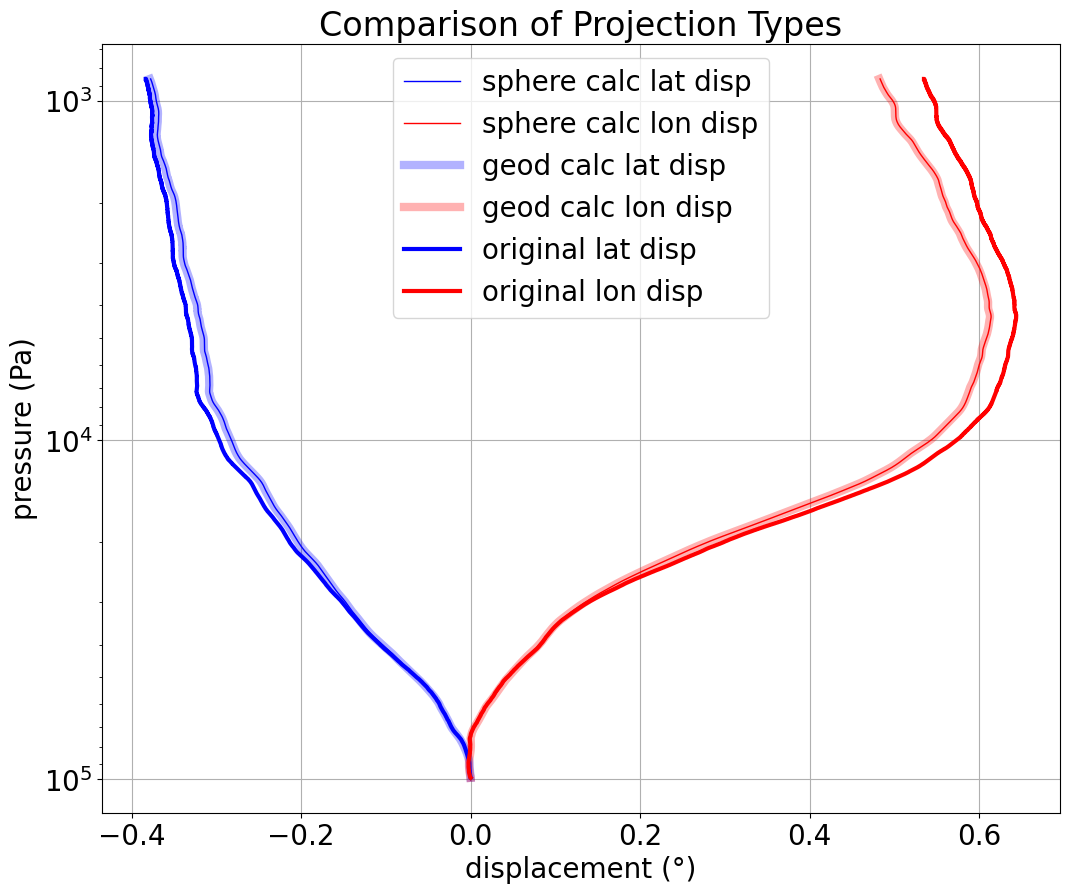

length of input data: 5978
significant levels: 33
lat:  32.45    lon:  -93.84
date:  20200531.0    time:  231600.0


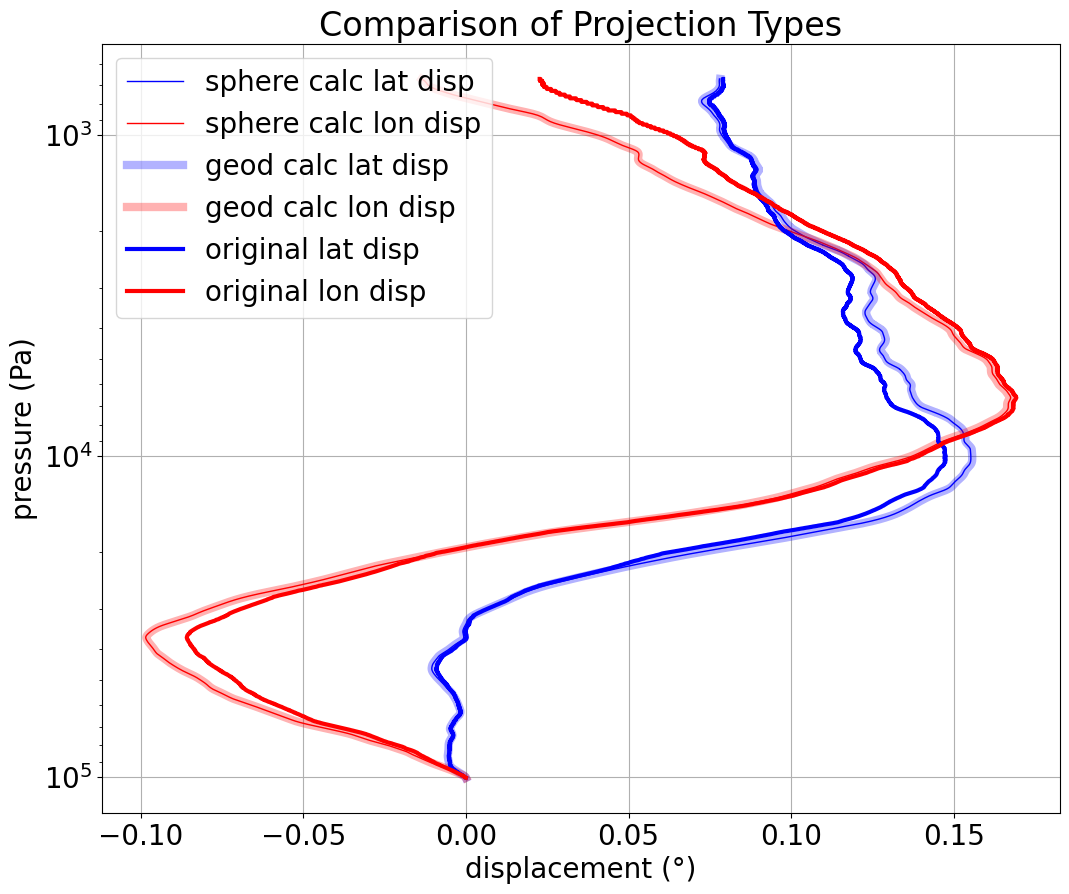

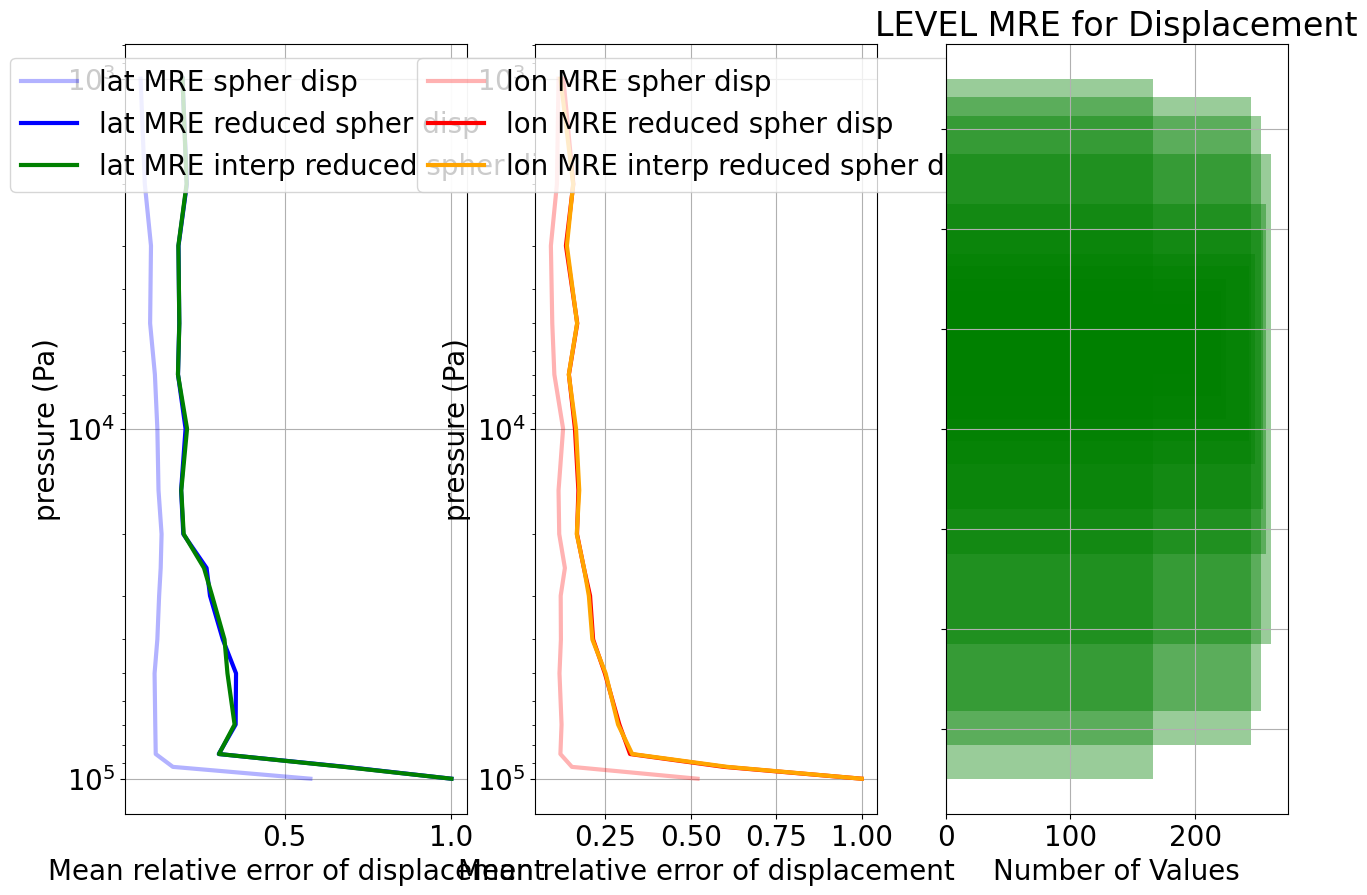

In [70]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])


# Comparison calc - original

In [67]:
def par_read_bufr_stn_nofeedback_mre_interp(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    plev_vals = {}    
    rmse_sum_lon_s={}
    rmse_sum_lat_s={}
    rmse_sum_lon_sr={}
    rmse_sum_lat_sr={}
    rmse_sum_lon_sri={}
    rmse_sum_lat_sri={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        plev_vals[i] = []
        rmse_sum_lon_s[i] = []
        rmse_sum_lat_s[i] = []
        rmse_sum_lon_sr[i] = []
        rmse_sum_lat_sr[i] = []
        rmse_sum_lon_sri[i] = []
        rmse_sum_lat_sri[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        try:
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        if cont:
            # try:
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]

            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

            reduced_out = out[np.isin(out.pressure, stdplevs)]
            if len(reduced_out) < 5:
                continue
                
            if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001) or (np.max(np.abs(out.latitudeDisplacement)) > 10):
                continue
            
            if (len(out) < 0) or (len(reduced_out) < 3):
                continue
                
            num_p = 20
            p_list = np.linspace(out.pressure.iloc[0], out.pressure.iloc[-1], num=num_p)
            true_p_list = list(reduced_out.pressure)
            for i in p_list:
                true_p_list.append(find_nearest(out.pressure, i))
            interpolated_reduced_out = out[np.isin(out.pressure, true_p_list)]
            # display(interpolated_reduced_out)
            # display(reduced_out)
            u_new = []
            v_new = []
            # print(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))
            # print((np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))))
            
            # u_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
            # v_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
            
            for k in range(len(interpolated_reduced_out)):
                if reduced_out.pressure.iloc[0] >= interpolated_reduced_out.pressure.iloc[k] >= reduced_out.pressure.iloc[-1]:
                    u_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
                    v_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
                else:
                    u_new.append(np.nan)
                    v_new.append(np.nan)

            u = np.array(u_new)
            v = np.array(v_new)
            interpolated_reduced_out['ip_u'] = u
            interpolated_reduced_out['ip_v'] = v
            interpolated_reduced_out = interpolated_reduced_out.dropna(subset=['ip_u', 'ip_v'])
                
            reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(interpolated_reduced_out.airTemperature), u=np.array(interpolated_reduced_out.ip_u), v=np.array(interpolated_reduced_out.ip_v),
                pressure=np.array(interpolated_reduced_out.pressure),
                )
            
            # print(reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp)

            sph_lat_disp, sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                )

            

            for i in stdplevs:
                try:
                    rmse_sum_lon_s[i].append(
                        float(np.abs(np.array(sph_lon_disp)[out.pressure == i] - 
                              out[out.pressure == i].longitudeDisplacement.values)
                        / (np.abs(out[out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_s[i].append(
                        float(np.abs(np.array(sph_lat_disp)[out.pressure == i] - 
                              out[out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(out[out.pressure == i].latitudeDisplacement.values))
                    ))
                    plev_vals[i].append(1)
                except:
                    rmse_sum_lon_s[i].append(np.nan)
                    rmse_sum_lat_s[i].append(np.nan)
                    plev_vals[i].append(0)
                    
            if (pltcount % 20) == 0:
                print('length of input data:',len(out))
                print('significant levels:',len(reduced_out))
                print('lat: ',out.lat.iloc[0], '   lon: ', out.lon.iloc[0])
                print('date: ', out.datum.iloc[0], '   time: ', out.timePeriod.iloc[0])
                # display(interpolated_reduced_out)
                fig, ax1 = maplt.subplots(figsize=(15, 9))
                ax1.set_yscale('log')

                ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 0.3, label='calc lat disp')
                ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 0.3, label='calc lon disp')

                ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue', label='original lat disp')
                ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red', label='original lon disp')

                ax1.set_ylabel('pressure (Pa)')
                ax1.set_xlabel('displacement (°)')
                ax1.tick_params(axis='x')
                ax1.set_ylim(ax1.get_ylim()[::-1])
                ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

                # ax1_2 = ax1.twiny()
                # ax1_2.set_yscale('log')
                # ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.3, label='u')
                # ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.3, label='v')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('Comparison of Displacements')
                maplt.legend()
                # maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
                maplt.grid()
                maplt.show()
                maplt.close()
            pltcount += 1
            
            # except: 
            #     pass
            # break
            if pltcount > 200:
                break
    
    limit = [5,95]
    for i in stdplevs:
        
        rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
        rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
    
    rmse_lat_s = []
    rmse_lon_s = []
    for i in stdplevs:
        
        rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
        rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
    
    fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
    ax1[0].set_yscale('log')
    ax1[1].set_yscale('log')
    ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat MRE spher disp')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('Mean relative error of displacement')
    ax1[0].legend(loc='upper center')
    ax1[0].grid()
    
    
    ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon MRE spher disp')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('Mean relative error of displacement')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
    
    value_nr = []
    for i in plev_vals:
        value_nr.append(np.sum(plev_vals[i]))
    ax1[2].barh(stdplevs, value_nr, np.array(stdplevs)*7, color='g', alpha = 0.4, align='center')
    ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
    ax1[2].set_xlabel('Number of Values')
    ax1[2].tick_params(labelleft=False)
    ax1[2].grid()
    
    maplt.title('LEVEL MRE for Displacement')
    maplt.show()
    maplt.close()
    
    return out

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>
length of input data: 931
significant levels: 5
lat:  52.21    lon:  14.120000000000001
date:  20200531.0    time:  224500.0


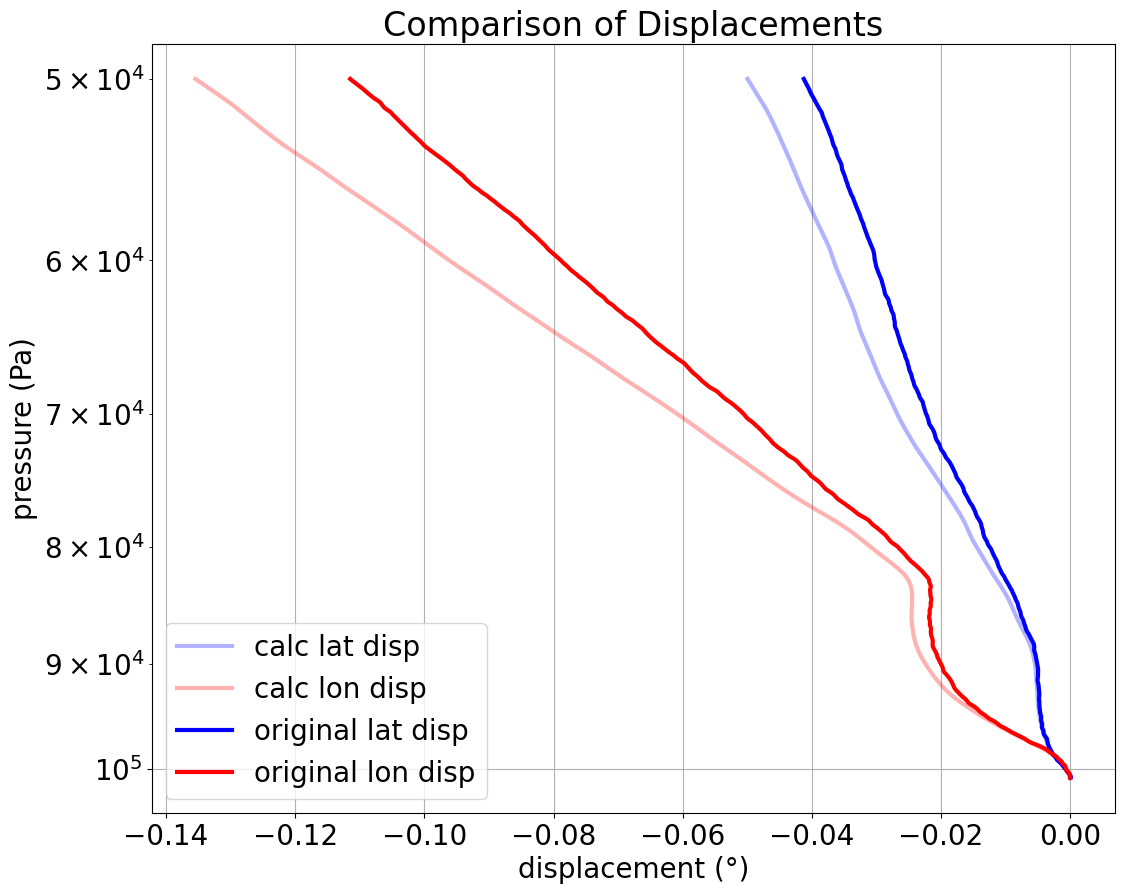

length of input data: 1440
significant levels: 10
lat:  48.24    lon:  11.55
date:  20200531.0    time:  224500.0


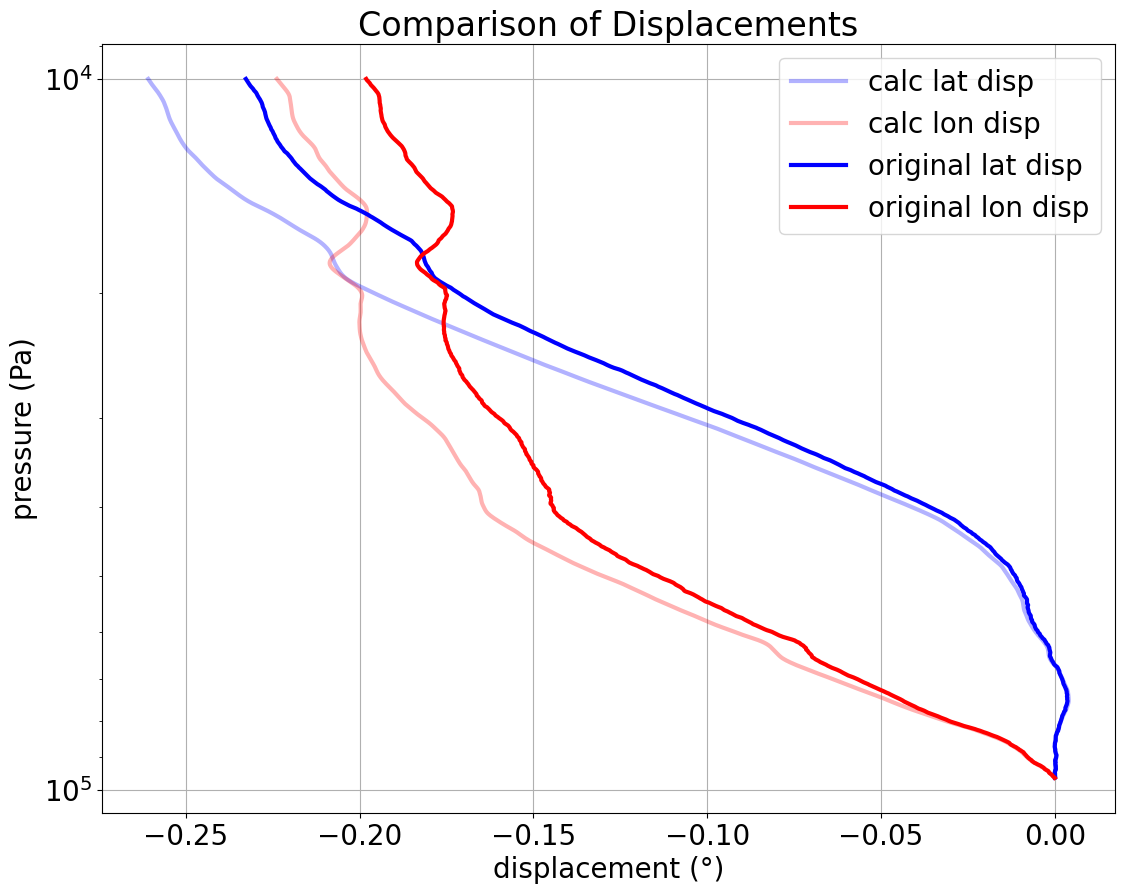

length of input data: 1744
significant levels: 11
lat:  51.410000000000004    lon:  6.970000000000001
date:  20200531.0    time:  224500.0


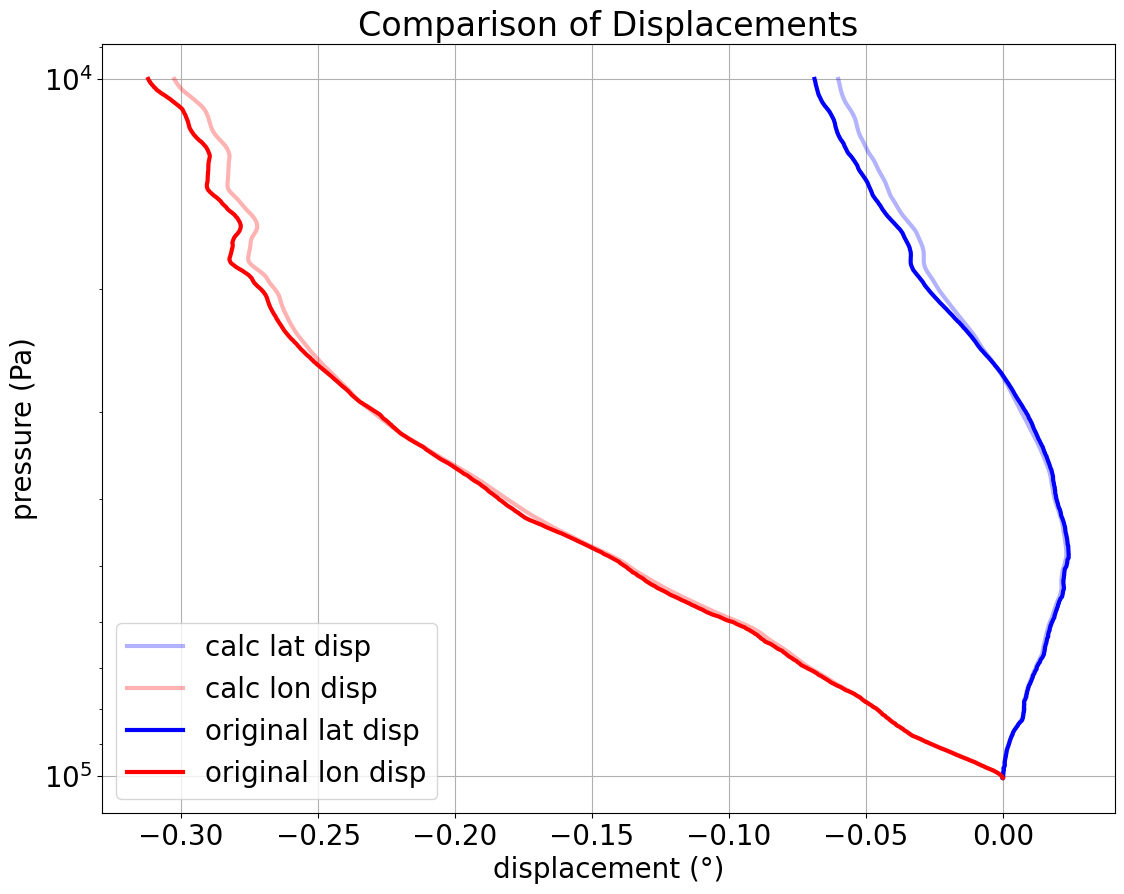

length of input data: 1332
significant levels: 13
lat:  49.45    lon:  17.130000000000003
date:  20200531.0    time:  231500.0


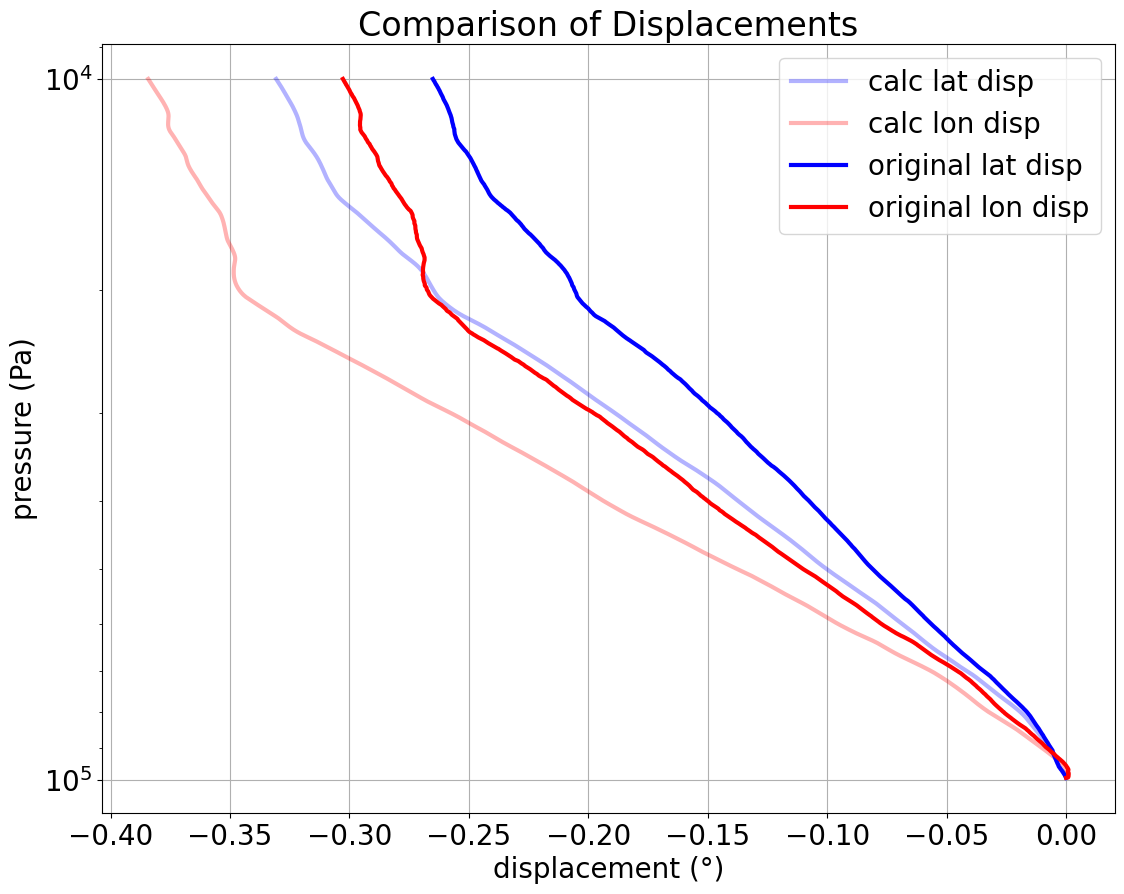

length of input data: 3357
significant levels: 8
lat:  36.25    lon:  -86.56
date:  20200531.0    time:  230000.0


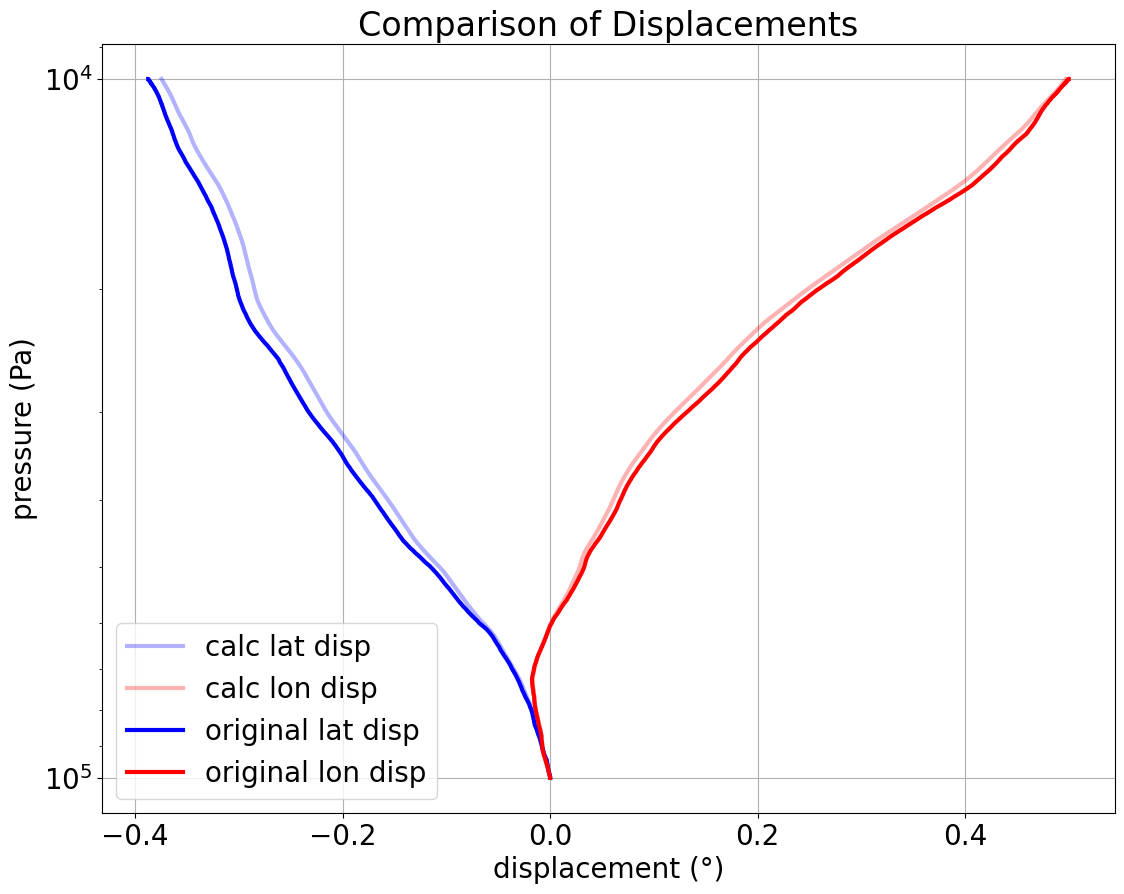

length of input data: 3330
significant levels: 7
lat:  40.77    lon:  -111.95
date:  20200531.0    time:  230300.0


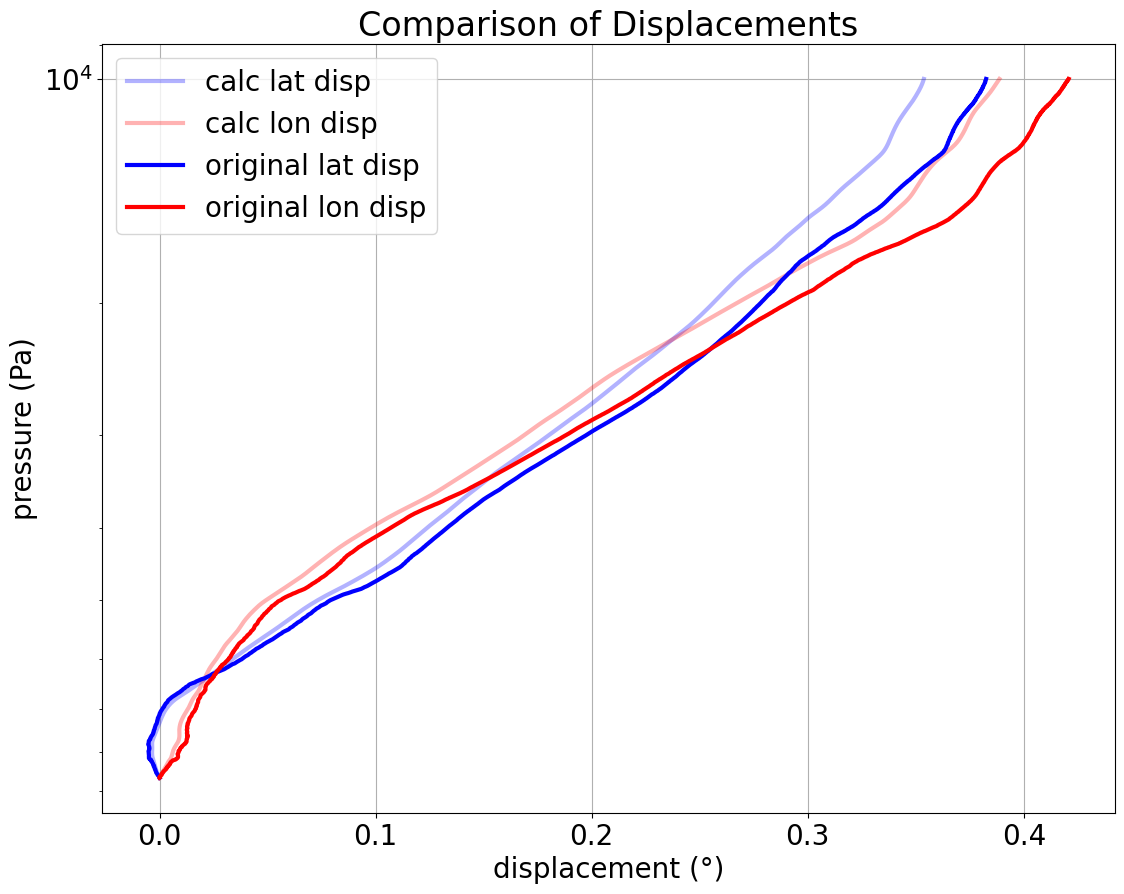

length of input data: 1727
significant levels: 11
lat:  -66.28    lon:  110.52000000000001
date:  20200531.0    time:  231500.0


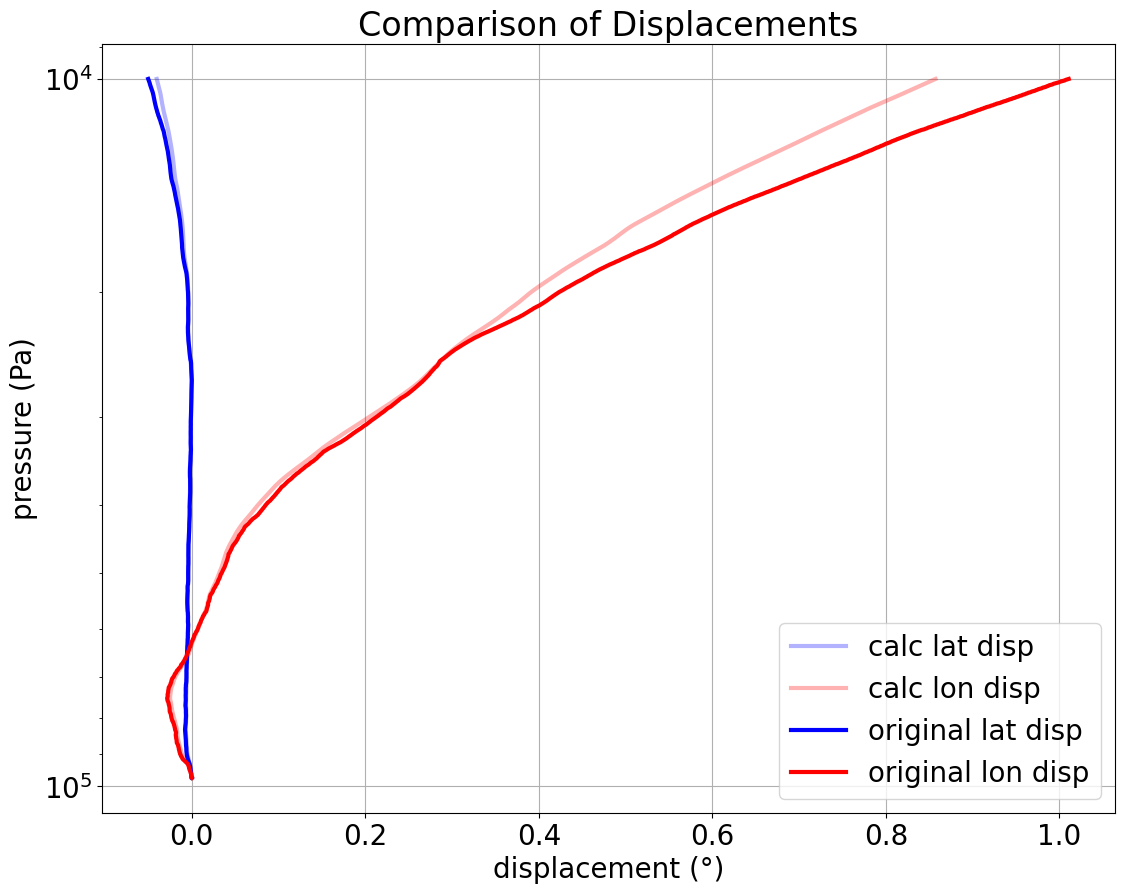

length of input data: 2589
significant levels: 15
lat:  33.45    lon:  135.76000000000002
date:  20200531.0    time:  233200.0


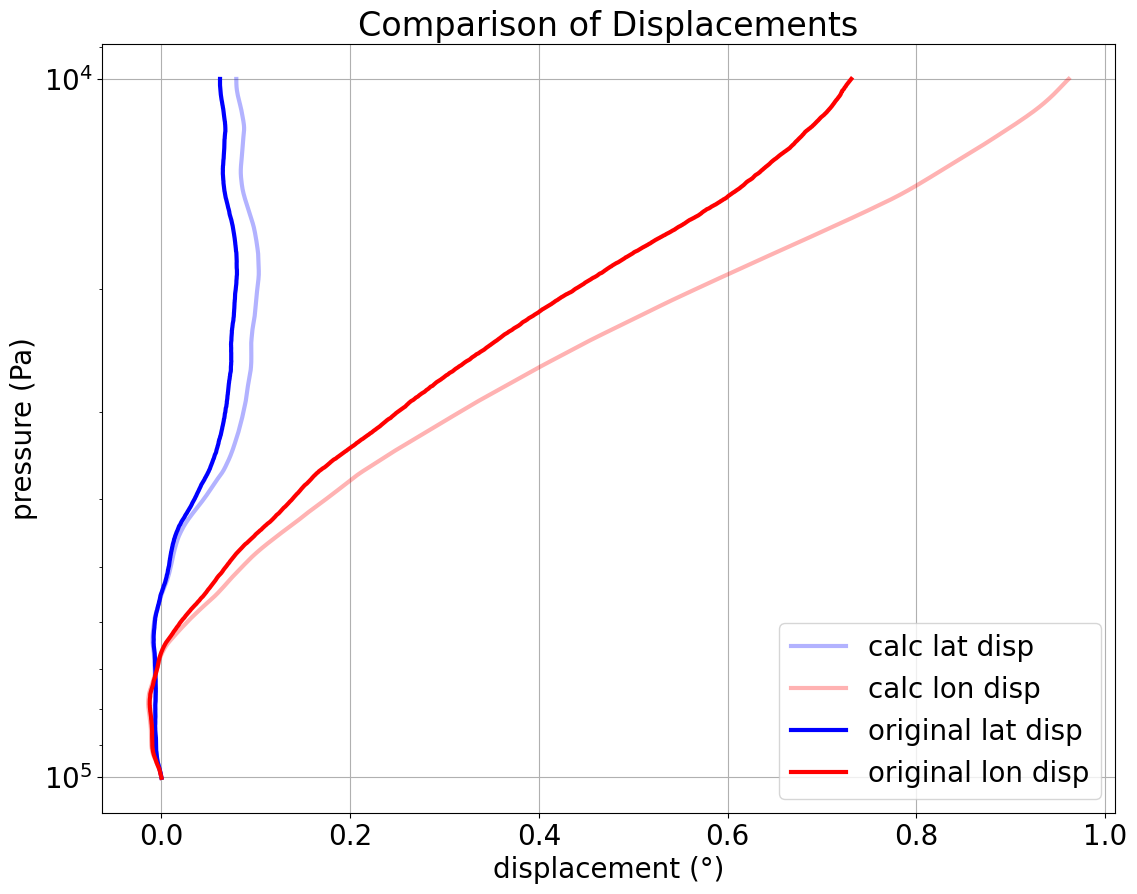

length of input data: 3599
significant levels: 11
lat:  30.450000000000003    lon:  -84.30000000000001
date:  20200531.0    time:  231900.0


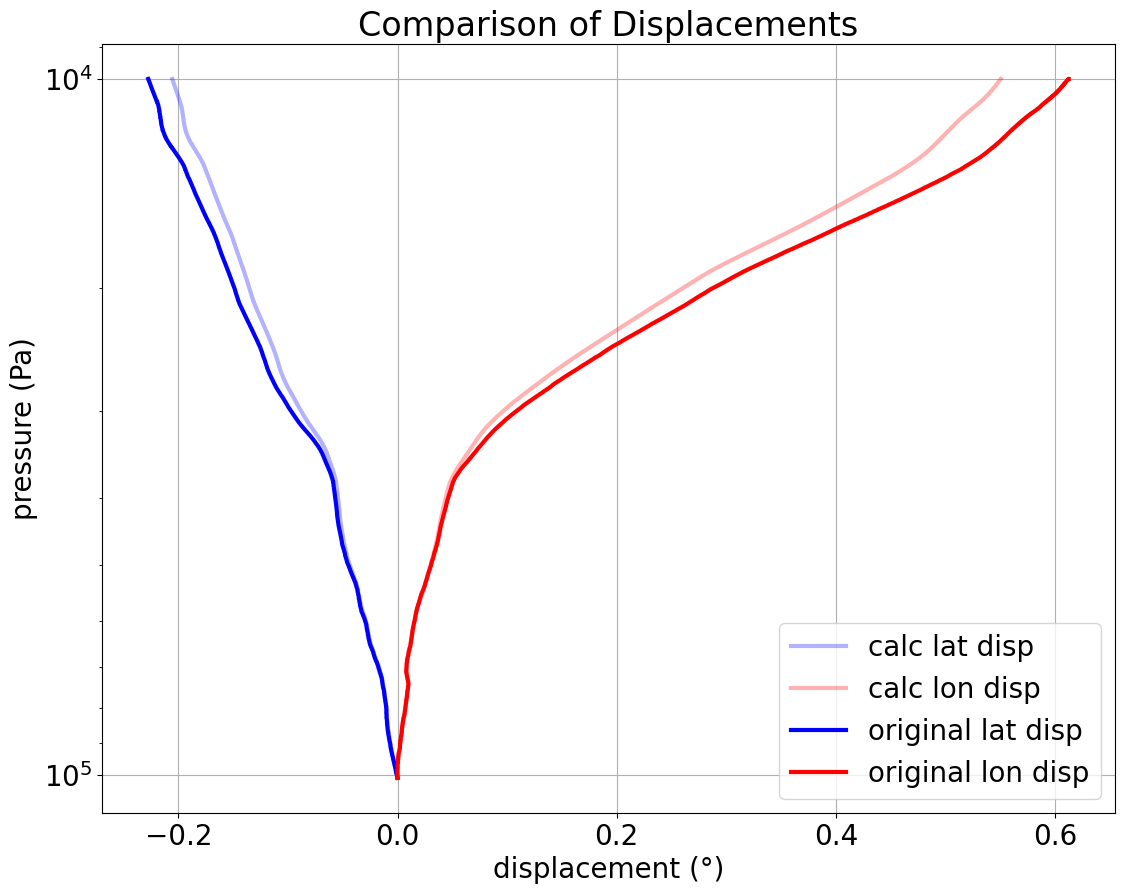

length of input data: 5234
significant levels: 25
lat:  25.92    lon:  -97.42
date:  20200531.0    time:  230400.0


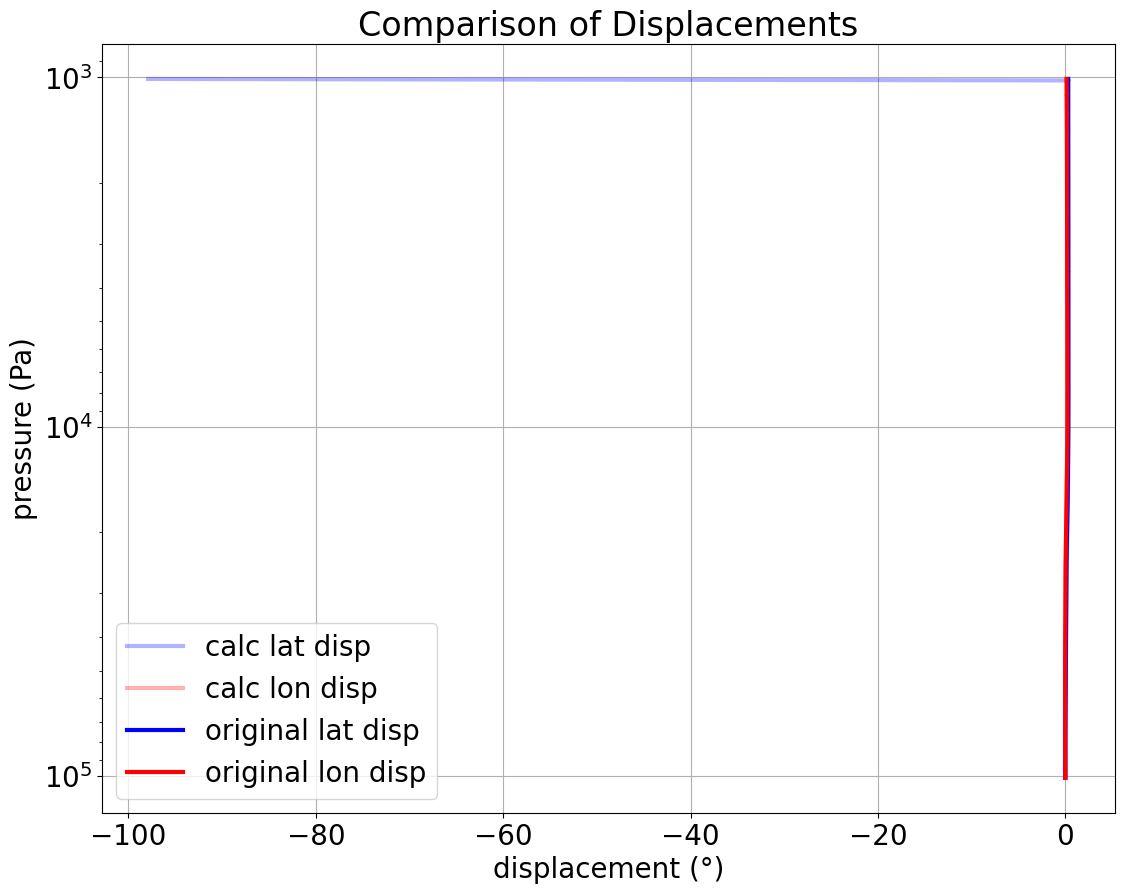

length of input data: 2409
significant levels: 21
lat:  53.010000000000005    lon:  -1.25
date:  20200531.0    time:  231500.0


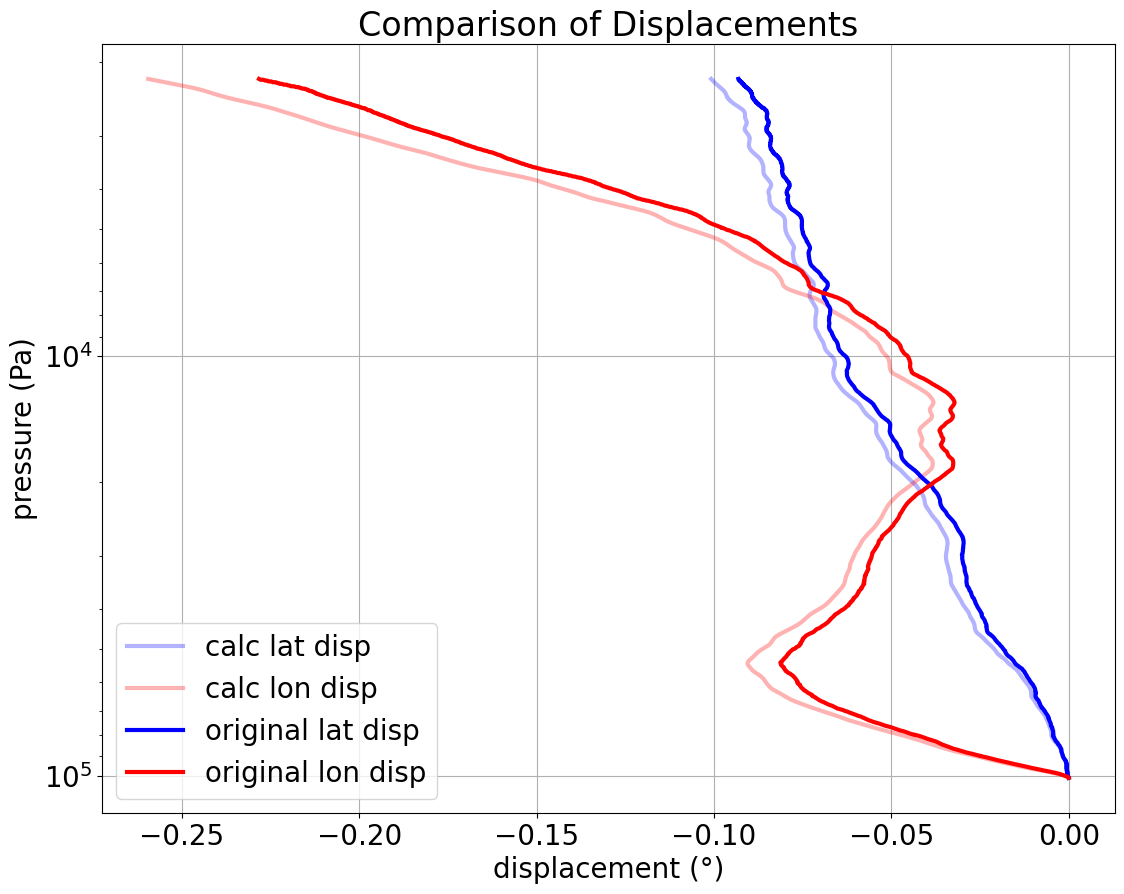

NameError: name 'rmse_lat_sr' is not defined

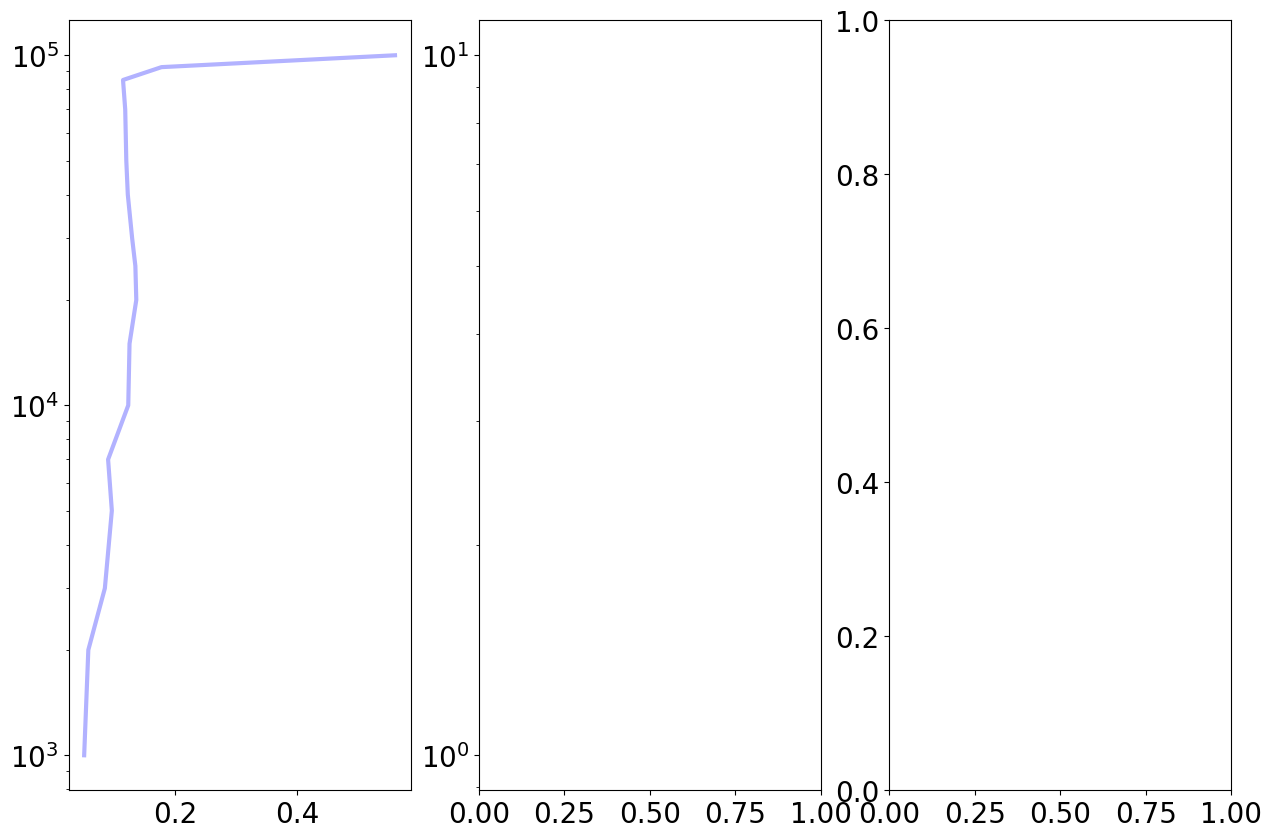

In [68]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])


In [66]:
%debug

> /tmp/ipykernel_1971821/2082901919.py(243)par_read_bufr_stn_nofeedback_mre_interp()
    241 
    242         outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
--> 243         rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
    244         rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
    245 



ipdb>  rmse_sum_lat_sr[i]


array([], dtype=float64)


ipdb>  exit


In [46]:
def par_read_bufr_stn_nofeedback_mre_interp(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    plev_vals = {}    
    rmse_sum_lon_s={}
    rmse_sum_lat_s={}
    rmse_sum_lon_sr={}
    rmse_sum_lat_sr={}
    rmse_sum_lon_sri={}
    rmse_sum_lat_sri={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        plev_vals[i] = []
        rmse_sum_lon_s[i] = []
        rmse_sum_lat_s[i] = []
        rmse_sum_lon_sr[i] = []
        rmse_sum_lat_sr[i] = []
        rmse_sum_lon_sri[i] = []
        rmse_sum_lat_sri[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        try:
            output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
    #             if str(output['datum'])[4:6] != '12':
    #                 codes_release(bufr)
    #                 continue
            output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
            output['pressure'] = codes_get_array(bufr, "pressure")
            output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
            output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
            output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
            output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
            output['airTemperature'] = codes_get_array(bufr, "airTemperature")
            dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
            output['windDirection'] = codes_get_array(bufr, "windDirection")
            output['windSpeed'] = codes_get_array(bufr, "windSpeed")
            output['lat'] = codes_get(bufr, "latitude")
            output['lon'] = codes_get(bufr, "longitude")
            output['alt'] = float(codes_get(bufr, "heightOfStation"))
            output['blockNumber'] = codes_get(bufr, "blockNumber")
            output['stationNumber'] = codes_get(bufr, "stationNumber")
        
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        if cont:
            # try:
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]

            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

            reduced_out = out[np.isin(out.pressure, stdplevs)]
            if len(reduced_out) < 5:
                continue
                
            if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001) or (np.max(np.abs(out.latitudeDisplacement)) > 10):
                continue
            
            if (len(out) < 0) or (len(reduced_out) < 3):
                continue
                
            num_p = 20
            p_list = np.linspace(out.pressure.iloc[0], out.pressure.iloc[-1], num=num_p)
            true_p_list = list(reduced_out.pressure)
            for i in p_list:
                true_p_list.append(find_nearest(out.pressure, i))
            interpolated_reduced_out = out[np.isin(out.pressure, true_p_list)]
            # display(interpolated_reduced_out)
            # display(reduced_out)
            u_new = []
            v_new = []
            # print(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))
            # print((np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))))
            
            # u_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
            # v_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
            
            for k in range(len(interpolated_reduced_out)):
                if reduced_out.pressure.iloc[0] >= interpolated_reduced_out.pressure.iloc[k] >= reduced_out.pressure.iloc[-1]:
                    u_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
                    v_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
                else:
                    u_new.append(np.nan)
                    v_new.append(np.nan)

            u = np.array(u_new)
            v = np.array(v_new)
            interpolated_reduced_out['ip_u'] = u
            interpolated_reduced_out['ip_v'] = v
            interpolated_reduced_out = interpolated_reduced_out.dropna(subset=['ip_u', 'ip_v'])
                
            reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(interpolated_reduced_out.airTemperature), u=np.array(interpolated_reduced_out.ip_u), v=np.array(interpolated_reduced_out.ip_v),
                pressure=np.array(interpolated_reduced_out.pressure),
                transport_type='sphere')
            
            # print(reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp)

            sph_lat_disp, sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                )

            reduced_sph_lat_disp, reduced_sph_lon_disp, reduced_sph_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                )

            ell_lat_disp, ell_lon_disp, ell_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                transport_type='geod')

            reduced_ell_lat_disp, reduced_ell_lon_disp, reduced_ell_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                transport_type='geod')
            

            for i in stdplevs:
                try:
                    rmse_sum_lon_s[i].append(
                        float(np.abs(np.array(sph_lon_disp)[out.pressure == i] - 
                              out[out.pressure == i].longitudeDisplacement.values)
                        / (np.abs(out[out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_s[i].append(
                        float(np.abs(np.array(sph_lat_disp)[out.pressure == i] - 
                              out[out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(out[out.pressure == i].latitudeDisplacement.values))
                    ))
                    rmse_sum_lon_sr[i].append(
                        float(np.abs(np.array(reduced_sph_lon_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].longitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_sr[i].append(
                        float(np.abs(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    ))
                    rmse_sum_lon_sri[i].append(
                        float(np.abs(np.array(reduced_interp_sph_lon_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].longitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
                    ))
                    rmse_sum_lat_sri[i].append(
                        float(np.abs(np.array(reduced_interp_sph_lat_disp)[interpolated_reduced_out.pressure == i] - 
                              interpolated_reduced_out[interpolated_reduced_out.pressure == i].latitudeDisplacement.values) 
                        / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
                    ))
                    plev_vals[i].append(1)
                except:
                    rmse_sum_lon_s[i].append(np.nan)
                    rmse_sum_lat_s[i].append(np.nan)
                    rmse_sum_lon_sr[i].append(np.nan)
                    rmse_sum_lat_sr[i].append(np.nan)
                    rmse_sum_lon_sri[i].append(np.nan)
                    rmse_sum_lat_sri[i].append(np.nan)
                    plev_vals[i].append(0)
                    
            if (pltcount % 20) == 0:
                print('length of input data:',len(out))
                print('significant levels:',len(reduced_out))
                print('lat: ',out.lat.iloc[0], '   lon: ', out.lon.iloc[0])
                print('date: ', out.datum.iloc[0], '   time: ', out.timePeriod.iloc[0])
                # display(interpolated_reduced_out)
                fig, ax1 = maplt.subplots(figsize=(15, 9))
                ax1.set_yscale('log')
                # ax1.plot(np.array(reduced_interp_sph_lat_disp), interpolated_reduced_out.pressure, color = 'green', alpha = 1, linewidth= 1, label='ri sphere calc lat disp')
                # ax1.plot(np.array(reduced_interp_sph_lon_disp), interpolated_reduced_out.pressure, color = 'brown', alpha = 1, linewidth= 1, label='ri sphere calc lon disp')

                ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, label='calc lat disp')
                ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, label='calc lon disp')

                # ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
                # ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

                ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 1, label='mandatory plevs calc lat disp')
                ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'brown', alpha = 1, label='mandatory plevs calc lon disp')

#                 ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
#                 ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

                #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
                #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue',alpha = 0.3, linewidth= 6, label='original lat disp')
                ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red',alpha = 0.3, linewidth= 6, label='original lon disp')

                ax1.set_ylabel('pressure (Pa)')
                ax1.set_xlabel('displacement (°)')
                ax1.tick_params(axis='x')
                ax1.set_ylim(ax1.get_ylim()[::-1])
                ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

                ax1_2 = ax1.twiny()
                ax1_2.set_yscale('log')
                ax1_2.set_xlabel('wind speed (m/s)')
                ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.15, label='original u')
                ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.15, label='original v')
                ax1_2.plot(reduced_out.u,reduced_out.pressure, color = 'blue', alpha = 0.15, label='mandatory plevs u')
                ax1_2.plot(reduced_out.v,reduced_out.pressure, color = 'red', alpha = 0.15, label='mandatory plevs v')

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('Comparison of Displacements')
                maplt.legend()
                maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
                maplt.grid()
                maplt.show()
                maplt.close()
            pltcount += 1
            
            # except: 
            #     pass
            # break
            if pltcount > 300:
                break
    
    limit = [5,95]
    for i in stdplevs:
        
        rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
        rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
        rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
        rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
        rmse_sum_lat_sri[i] = np.array(rmse_sum_lat_sri[i])
        rmse_sum_lon_sri[i] = np.array(rmse_sum_lon_sri[i])
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sri[i], limit)
        rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sri[i], limit)
        rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] > outlier_drop[1]] = np.nan
    
    rmse_lat_s = []
    rmse_lon_s = []
    rmse_lat_sr = []
    rmse_lon_sr = []
    rmse_lat_sri = []
    rmse_lon_sri = []
    for i in stdplevs:
        # rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
        # rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
        # rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
        # rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
        # rmse_lat_sri.append(np.sqrt(np.nanmean((rmse_sum_lat_sri[i])**2)))
        # rmse_lon_sri.append(np.sqrt(np.nanmean((rmse_sum_lon_sri[i])**2)))
        
        rmse_lat_s.append(np.nanmean(rmse_sum_lat_s[i]))
        rmse_lon_s.append(np.nanmean(rmse_sum_lon_s[i]))
        rmse_lat_sr.append(np.nanmean(rmse_sum_lat_sr[i]))
        rmse_lon_sr.append(np.nanmean(rmse_sum_lon_sr[i]))
        rmse_lat_sri.append(np.nanmean(rmse_sum_lat_sri[i]))
        rmse_lon_sri.append(np.nanmean(rmse_sum_lon_sri[i]))

    
    fig, ax1 = maplt.subplots(1, 3, figsize = (15,10))
    ax1[0].set_yscale('log')
    ax1[1].set_yscale('log')
    ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', alpha = 0.3, label = 'lat MRE spher disp')
    ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'blue', label = 'lat MRE reduced spher disp')
    ax1[0].plot(np.array(rmse_lat_sri), stdplevs, color = 'green', label = 'lat MRE interp reduced spher disp')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('Mean relative error of displacement')
    ax1[0].legend(loc='upper center')
    ax1[0].grid()
    
    
    ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', alpha = 0.3, label = 'lon MRE spher disp')
    ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'red', label = 'lon MRE reduced spher disp')
    ax1[1].plot(np.array(rmse_lon_sri), stdplevs, color = 'orange', label = 'lon MRE interp reduced spher disp')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('Mean relative error of displacement')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
    
    value_nr = []
    for i in plev_vals:
        value_nr.append(np.sum(plev_vals[i]))
    ax1[2].barh(stdplevs, value_nr, np.array(stdplevs)*7, color='g', alpha = 0.4, align='center')
    ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
    ax1[2].set_xlabel('Number of Values')
    ax1[2].tick_params(labelleft=False)
    ax1[2].grid()
    
    maplt.title('LEVEL MRE for Displacement')
    maplt.show()
    maplt.close()
    
    return out

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>
length of input data: 931
significant levels: 5
lat:  52.21    lon:  14.120000000000001
date:  20200531.0    time:  224500.0


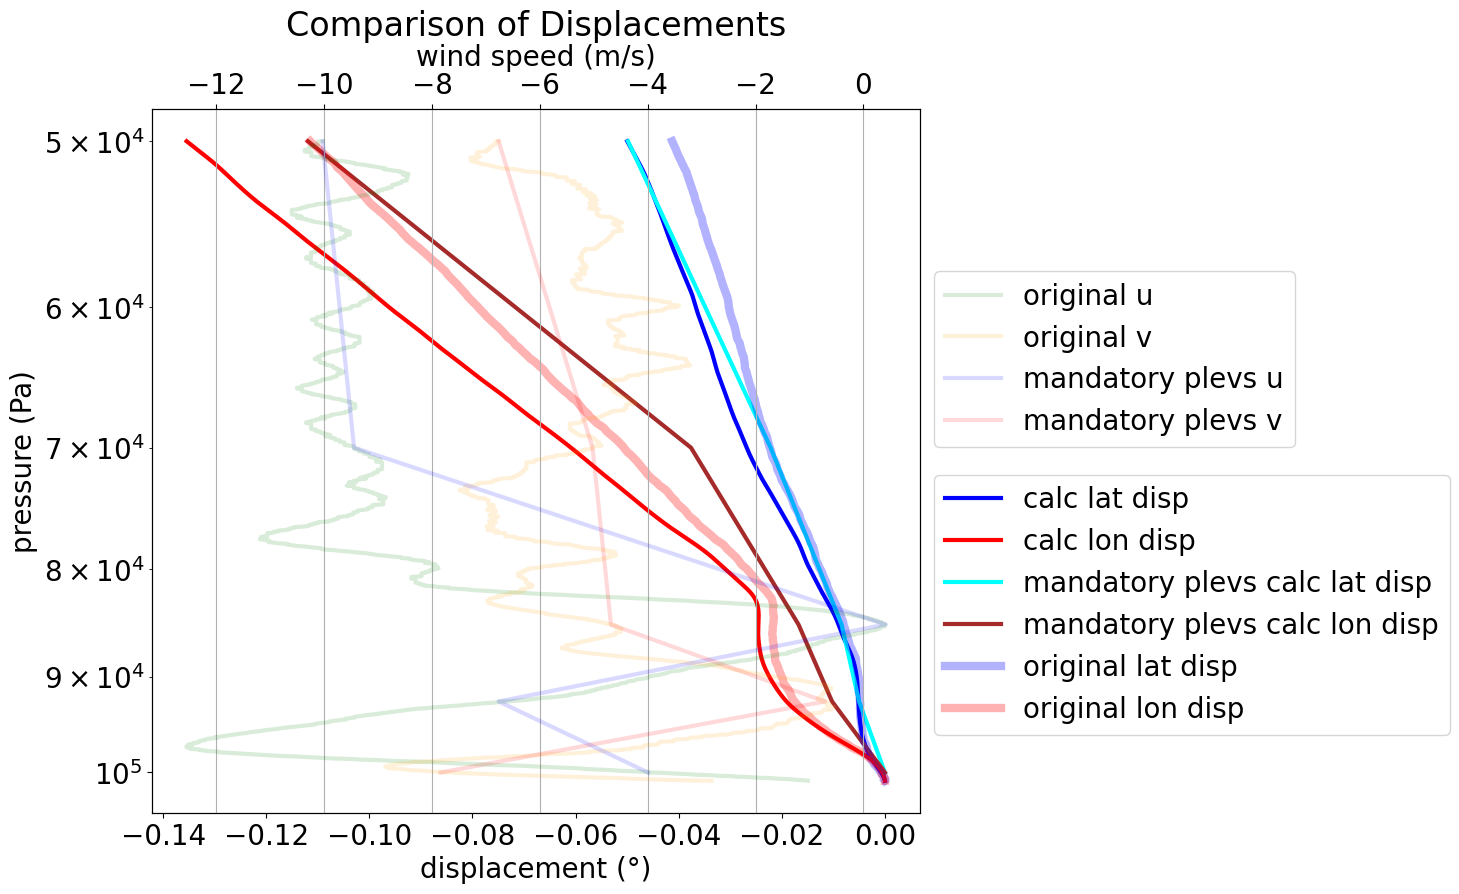

length of input data: 1440
significant levels: 10
lat:  48.24    lon:  11.55
date:  20200531.0    time:  224500.0


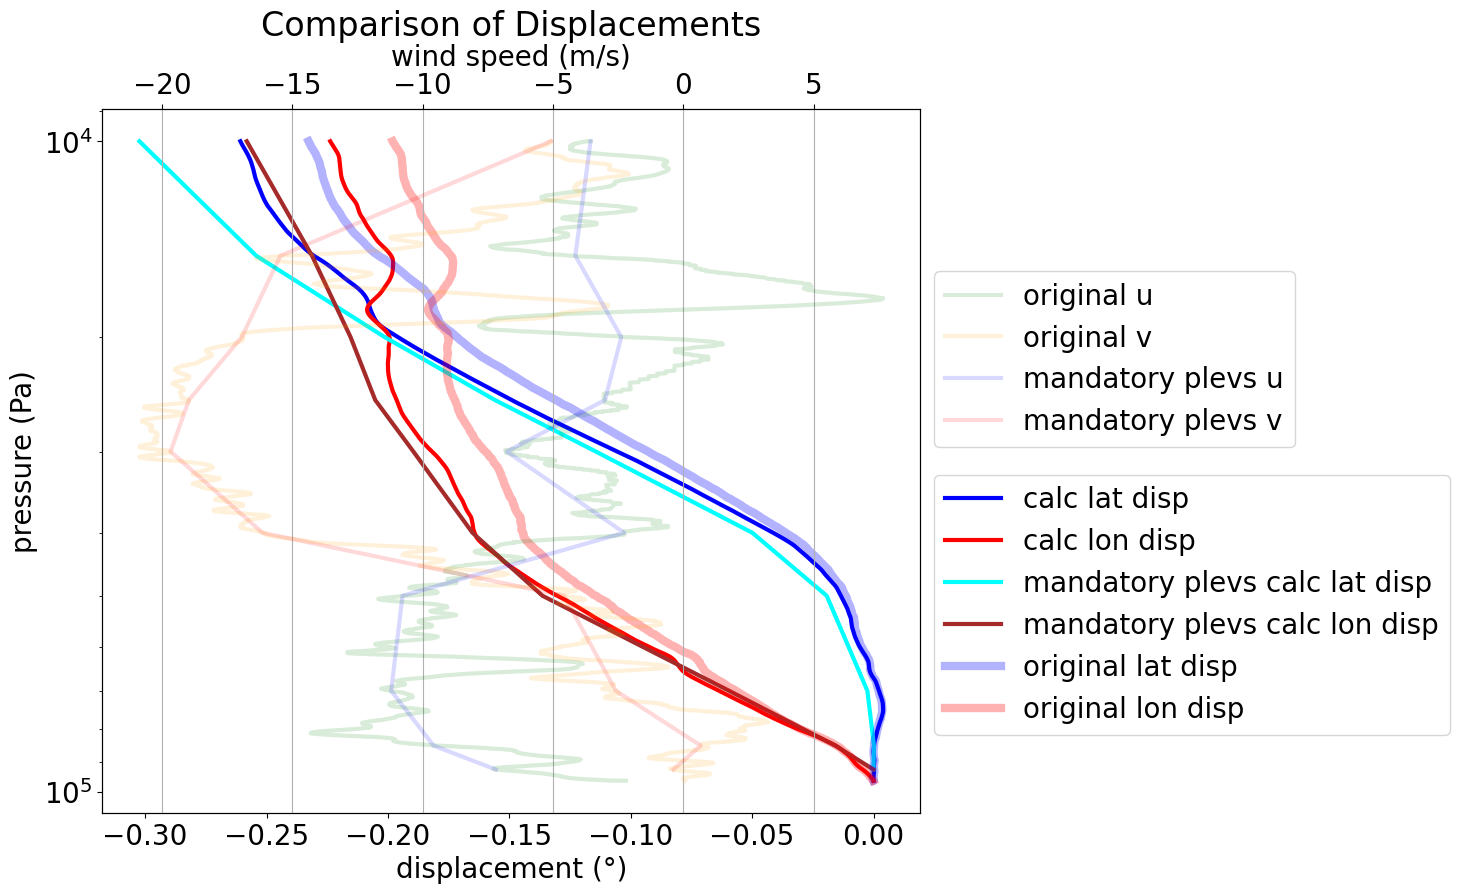

length of input data: 1744
significant levels: 11
lat:  51.410000000000004    lon:  6.970000000000001
date:  20200531.0    time:  224500.0


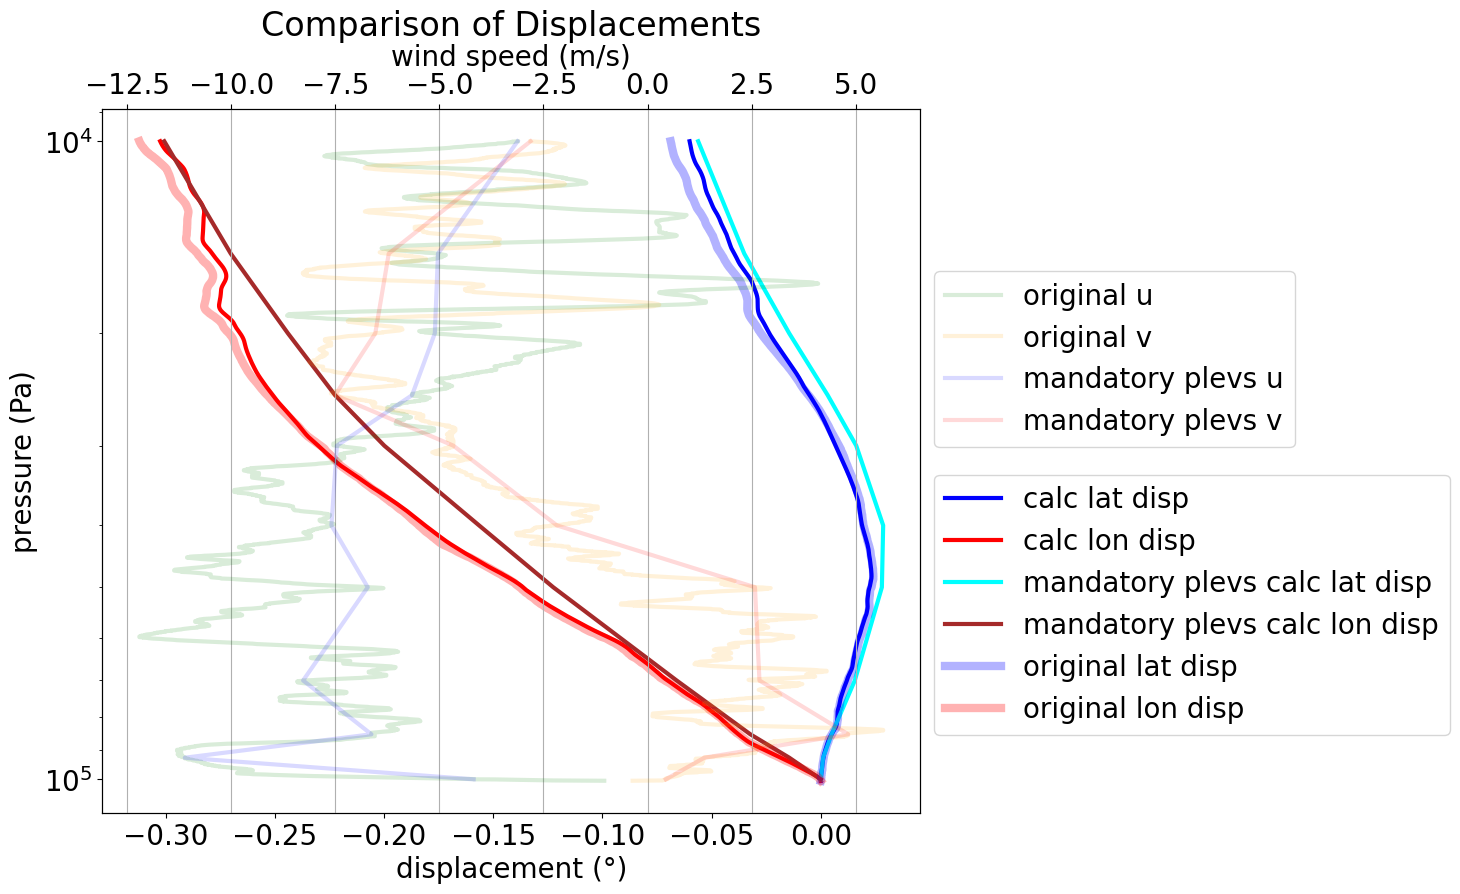

length of input data: 1332
significant levels: 13
lat:  49.45    lon:  17.130000000000003
date:  20200531.0    time:  231500.0


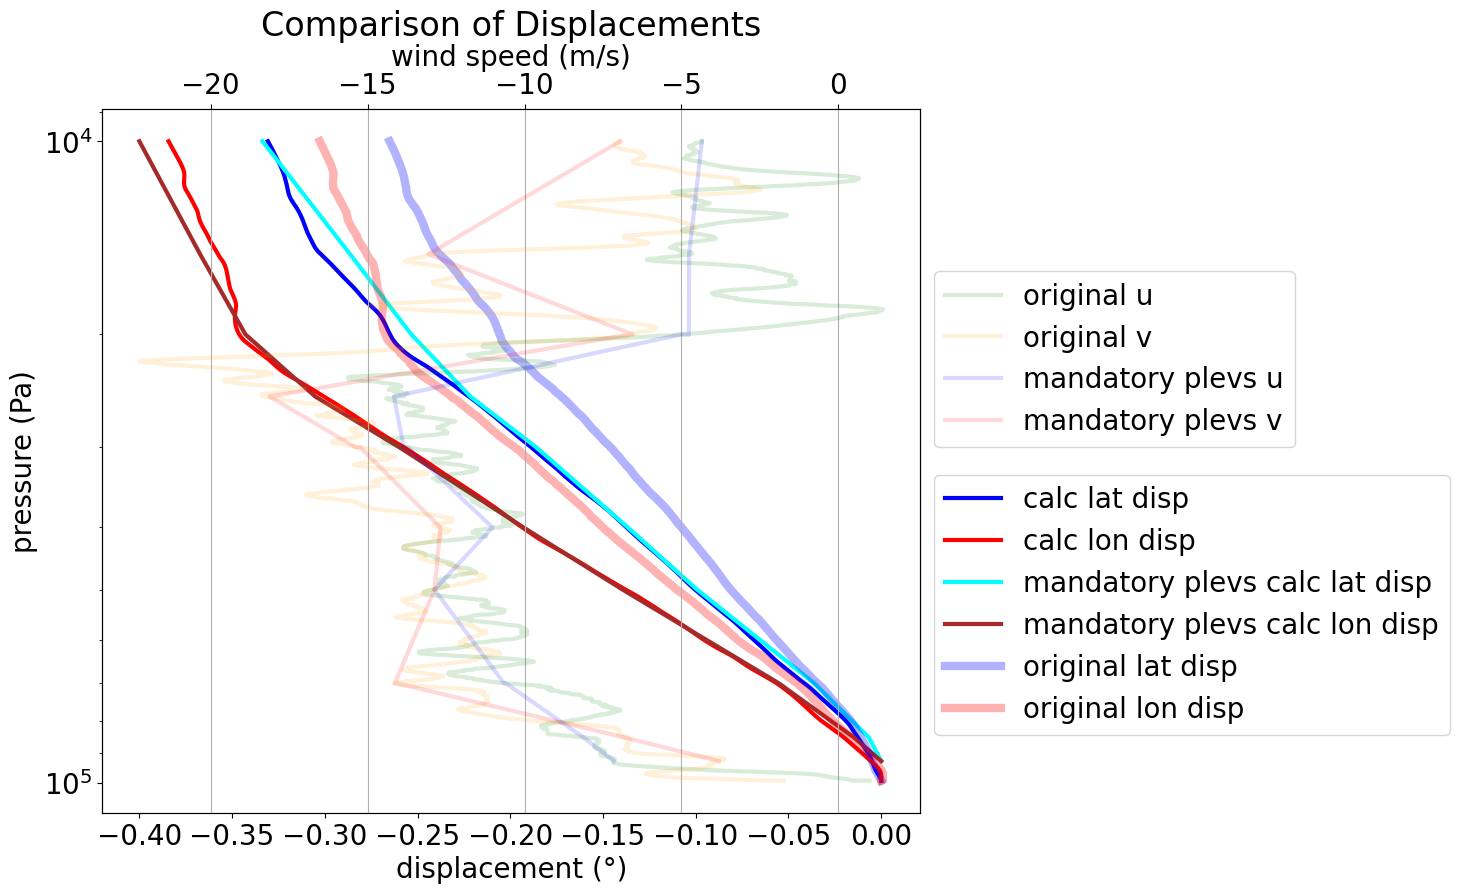

length of input data: 3357
significant levels: 8
lat:  36.25    lon:  -86.56
date:  20200531.0    time:  230000.0


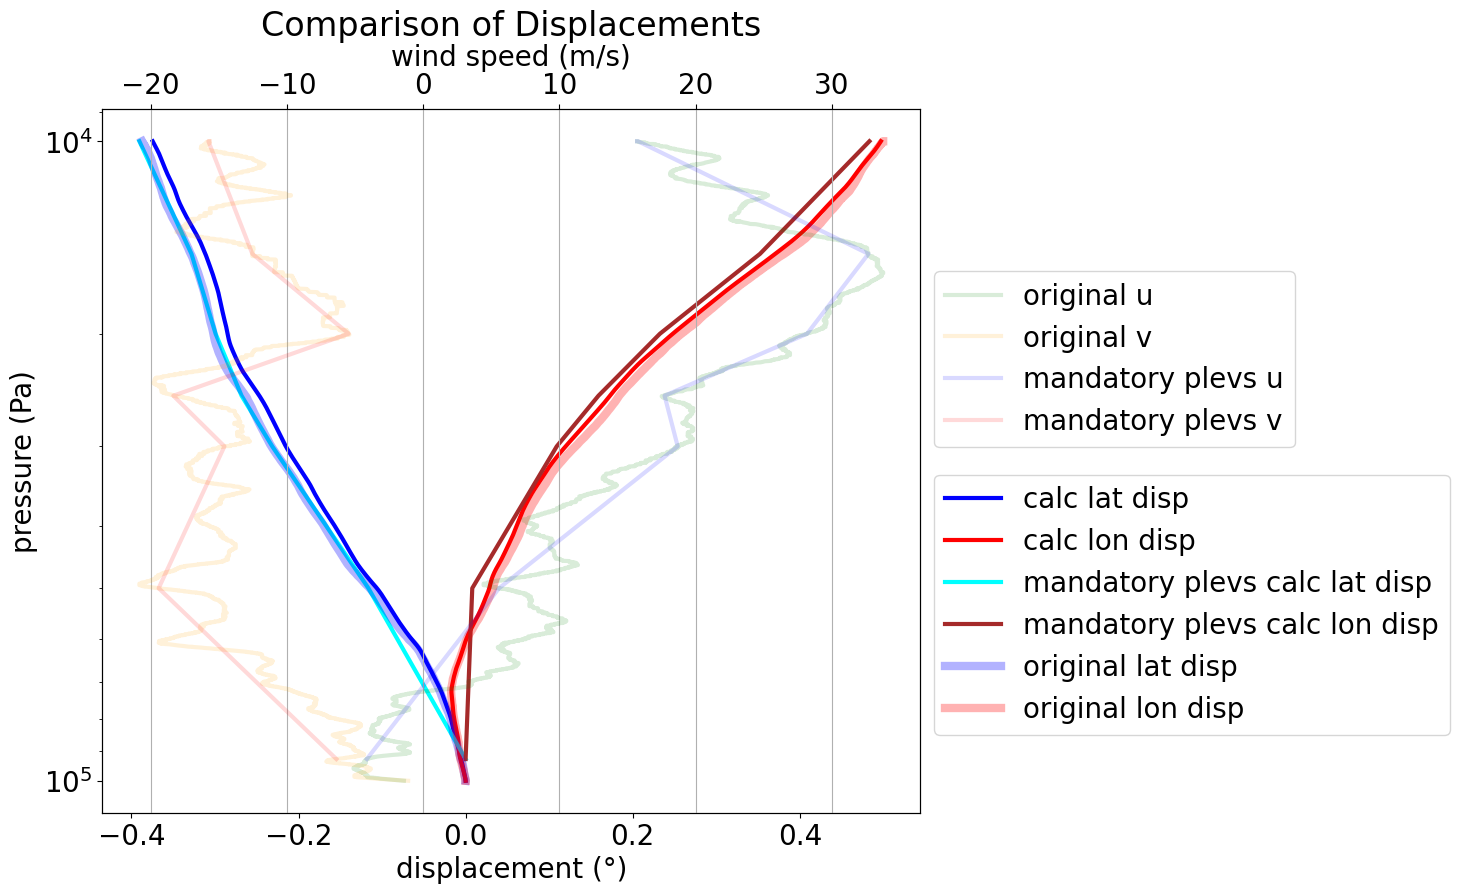

length of input data: 3330
significant levels: 7
lat:  40.77    lon:  -111.95
date:  20200531.0    time:  230300.0


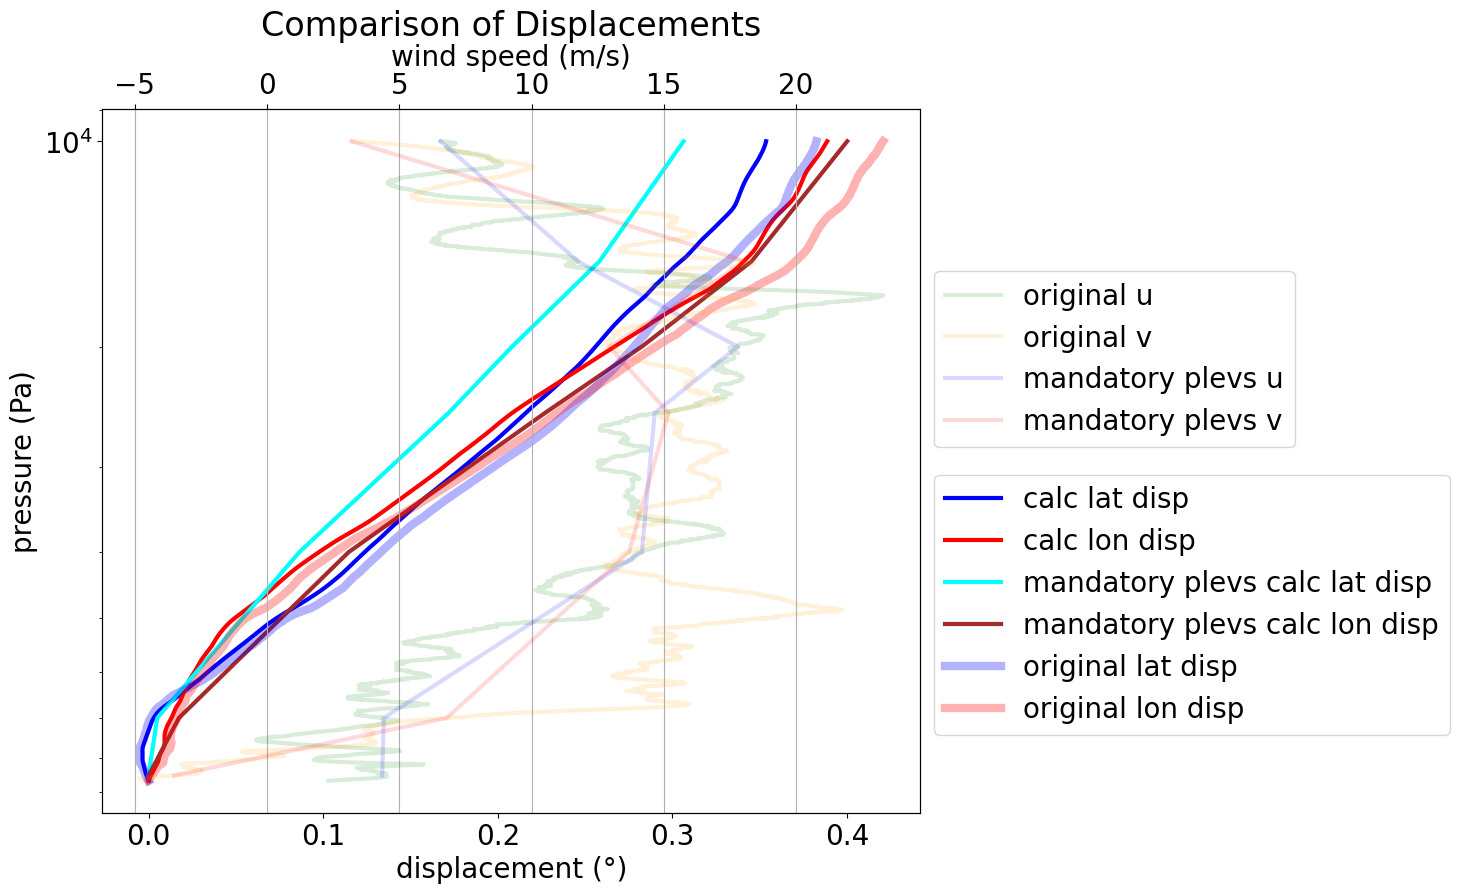

length of input data: 1727
significant levels: 11
lat:  -66.28    lon:  110.52000000000001
date:  20200531.0    time:  231500.0


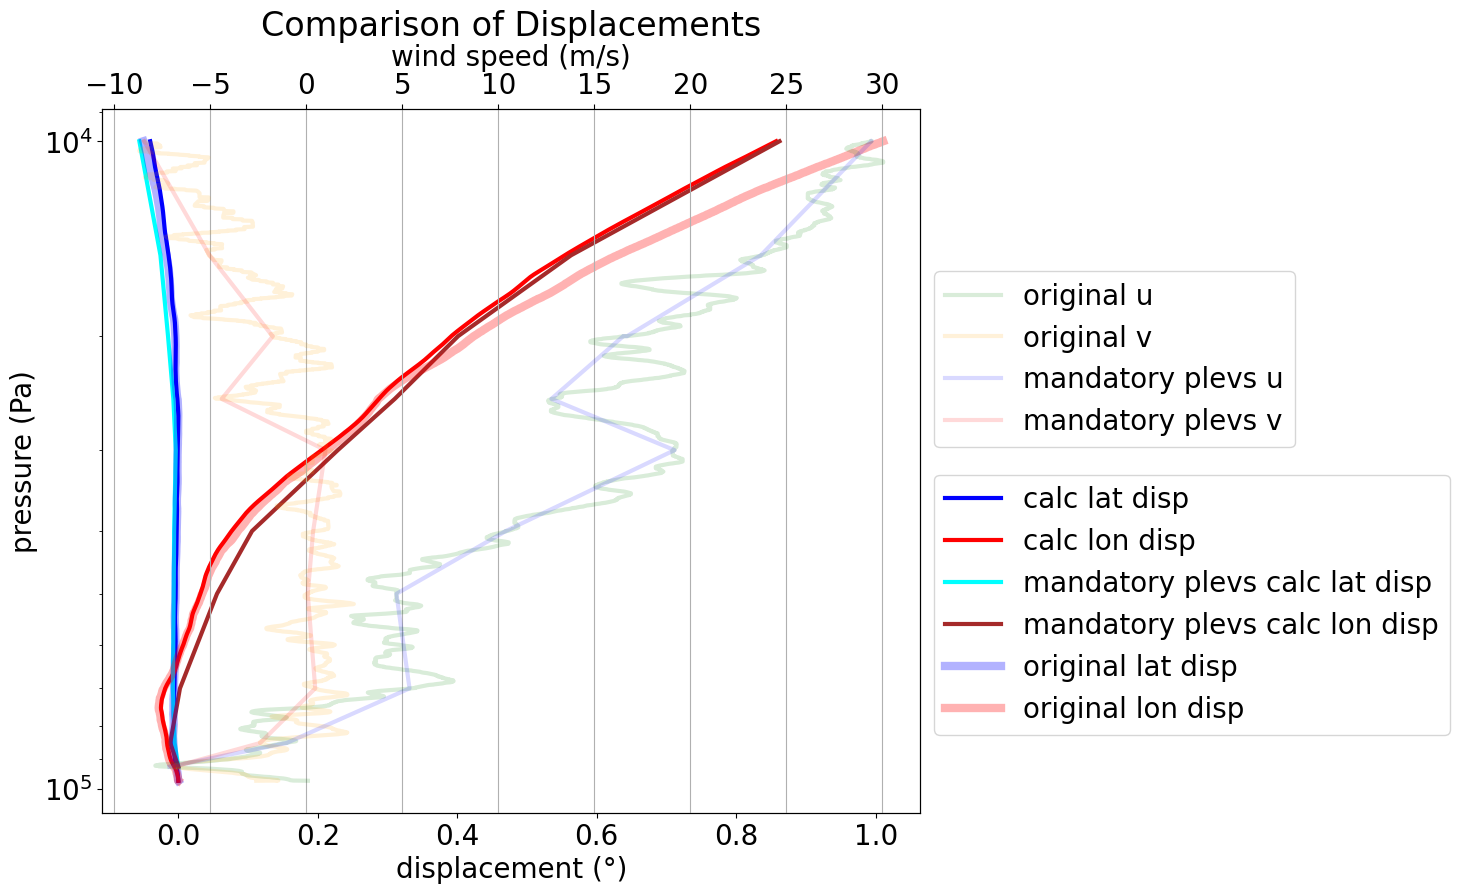

length of input data: 2589
significant levels: 15
lat:  33.45    lon:  135.76000000000002
date:  20200531.0    time:  233200.0


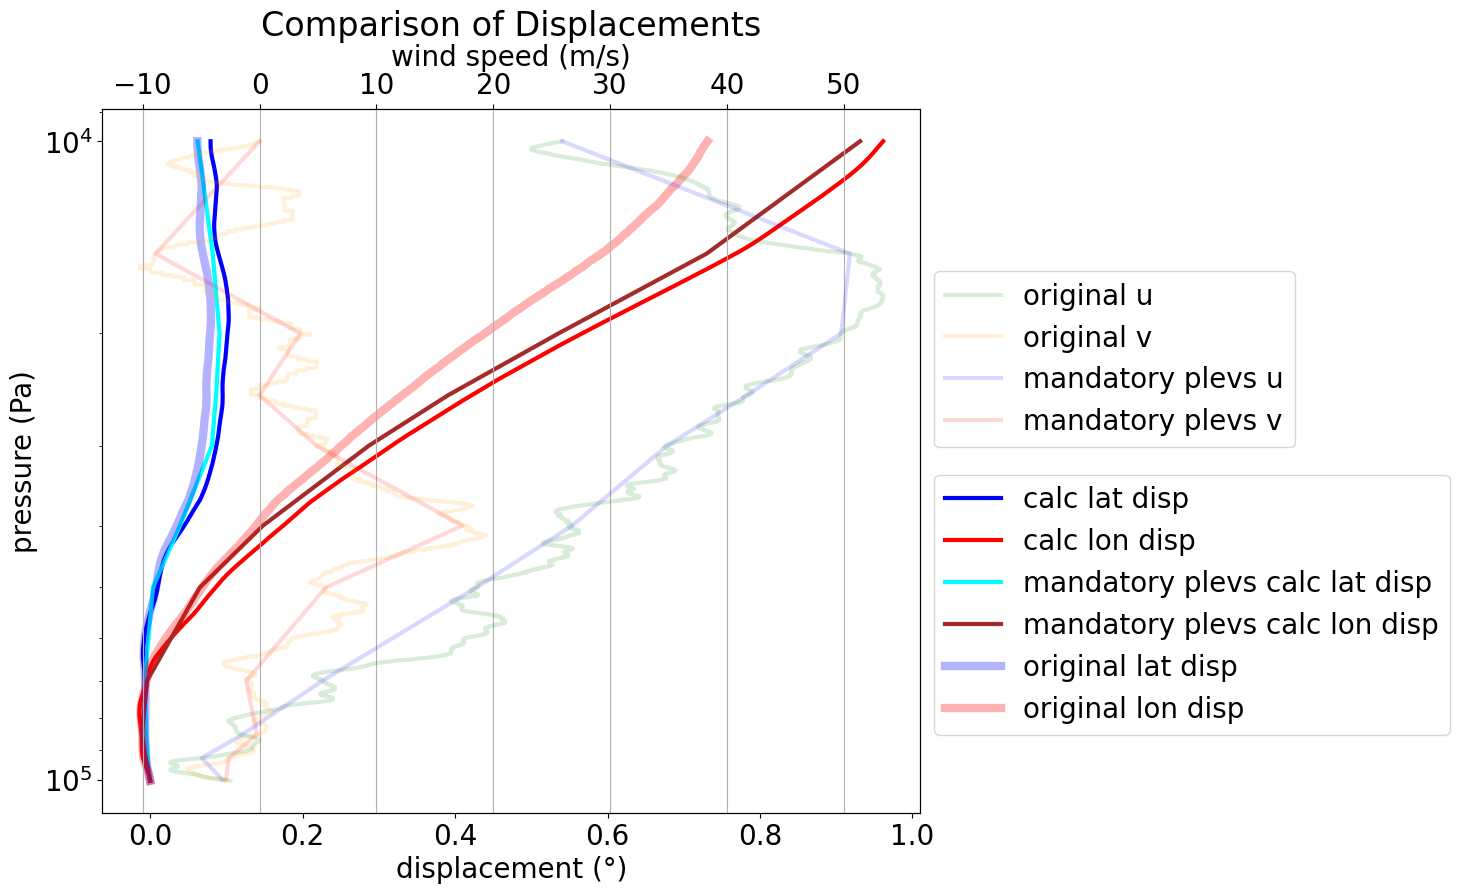

length of input data: 3599
significant levels: 11
lat:  30.450000000000003    lon:  -84.30000000000001
date:  20200531.0    time:  231900.0


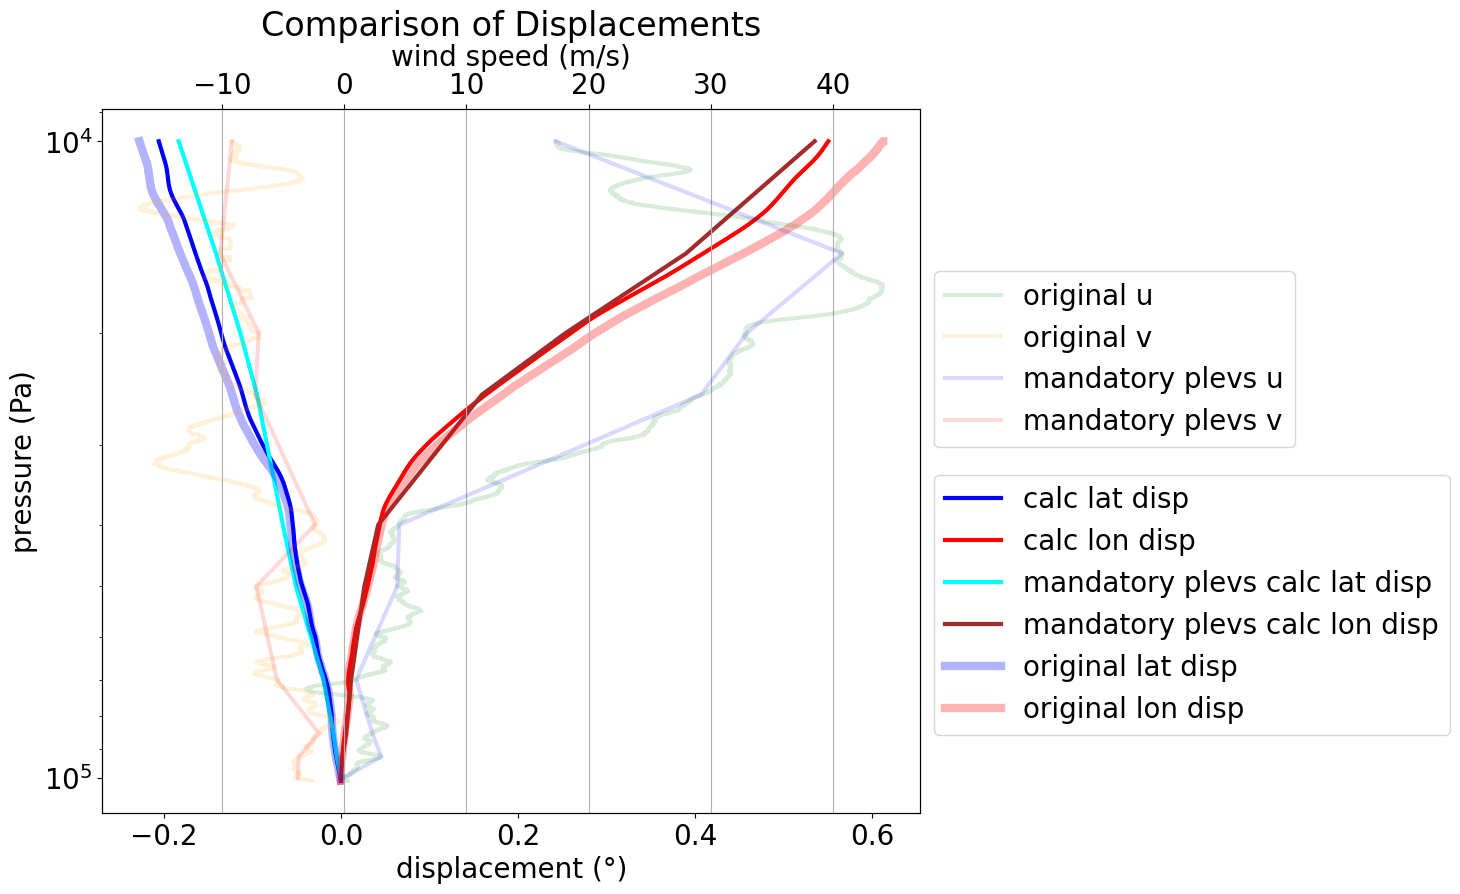

length of input data: 5234
significant levels: 25
lat:  25.92    lon:  -97.42
date:  20200531.0    time:  230400.0


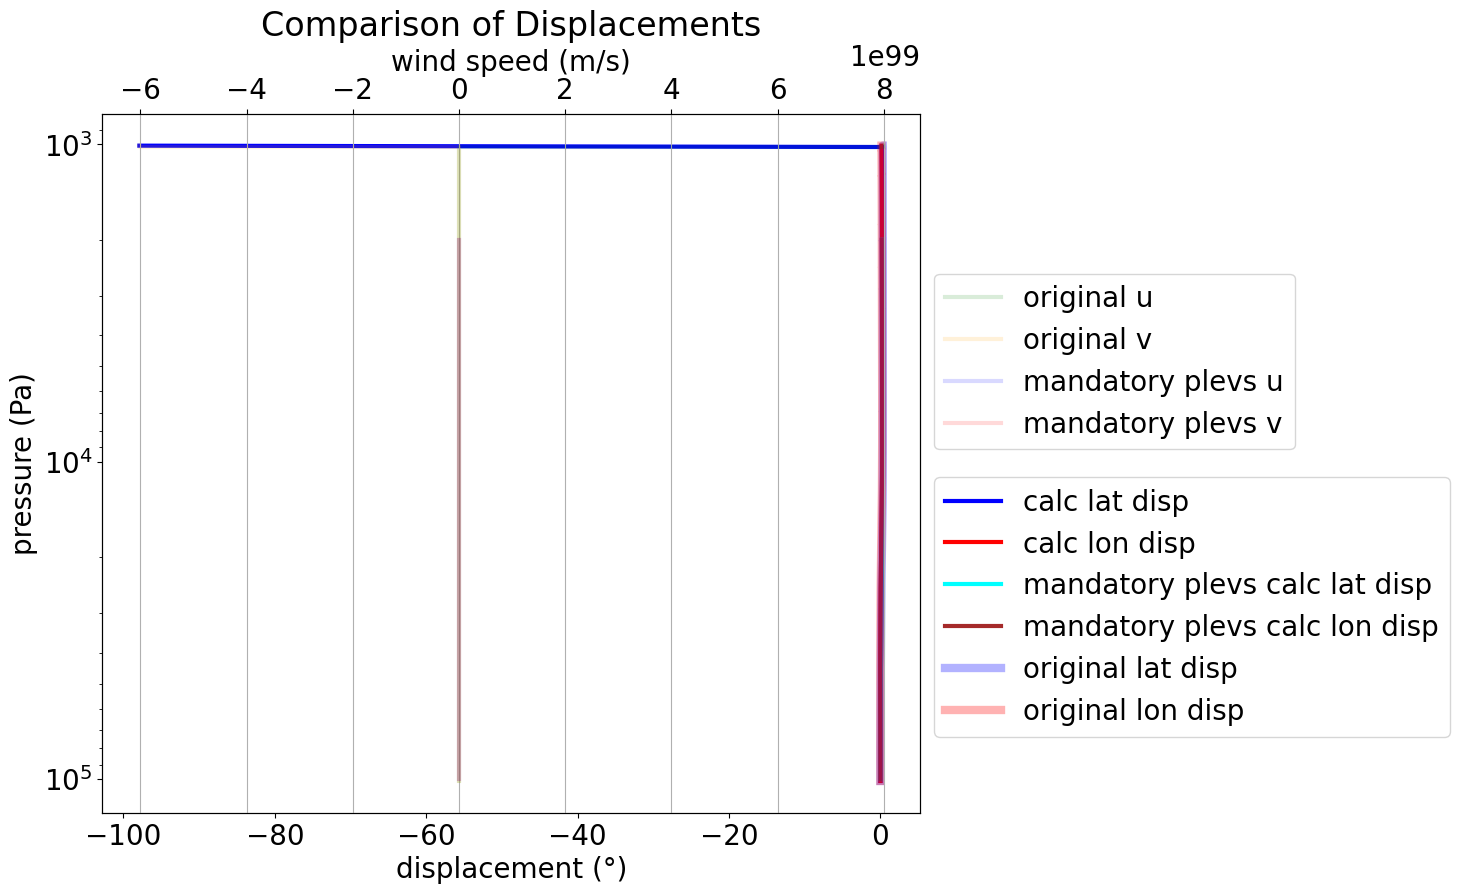

length of input data: 2409
significant levels: 21
lat:  53.010000000000005    lon:  -1.25
date:  20200531.0    time:  231500.0


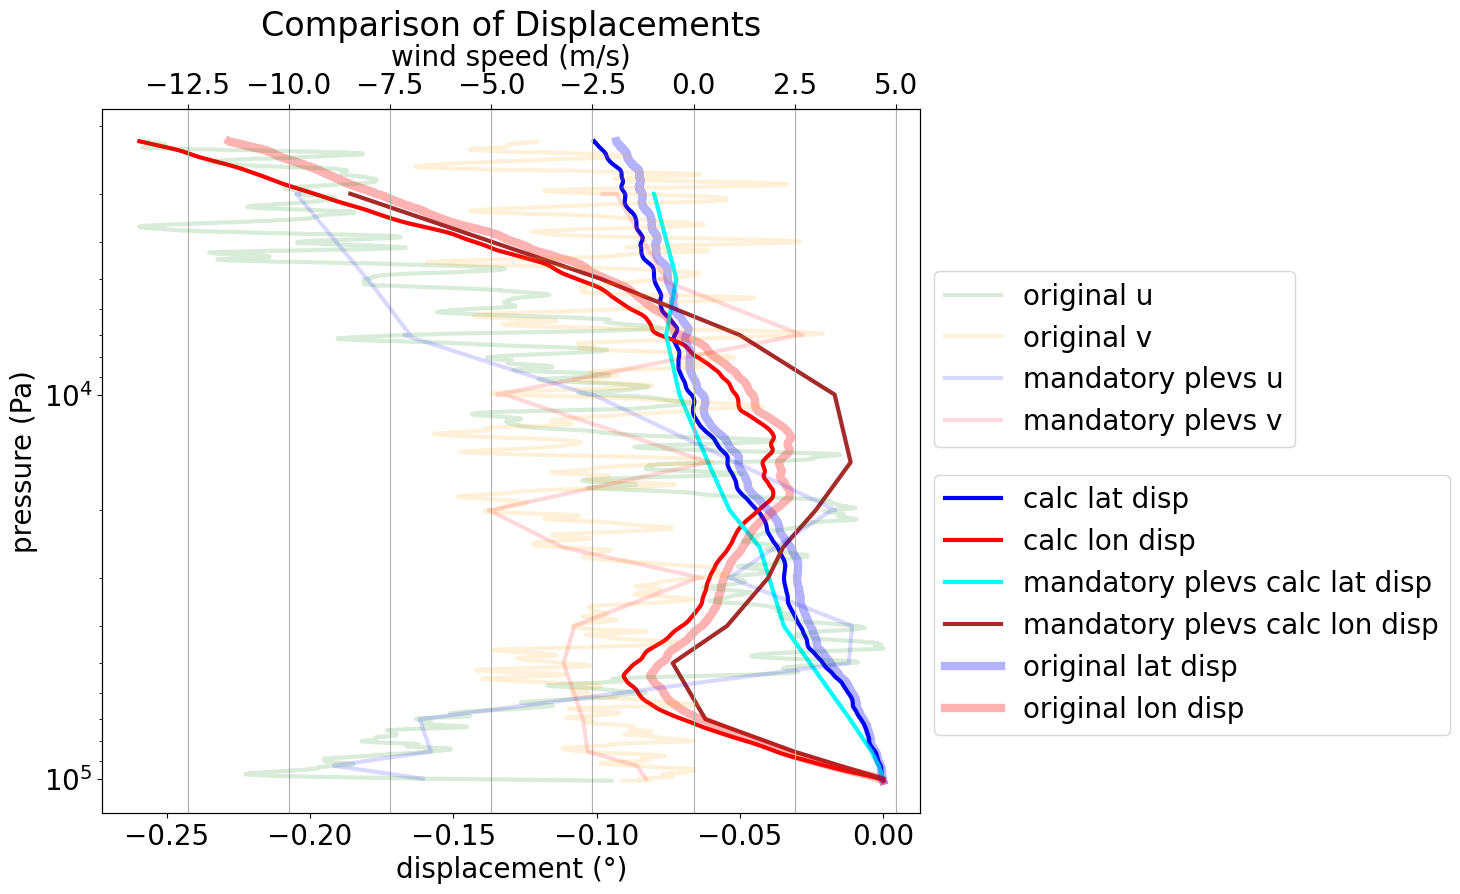

length of input data: 2160
significant levels: 13
lat:  49.690000000000005    lon:  7.330000000000001
date:  20200531.0    time:  224500.0


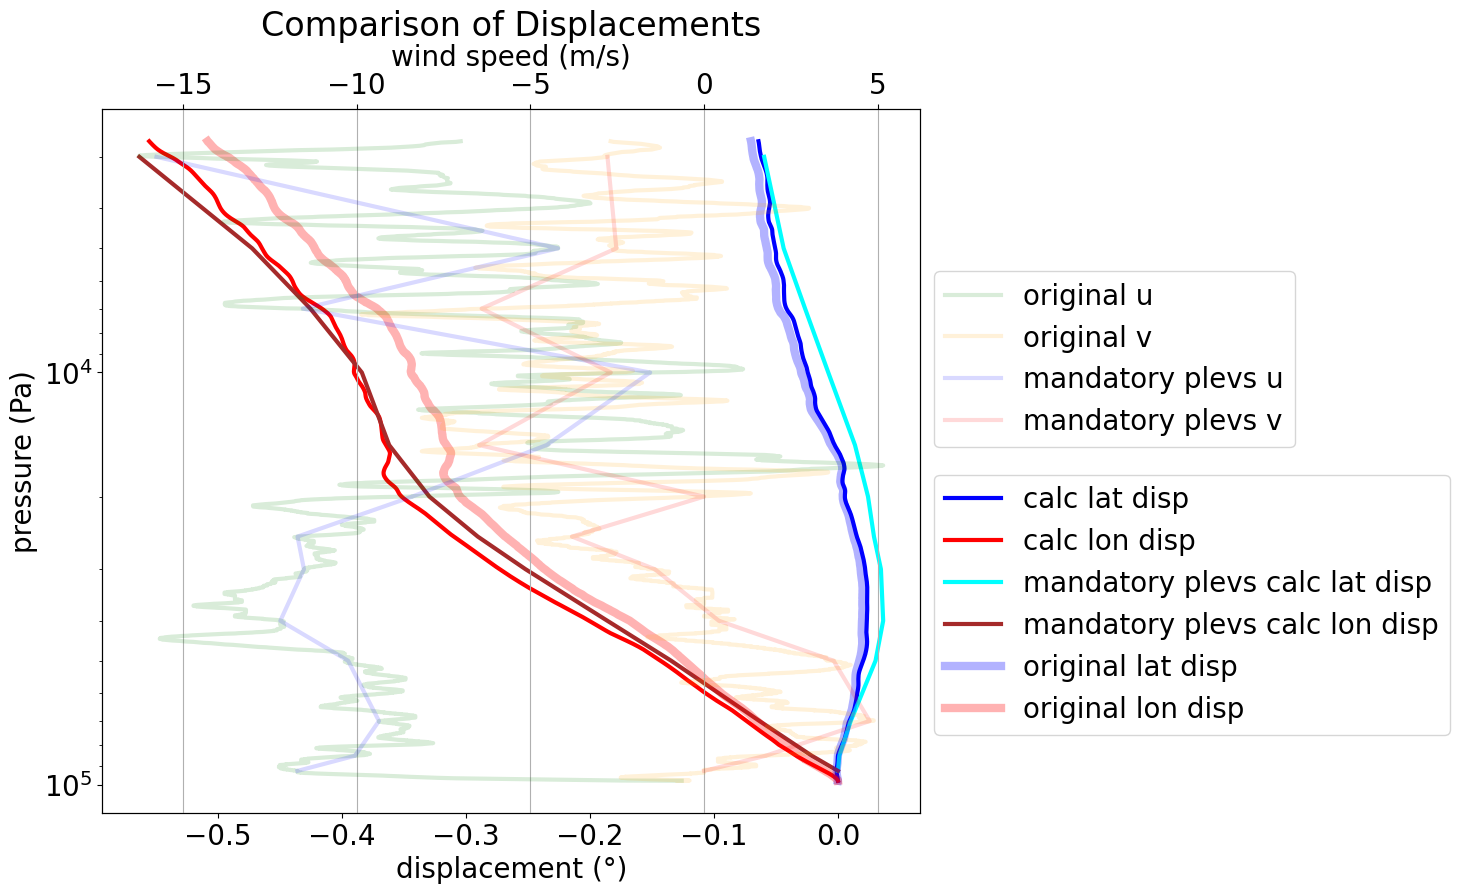

length of input data: 6097
significant levels: 37
lat:  36.25    lon:  -86.56
date:  20200531.0    time:  230000.0


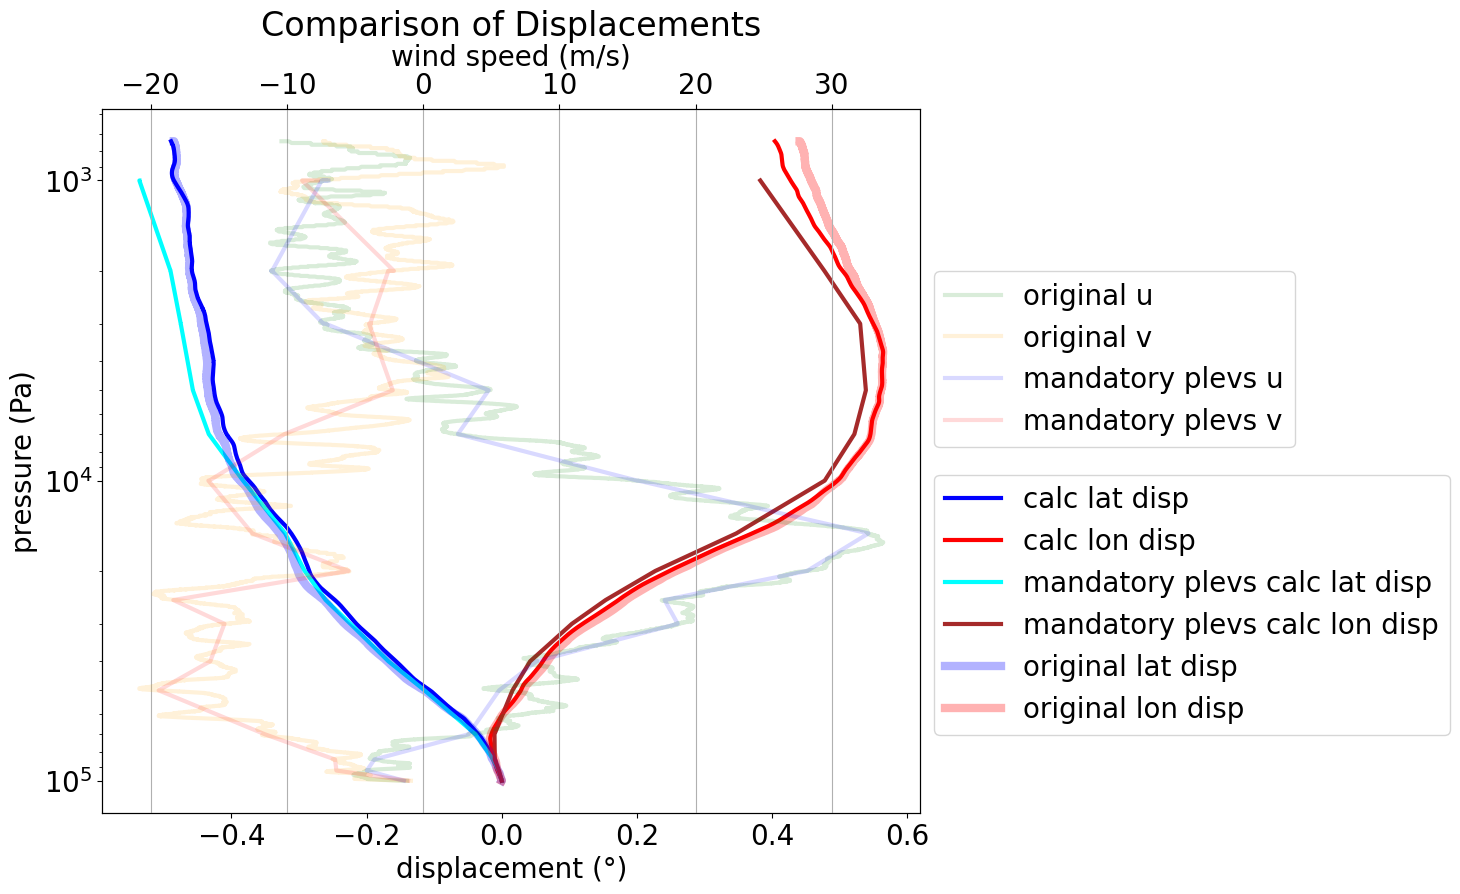

length of input data: 6372
significant levels: 46
lat:  57.150000000000006    lon:  -170.22000000000003
date:  20200531.0    time:  230100.0


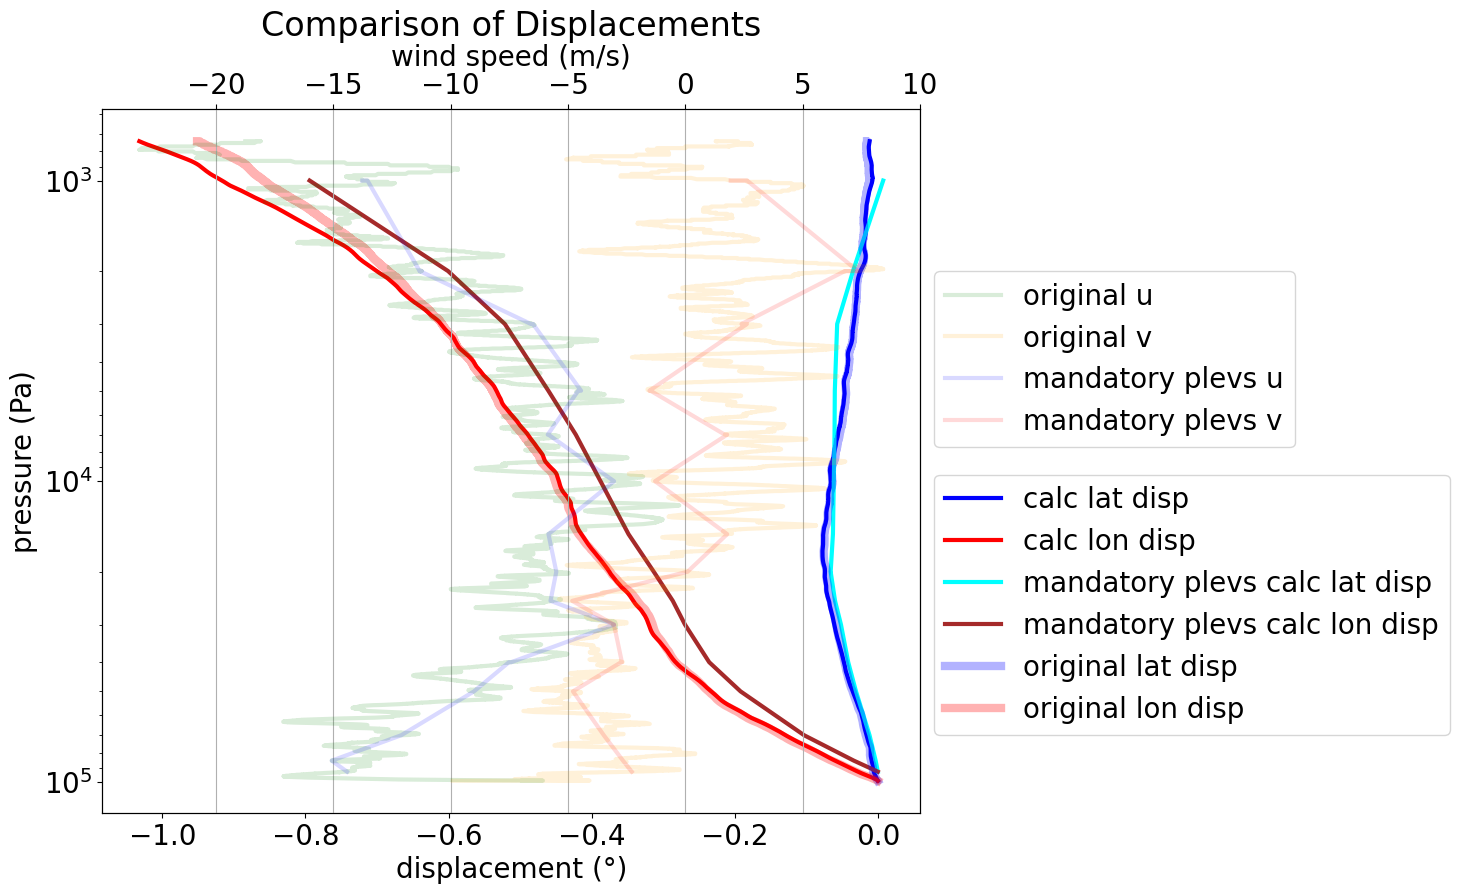

length of input data: 6156
significant levels: 32
lat:  33.36    lon:  -84.57000000000001
date:  20200531.0    time:  231400.0


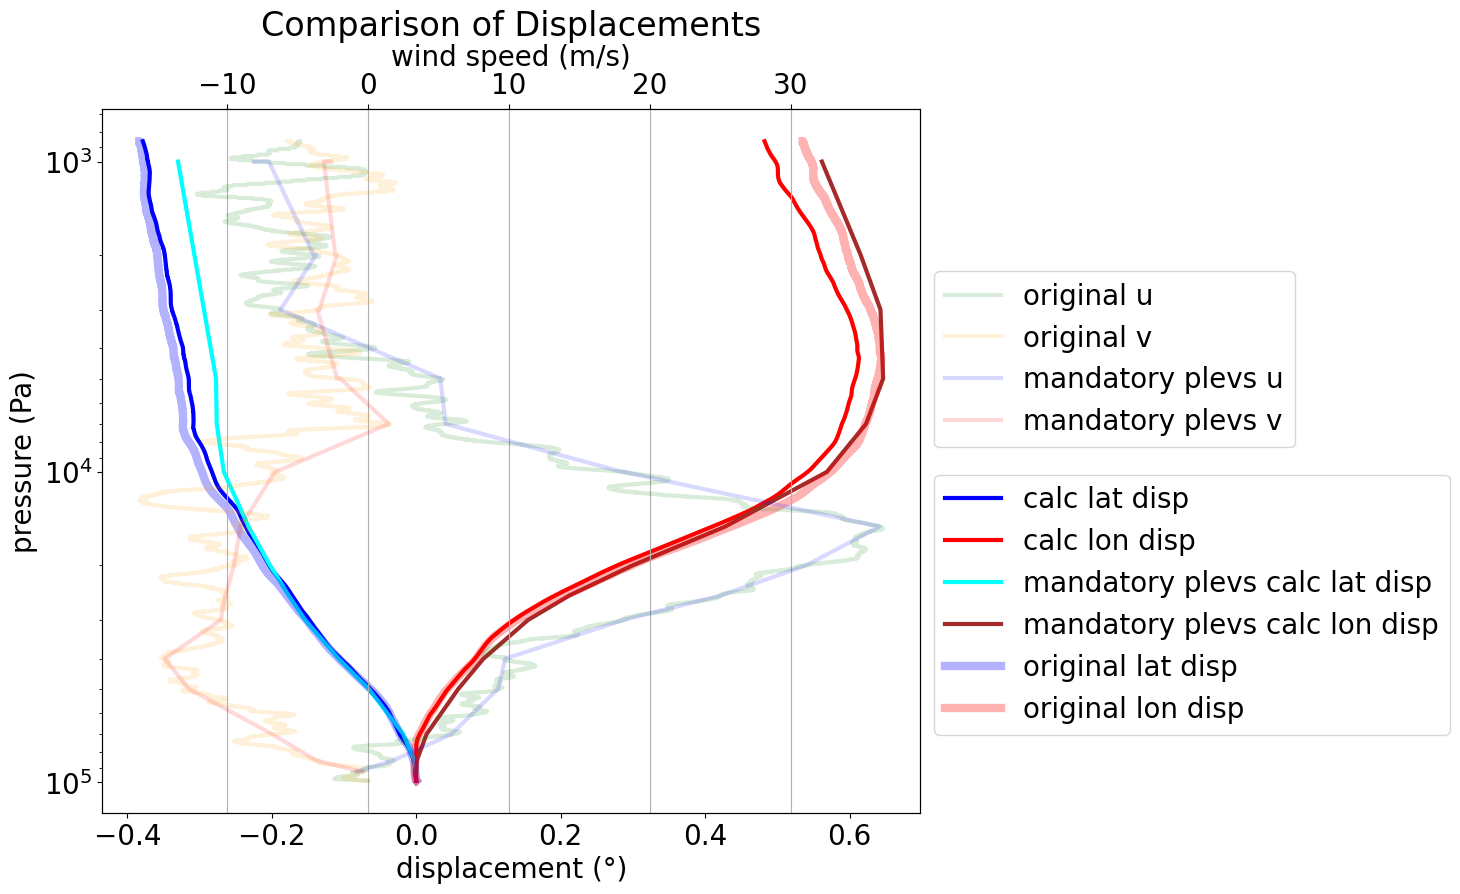

length of input data: 5978
significant levels: 33
lat:  32.45    lon:  -93.84
date:  20200531.0    time:  231600.0


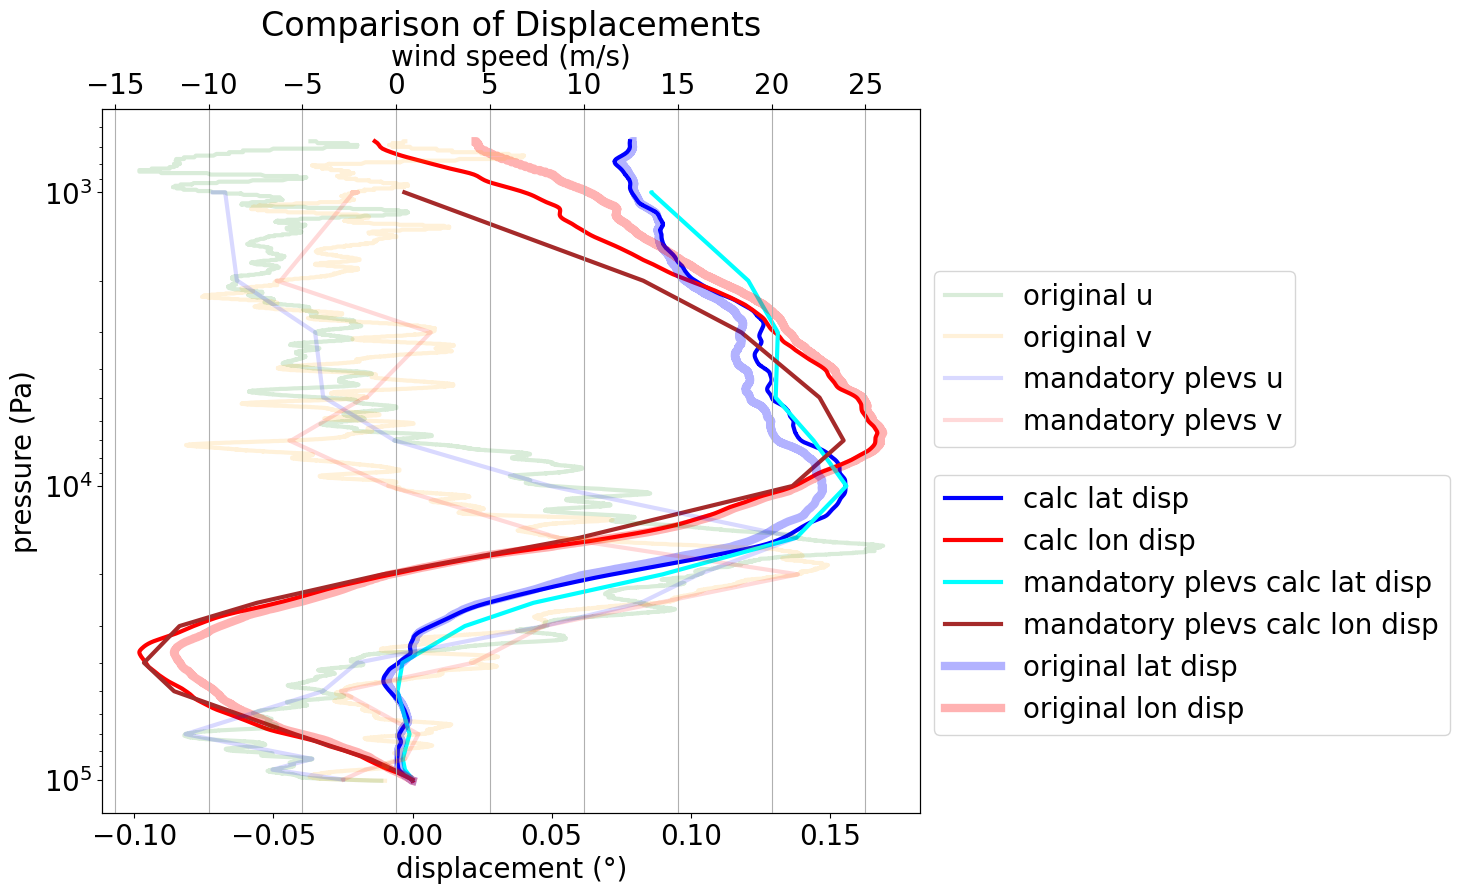

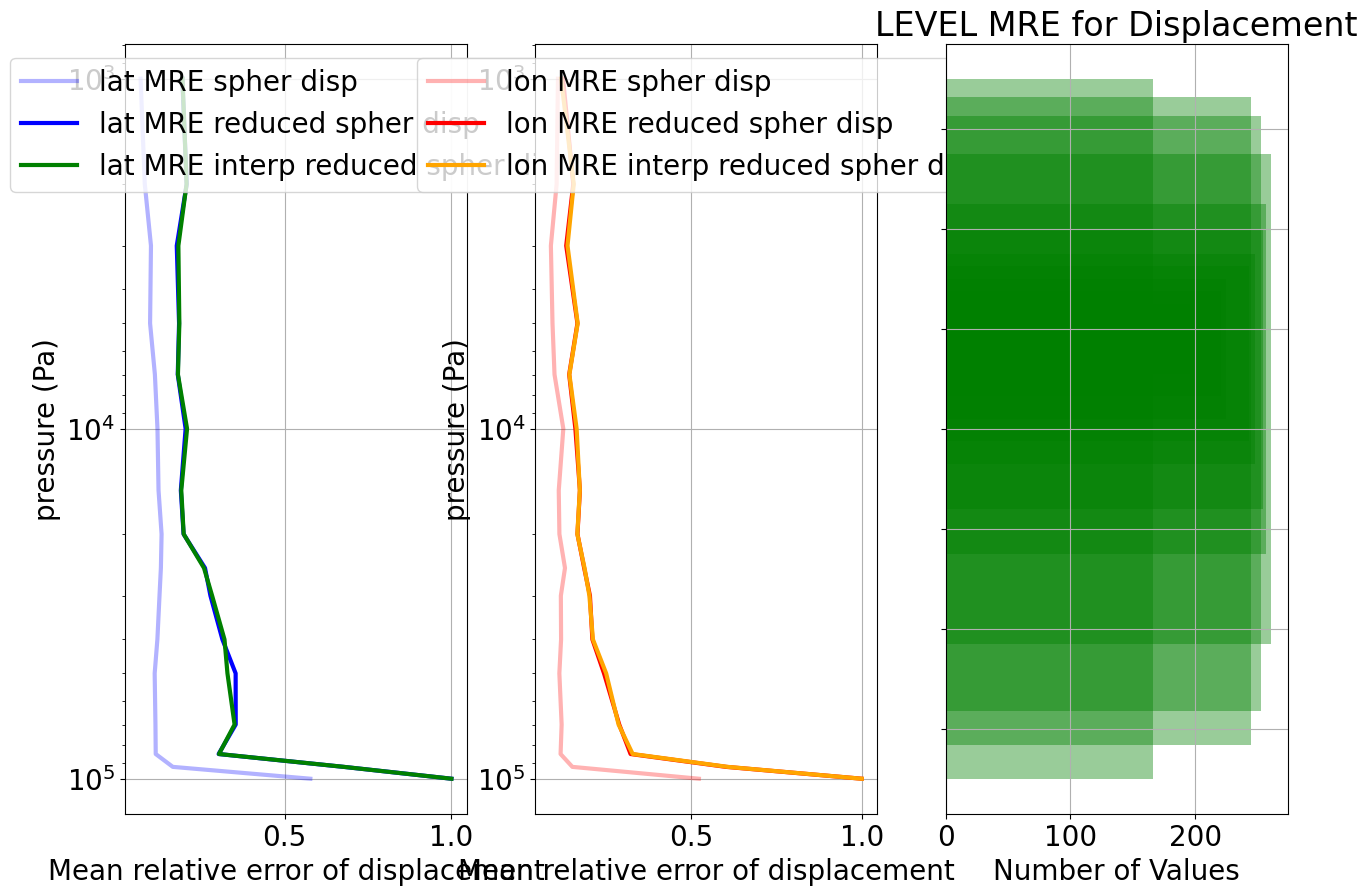

In [47]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])


In [10]:
def par_read_bufr_stn_nofeedback_mre_interp(varno,bufrfile):
    pltcount = 0
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    

    plev_vals = {}    
    rmse_sum_lon_s={}
    rmse_sum_lat_s={}
    rmse_sum_lon_sr={}
    rmse_sum_lat_sr={}
    rmse_sum_lon_sri={}
    rmse_sum_lat_sri={}

    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        plev_vals[i] = []
        rmse_sum_lon_s[i] = []
        rmse_sum_lat_s[i] = []
        rmse_sum_lon_sr[i] = []
        rmse_sum_lat_sr[i] = []
        rmse_sum_lon_sri[i] = []
        rmse_sum_lat_sri[i] = []

        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        try:
            output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
    #             if str(output['datum'])[4:6] != '12':
    #                 codes_release(bufr)
    #                 continue
            output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
            output['pressure'] = codes_get_array(bufr, "pressure")
            output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
            output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
            output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
            output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
            output['airTemperature'] = codes_get_array(bufr, "airTemperature")
            dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
            output['windDirection'] = codes_get_array(bufr, "windDirection")
            output['windSpeed'] = codes_get_array(bufr, "windSpeed")
            output['lat'] = codes_get(bufr, "latitude")
            output['lon'] = codes_get(bufr, "longitude")
            output['alt'] = float(codes_get(bufr, "heightOfStation"))
            output['blockNumber'] = codes_get(bufr, "blockNumber")
            output['stationNumber'] = codes_get(bufr, "stationNumber")
        
            out = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
            
        codes_release(bufr)

            
        if cont:
            # try:
            out = out[out.airTemperature < 350]
            out = out[out.airTemperature > 180]

            out['u'] = out.windSpeed * np.cos(np.radians(270.0 - out.windDirection))
            out['v'] = out.windSpeed * np.sin(np.radians(270.0 - out.windDirection))

            reduced_out = out[np.isin(out.pressure, stdplevs)]
            if len(reduced_out) < 5:
                continue
                
            if (np.abs(np.nanmean(out.longitudeDisplacement)) < 0.001) or (np.abs(np.nanmean(out.latitudeDisplacement)) < 0.001) or (np.max(np.abs(out.latitudeDisplacement)) > 10):
                continue
            
            if (len(out) < 0) or (len(reduced_out) < 3):
                continue
                
            num_p = 20
            p_list = np.linspace(out.pressure.iloc[0], out.pressure.iloc[-1], num=num_p)
            true_p_list = list(reduced_out.pressure)
            for i in p_list:
                true_p_list.append(find_nearest(out.pressure, i))
            interpolated_reduced_out = out[np.isin(out.pressure, true_p_list)]
            # display(interpolated_reduced_out)
            # display(reduced_out)
            u_new = []
            v_new = []
            # print(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))
            # print((np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u))))
            
            # u_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
            # v_new = (np.interp(interpolated_reduced_out.pressure, np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
            
            for k in range(len(interpolated_reduced_out)):
                if reduced_out.pressure.iloc[0] >= interpolated_reduced_out.pressure.iloc[k] >= reduced_out.pressure.iloc[-1]:
                    u_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.u)))
                    v_new.append(np.interp(interpolated_reduced_out.pressure.iloc[k], np.flip(reduced_out.pressure), np.flip(reduced_out.v)))
                else:
                    u_new.append(np.nan)
                    v_new.append(np.nan)

            u = np.array(u_new)
            v = np.array(v_new)
            interpolated_reduced_out['ip_u'] = u
            interpolated_reduced_out['ip_v'] = v
            interpolated_reduced_out = interpolated_reduced_out.dropna(subset=['ip_u', 'ip_v'])
                
            reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(interpolated_reduced_out.airTemperature), u=np.array(interpolated_reduced_out.ip_u), v=np.array(interpolated_reduced_out.ip_v),
                pressure=np.array(interpolated_reduced_out.pressure),
                transport_type='sphere')
            
            # print(reduced_interp_sph_lat_disp, reduced_interp_sph_lon_disp)

            sph_lat_disp, sph_lon_disp, sph_rts = trj.trajectory(
                lat=out.lat.iloc[0], lon=out.lon.iloc[0],
                temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
                pressure=np.array(out.pressure),
                )

            reduced_sph_lat_disp, reduced_sph_lon_disp, reduced_sph_rts = trj.trajectory(
                lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
                temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
                pressure=np.array(reduced_out.pressure),
                )

#             ell_lat_disp, ell_lon_disp, ell_rts = trj.trajectory(
#                 lat=out.lat.iloc[0], lon=out.lon.iloc[0],
#                 temperature=np.array(out.airTemperature), u=np.array(out.u), v=np.array(out.v),
#                 pressure=np.array(out.pressure),
#                 transport_type='geod')

#             reduced_ell_lat_disp, reduced_ell_lon_disp, reduced_ell_rts = trj.trajectory(
#                 lat=reduced_out.lat.iloc[0], lon=reduced_out.lon.iloc[0],
#                 temperature=np.array(reduced_out.airTemperature), u=np.array(reduced_out.u), v=np.array(reduced_out.v),
#                 pressure=np.array(reduced_out.pressure),
#                 transport_type='geod')
            # display(reduced_out)
            for i in stdplevs:
                # print(i)
                # print(float(np.array(sph_lon_disp)[out.pressure == i]), out[out.pressure == i].longitudeDisplacement.values)
                # print(float(np.array(sph_lat_disp)[out.pressure == i]), out[out.pressure == i].latitudeDisplacement.values)
                try:
                    rmse_sum_lon_s[i].append(
                        float(np.array(sph_lon_disp)[out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].longitudeDisplacement.values[0])
                    )
                    rmse_sum_lat_s[i].append(
                        float(np.array(sph_lat_disp)[out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].latitudeDisplacement.values[0])
                    )
                    
                    rmse_sum_lon_sr[i].append(
                        float(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].longitudeDisplacement.values[0])
                    )
                    rmse_sum_lat_sr[i].append(
                        float(np.array(reduced_sph_lat_disp)[reduced_out.pressure == i] - 
                              reduced_out[reduced_out.pressure == i].latitudeDisplacement.values[0])
                    )
                    
                    
#                     rmse_sum_lon_sri[i].append(
#                         float(np.abs(np.array(reduced_interp_sph_lon_disp)[interpolated_reduced_out.pressure == i] - 
#                               interpolated_reduced_out[interpolated_reduced_out.pressure == i].longitudeDisplacement.values) 
#                         / (np.abs(reduced_out[reduced_out.pressure == i].longitudeDisplacement.values))
#                     ))
#                     rmse_sum_lat_sri[i].append(
#                         float(np.abs(np.array(reduced_interp_sph_lat_disp)[interpolated_reduced_out.pressure == i] - 
#                               interpolated_reduced_out[interpolated_reduced_out.pressure == i].latitudeDisplacement.values) 
#                         / (np.abs(reduced_out[reduced_out.pressure == i].latitudeDisplacement.values))
#                     ))
                    plev_vals[i].append(1)
                except:
                    rmse_sum_lon_s[i].append(np.nan)
                    rmse_sum_lat_s[i].append(np.nan)
                    rmse_sum_lon_sr[i].append(np.nan)
                    rmse_sum_lat_sr[i].append(np.nan)
                    # rmse_sum_lon_sri[i].append(np.nan)
                    # rmse_sum_lat_sri[i].append(np.nan)
                    plev_vals[i].append(0)
                    
#             if (pltcount % 20) == 0:
#                 print('length of input data:',len(out))
#                 print('significant levels:',len(reduced_out))
#                 print('lat: ',out.lat.iloc[0], '   lon: ', out.lon.iloc[0])
#                 print('date: ', out.datum.iloc[0], '   time: ', out.timePeriod.iloc[0])
#                 # display(interpolated_reduced_out)
#                 fig, ax1 = maplt.subplots(figsize=(15, 9))
#                 ax1.set_yscale('log')
#                 # ax1.plot(np.array(reduced_interp_sph_lat_disp), interpolated_reduced_out.pressure, color = 'green', alpha = 1, linewidth= 1, label='ri sphere calc lat disp')
#                 # ax1.plot(np.array(reduced_interp_sph_lon_disp), interpolated_reduced_out.pressure, color = 'brown', alpha = 1, linewidth= 1, label='ri sphere calc lon disp')

#                 ax1.plot(np.array(sph_lat_disp), out.pressure,color = 'blue', alpha = 1, label='calc lat disp')
#                 ax1.plot(np.array(sph_lon_disp),out.pressure,color = 'red', alpha = 1, label='calc lon disp')

#                 # ax1.plot(np.array(ell_lat_disp), out.pressure,color = 'blue', alpha = 0.3, linewidth= 6, label='geod calc lat disp')
#                 # ax1.plot(np.array(ell_lon_disp),out.pressure,color = 'red', alpha = 0.3, linewidth= 6, label='geod calc lon disp')

#                 ax1.plot(np.array(reduced_sph_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 1, label='std plevs calc lat disp')
#                 ax1.plot(np.array(reduced_sph_lon_disp),reduced_out.pressure,color = 'brown', alpha = 1, label='std plevs calc lon disp')

# #                 ax1.plot(np.array(reduced_ell_lat_disp), reduced_out.pressure,color = 'cyan', alpha = 0.3, linewidth= 6, label='reduced geod calc lat disp')
# #                 ax1.plot(np.array(reduced_ell_lon_disp),reduced_out.pressure,color = 'orange', alpha = 0.3, linewidth= 6, label='reduced geod calc lon disp')

#                 #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#                 #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
#                 ax1.plot(out.latitudeDisplacement,out.pressure,color = 'blue',alpha = 0.3, linewidth= 6, label='original lat disp')
#                 ax1.plot(out.longitudeDisplacement,out.pressure, color = 'red',alpha = 0.3, linewidth= 6, label='original lon disp')

#                 ax1.set_ylabel('pressure (Pa)')
#                 ax1.set_xlabel('displacement (°)')
#                 ax1.tick_params(axis='x')
#                 ax1.set_ylim(ax1.get_ylim()[::-1])
#                 ax1.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

#                 ax1_2 = ax1.twiny()
#                 ax1_2.set_yscale('log')
#                 ax1_2.plot(out.u,out.pressure, color = 'green', alpha = 0.15, label='u')
#                 ax1_2.plot(out.v,out.pressure, color = 'orange', alpha = 0.15, label='v')
#                 ax1_2.plot(reduced_out.u,reduced_out.pressure, color = 'blue', alpha = 0.15, label='u')
#                 ax1_2.plot(reduced_out.v,reduced_out.pressure, color = 'red', alpha = 0.15, label='v')

#                 fig.tight_layout()  # otherwise the right y-label is slightly clipped
#                 maplt.title('Comparison of Displacements')
#                 maplt.legend()
#                 maplt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
#                 maplt.grid()
#                 maplt.show()
#                 maplt.close()
            pltcount += 1
            
            # except: 
            #     pass
            # break
            if pltcount > 5000:
                break
    
    limit = [20,80]
    for i in stdplevs:
        
        rmse_sum_lat_s[i] = np.array(rmse_sum_lat_s[i])
        rmse_sum_lon_s[i] = np.array(rmse_sum_lon_s[i])
        rmse_sum_lat_sr[i] = np.array(rmse_sum_lat_sr[i])
        rmse_sum_lon_sr[i] = np.array(rmse_sum_lon_sr[i])
        # rmse_sum_lat_sri[i] = np.array(rmse_sum_lat_sri[i])
        # rmse_sum_lon_sri[i] = np.array(rmse_sum_lon_sri[i])
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_s[i], limit)
        outlier_drop = [-1,1]
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_s[i][rmse_sum_lat_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_s[i], limit)
        outlier_drop = [-1,1]
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_s[i][rmse_sum_lon_s[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lat_sr[i], limit)
        outlier_drop = [-1,1]
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lat_sr[i][rmse_sum_lat_sr[i] > outlier_drop[1]] = np.nan
        
        outlier_drop = np.nanpercentile(rmse_sum_lon_sr[i], limit)
        outlier_drop = [-1,1]
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] < outlier_drop[0]] = np.nan
        rmse_sum_lon_sr[i][rmse_sum_lon_sr[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lat_sri[i], limit)
#         rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lat_sri[i][rmse_sum_lat_sri[i] > outlier_drop[1]] = np.nan
        
#         outlier_drop = np.nanpercentile(rmse_sum_lon_sri[i], limit)
#         rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] < outlier_drop[0]] = np.nan
#         rmse_sum_lon_sri[i][rmse_sum_lon_sri[i] > outlier_drop[1]] = np.nan
    
    rmse_lat_s = []
    rmse_lon_s = []
    rmse_lat_sr = []
    rmse_lon_sr = []
    # rmse_lat_sri = []
    # rmse_lon_sri = []
    for i in stdplevs:
        print(i, np.nanmax(rmse_sum_lat_s[i]), np.nanmax(rmse_sum_lat_sr[i]))
        rmse_lat_s.append(np.sqrt(np.nanmean((rmse_sum_lat_s[i])**2)))
        rmse_lon_s.append(np.sqrt(np.nanmean((rmse_sum_lon_s[i])**2)))
        rmse_lat_sr.append(np.sqrt(np.nanmean((rmse_sum_lat_sr[i])**2)))
        rmse_lon_sr.append(np.sqrt(np.nanmean((rmse_sum_lon_sr[i])**2)))
        # rmse_lat_sri.append(np.sqrt(np.nanmean((rmse_sum_lat_sri[i])**2)))
        # rmse_lon_sri.append(np.sqrt(np.nanmean((rmse_sum_lon_sri[i])**2)))
        
        # rmse_lat_s.append(np.sqrt(np.nanmean(np.square(rmse_sum_lat_s[i]))))
        # rmse_lon_s.append(np.sqrt(np.nanmean(np.square(rmse_sum_lon_s[i]))))
        # rmse_lat_sr.append(np.sqrt(np.nanmean(np.square(rmse_sum_lat_sr[i]))))
        # rmse_lon_sr.append(np.sqrt(np.nanmean(np.square(rmse_sum_lon_sr[i]))))
        # rmse_lat_sri.append(np.nanmean(rmse_sum_lat_sri[i]))
        # rmse_lon_sri.append(np.nanmean(rmse_sum_lon_sri[i]))

    
    fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
    ax1[0].set_yscale('log')
    ax1[0].plot(np.array(rmse_lat_s), stdplevs, color = 'blue', label = 'lat disp RMSE')
    ax1[0].plot(np.array(rmse_lat_sr), stdplevs, color = 'cyan', ls='dotted', label = 'std plev lat disp RMSE')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('RMSE of displacement')
    ax1[0].legend(loc='upper center')
    ax1[0].grid()
    
    ax1[1].set_yscale('log')
    ax1[1].plot(np.array(rmse_lon_s), stdplevs, color = 'red', label = 'lon disp RMSE')
    ax1[1].plot(np.array(rmse_lon_sr), stdplevs, color = 'brown', ls = 'dotted', label = 'std plev lon disp RMSE')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('RMSE of displacement')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
    
    # value_nr = []
    # for i in plev_vals:
    #     value_nr.append(np.sum(plev_vals[i]))
    # ax1[2].barh(stdplevs, value_nr, np.array(stdplevs)*7, color='g', alpha = 0.4, align='center')
    # ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
    # ax1[2].set_xlabel('Number of Values')
    # ax1[2].tick_params(labelleft=False)
    # ax1[2].grid()
    
    # maplt.title('LEVEL MRE for Displacement')
    maplt.show()
    maplt.close()
    
    return out

<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>
Please resort the input data - ascending order is necessary!
Please resort the input data - ascending order is necessary!
Please resort the input data - ascending order is necessary!
100000 0.01443999999994671 0.014440000000000001
92500 0.6064560637991921 0.01796
85000 0.8476629329737412 0.04764
70000 0.8920404309093459 0.045790000000000004
50000 0.8341412311192938 0.15879000000000001
40000 0.9578078225890747 0.25597000000000003
30000 0.9494022961398458 0.58665
25000 0.6235866246302533 0.5889214272193102
20000 0.3923579480284876 0.7204137423533121
15000 0.8828256218442592 0.7220083456696852
10000 0.9515020733211916 0.7301467247517961
7000 0.8644270839292243 0.42551647230826223
5000 0.6599894723513262 0.42687279339636036
3000 0.671788809831663 0.2621770343046335
2000 0.9976798972032811 0.1581855699766077
1000 0.08387366835826066 0.12168962164038782


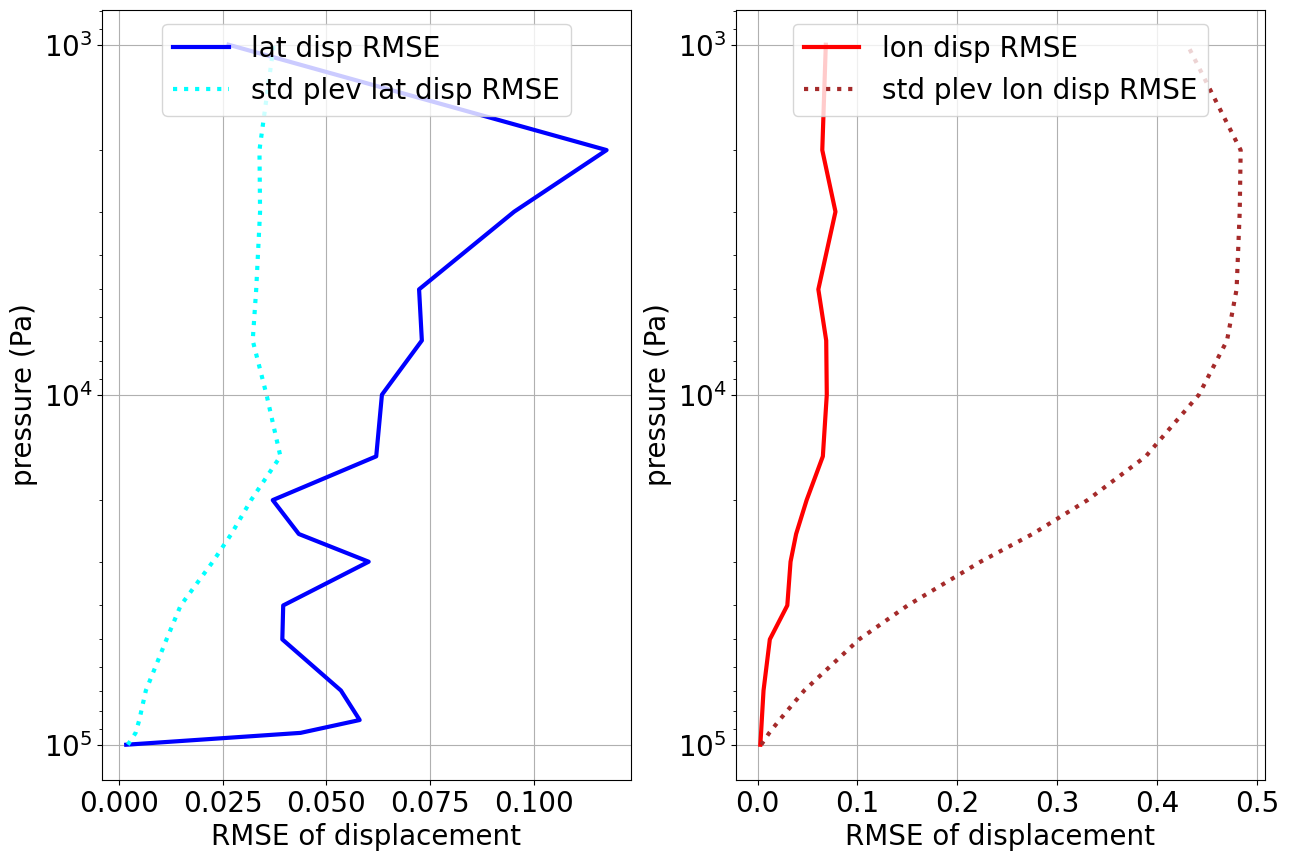

In [8]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>
100000 0.4481170261141544 0.01898
92500 0.922902431550215 0.017810000000000003
85000 0.8927348740824772 0.043480000000000005
70000 0.8772777825607884 0.09630000000000001
50000 0.7453633511940908 0.21024
40000 0.9809853890583299 0.27021
30000 0.9490368784758088 0.43961000000000006
25000 0.9765071328229586 0.52147
20000 0.8641189442525293 0.7115891290500032
15000 0.9946844884163566 0.5313514410488974
10000 0.9301340714534979 0.2881270442004134
7000 0.6537480656743292 0.154130499953156
5000 0.9852490005696541 0.8242706523393583
3000 0.8408742423224357 0.18829107902654174
2000 0.07393032520662729 0.21056089273461048
1000 0.4431610278490368 0.2302109173971364


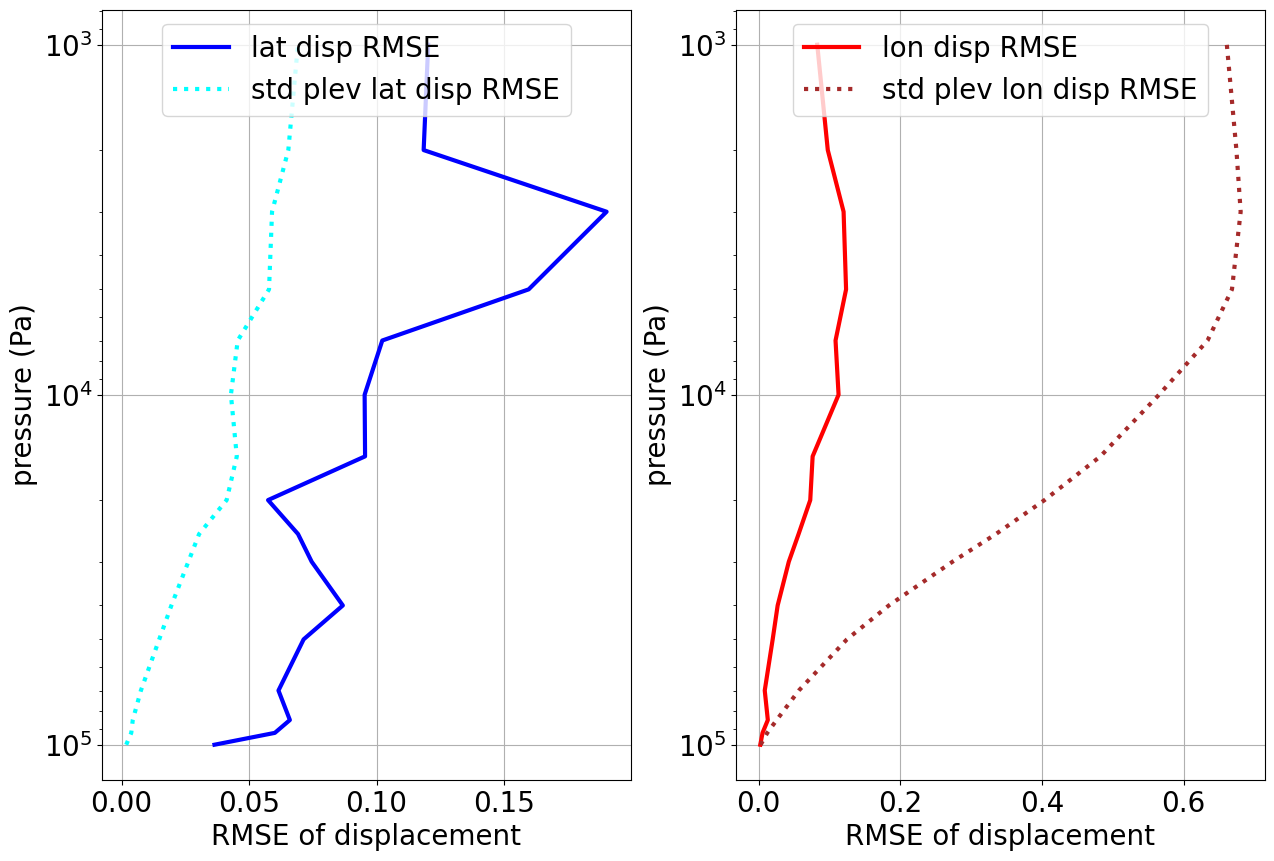

In [11]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202009' mode='r' encoding='UTF-8'>
Please resort the input data - ascending order is necessary!
Please resort the input data - ascending order is necessary!
Please resort the input data - ascending order is necessary!
100000 0.01051095586614357 0.01055
92500 0.9496421244381033 0.026160000000000003
85000 0.9492487589423201 0.04025916587714616
70000 0.9995140711720398 0.06568
50000 0.8867917282215974 0.16358
40000 0.9893318092396446 0.17426000000000003
30000 0.7308806232094132 0.23867000000000002
25000 0.865388829951502 0.24387861957136303
20000 0.9807025140774108 0.6710315360190027
15000 0.9965207325338028 0.26307400250554724
10000 0.7391971217740914 0.9920060734139404
7000 0.9767460411207085 0.9969474739362945
5000 0.3101762111677695 0.3073923560806622
3000 0.5064807922104706 0.30646744218266664
2000 0.7485267053028558 0.3127698900308379
1000 0.7939928471262101 0.20946203306131744


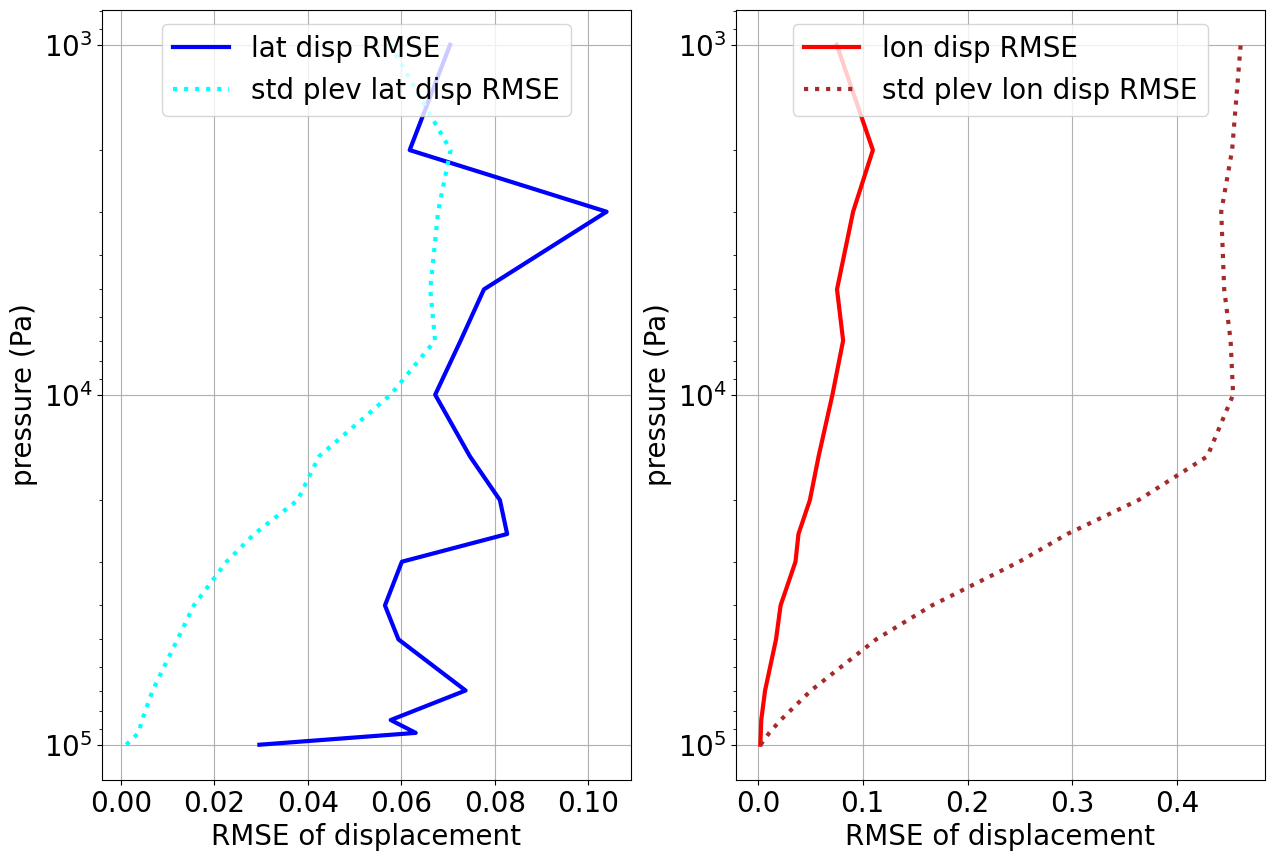

In [12]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202009')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback_mre_interp(111, sodblist[0]) #'./out.bufr')# sodblist[0])


In [20]:
bufrlatrmse = pd.read_csv('/users/staff/uvoggenberger/digitized/fig10/lat_rmse_bufr_disp.csv',delimiter=';', names=['val', 'p'], decimal=',')
redbufrlatrmse = pd.read_csv('/users/staff/uvoggenberger/digitized/fig10/lat_rmse_red_bufr_disp.csv',delimiter=';', names=['val', 'p'], decimal=',')
# templatrmse = pd.read_csv('/users/staff/uvoggenberger/digitized/fig10/lat_rmse_temp_disp.csv',delimiter=';', names=['val', 'p'], decimal=',')

bufrlonrmse = pd.read_csv('/users/staff/uvoggenberger/digitized/fig10/lon_rmse_bufr_disp.csv',delimiter=';', names=['val', 'p'], decimal=',')
redbufrlonrmse = pd.read_csv('/users/staff/uvoggenberger/digitized/fig10/lon_rmse_red_bufr_disp.csv',delimiter=';', names=['val', 'p'], decimal=',')
# templonrmse = pd.read_csv('/users/staff/uvoggenberger/digitized/fig10/lon_rmse_temp_disp.csv',delimiter=';', names=['val', 'p'], decimal=',')


In [35]:
redbufrlonrmse

val             p
0   0.001657  99904.306220
1   0.004696  92153.110048
2   0.004972  84880.382775
3   0.006906  79808.612440
4   0.010221  70143.540670
5   0.016575  58373.205742
6   0.027624  40000.000000
7   0.038398  31578.947368
8   0.048895  24114.832536
9   0.064365  16076.555024
10  0.079006  10047.846890
11  0.096685   6889.952153
12  0.105249   5167.464115
13  0.116298   3732.057416
14  0.128453   1913.875598
15  0.096133    861.244019

In [36]:
redbufrlonrmse = redbufrlonrmse.iloc[:-1]
redbufrlonrmse.loc[len(redbufrlonrmse)] = [0.096133,1000]

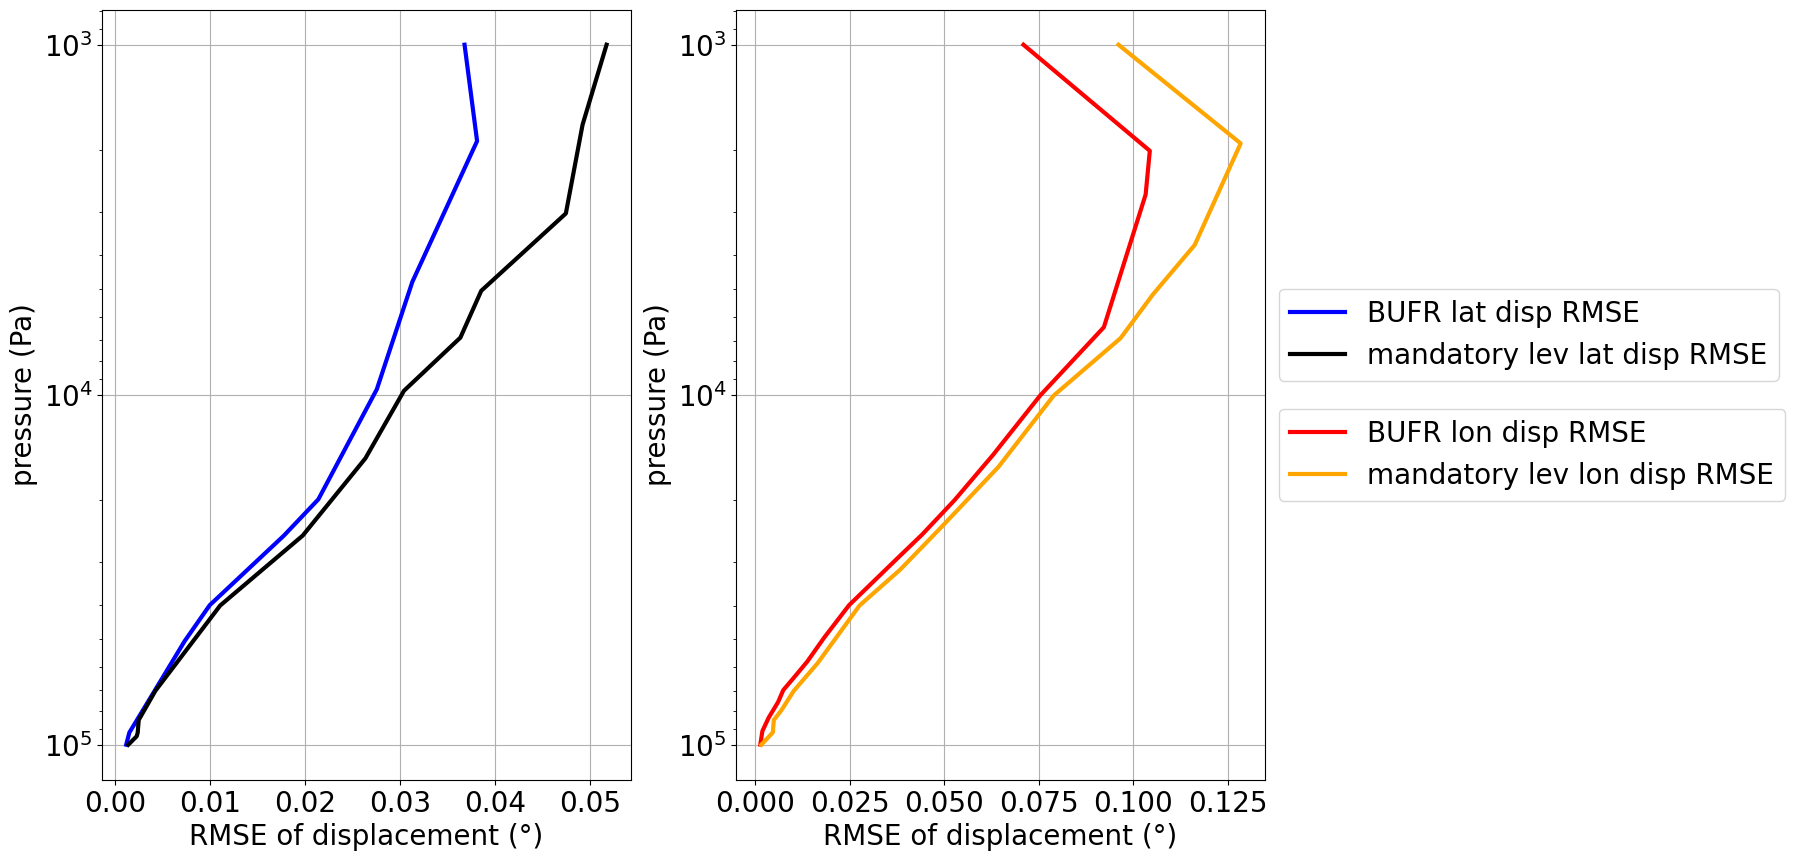

In [48]:
fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
ax1[0].set_yscale('log')
ax1[0].plot(np.array(bufrlatrmse.val), bufrlatrmse.p, color = 'blue', label = 'BUFR lat disp RMSE')
ax1[0].plot(np.array(redbufrlatrmse.val), redbufrlatrmse.p, color = 'black', label = 'mandatory lev lat disp RMSE')

ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
ax1[0].set_ylabel('pressure (Pa)')
ax1[0].set_xlabel('RMSE of displacement (°)')
# ax1[0].legend(loc='upper center')
ax1[0].legend(loc='lower left', bbox_to_anchor=(2.2, 0.5))

ax1[0].grid()

ax1[1].set_yscale('log')
ax1[1].plot(np.array(bufrlonrmse.val), bufrlonrmse.p, color = 'red', label = 'BUFR lon disp RMSE')
ax1[1].plot(np.array(redbufrlonrmse.val), redbufrlonrmse.p, color = 'orange', label = 'mandatory lev lon disp RMSE')
ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
ax1[1].set_ylabel('pressure (Pa)')
ax1[1].set_xlabel('RMSE of displacement (°)')
# ax1[1].legend(loc='upper center')
ax1[1].legend(loc='upper left', bbox_to_anchor=(1, 0.5))

ax1[1].grid()

# value_nr = []
# for i in plev_vals:
#     value_nr.append(np.sum(plev_vals[i]))
# ax1[2].barh(stdplevs, value_nr, np.array(stdplevs)*7, color='g', alpha = 0.4, align='center')
# ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
# ax1[2].set_xlabel('Number of Values')
# ax1[2].tick_params(labelleft=False)
# ax1[2].grid()

# maplt.title('LEVEL MRE for Displacement')
maplt.show()
maplt.close()